# Emulators: First example

This example illustrates Bayesian inference on a time series, using [Adaptive Covariance MCMC](http://pints.readthedocs.io/en/latest/mcmc_samplers/adaptive_covariance_mcmc.html) with emulator neural networks .

It follows on from [Sampling: First example](../sampling/first-example.ipynb)

Like in the sampling example, I start by importing pints:

In [1]:
import pints

C:\Users\plagl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\plagl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\plagl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\plagl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passi

Next, I create a model class using the "Logistic" toy model included in pints:

In [2]:
import pints.toy as toy

class RescaledModel(pints.ForwardModel):
    def __init__(self):
        self.base_model = toy.LogisticModel()
    
    def simulate(self, parameters, times):
        # Run a simulation with the given parameters for the
        # given times and return the simulated values
        r, k = parameters
        r = r / 50
        k = k * 500
        return self.base_model.simulate([r, k], times)
    
    def simulateS1(self, parameters, times):
        # Run a simulation with the given parameters for the
        # given times and return the simulated values
        r, k = parameters
        r = r / 50
        k = k * 500
        return self.base_model.simulateS1([r, k], times)
    
    def n_parameters(self):
        # Return the dimension of the parameter vector
        return 2

# Rescale parameters
#found_parameters = list(found_parameters)
#found_parameters[0] = found_parameters[0] / 50
#found_parameters[1] = found_parameters[1] * 500

# Show score of true solution
#print('Score at true solution: ')
#print(score(true_parameters))

# Compare parameters with original
#print('Found solution:          True parameters:' )
#for k, x in enumerate(found_parameters):
    #print(pints.strfloat(x) + '    ' + pints.strfloat(true_parameters[k]))
    
model = toy.LogisticModel()

In order to generate some test data, I choose an arbitrary set of "true" parameters:

In [3]:
true_parameters = [0.015, 500]
start_parameters = [0.75, 1.0]

And a number of time points at which to sample the time series:

In [4]:
import numpy as np
times = np.linspace(0, 1000, 400)

Using these parameters and time points, I generate an example dataset:

In [5]:
org_values = model.simulate(true_parameters, times)

And make it more realistic by adding gaussian noise:

In [6]:
noise = 5
values = org_values + np.random.normal(0, noise, org_values.shape)

Using matplotlib, I look at the noisy time series I just simulated:

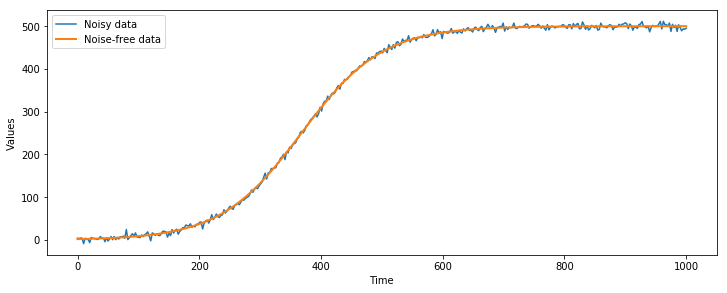

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4.5))
plt.xlabel('Time')
plt.ylabel('Values')
plt.plot(times, values, label='Noisy data')
plt.plot(times, org_values, lw=2, label='Noise-free data')
plt.legend()
plt.show()

Now, I have enough data (a model, a list of times, and a list of values) to formulate a PINTS problem:

In [8]:
model = RescaledModel()
problem = pints.SingleOutputProblem(model, times, values)

I now have some toy data, and a model that can be used for forward simulations. To make it into a probabilistic problem, a _noise model_ needs to be added. This can be done using the `GaussianLogLikelihood` function, which assumes independently distributed Gaussian noise over the data, and can calculate log-likelihoods:

In [9]:
#log_likelihood = pints.GaussianLogLikelihood(problem)
log_likelihood = pints.GaussianKnownSigmaLogLikelihood(problem, noise)

This `log_likelihood` represents the _conditional probability_ $p(y|\theta)$, given a set of parameters $\theta$ and a series of $y=$ `values`, it can calculate the probability of finding those values if the real parameters are $\theta$.

This can be used in a Bayesian inference scheme to find the quantity of interest:

$p(\theta|y) = \frac{p(\theta)p(y|\theta)}{p(y)} \propto p(\theta)p(y|\theta)$

To solve this, a _prior_ is defined, indicating an initial guess about what the parameters should be. 
Similarly as using a _log-likelihood_ (the natural logarithm of a likelihood), this is defined by using a _log-prior_. Hence, the above equation simplifies to:

$\log p(\theta|y) \propto \log p(\theta) + \log p(y|\theta)$

In this example, it is assumed that we don't know too much about the prior except lower and upper bounds for each variable: We assume the first model parameter is somewhere on the interval $[0.01, 0.02]$, the second model parameter on $[400, 600]$, and the standard deviation of the noise is somewhere on $[1, 100]$.

In [10]:
# Create bounds for our parameters and get prior
#bounds = pints.RectangularBoundaries([0.01, 400], [0.02, 600])
bounds = pints.RectangularBoundaries([0.5, 0.8], [1.0, 1.2])
log_prior = pints.UniformLogPrior(bounds)

With this prior, the numerator of Bayes' rule can be defined -- the unnormalised log posterior, $\log \left[ p(y|\theta) p(\theta) \right]$, which is the natural logarithm of the likelihood times the prior:

In [11]:
# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

Finally we create a list of guesses to use as initial positions. We'll run three MCMC chains so we create three initial positions:

In [12]:
xs = [
    np.array(start_parameters) * 0.9,
    np.array(start_parameters) * 1.05,
    np.array(start_parameters) * 1.15,
]

And this gives us everything we need to run an MCMC routine:

In [13]:
chains = pints.mcmc_sample(log_posterior, 3, xs)

Using Haario-Bardenet adaptive covariance MCMC
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Time m:s
0     3      0         0         0          0:00.0
[0.61067504 0.86983178]
-61345.45804123846


[0.80869894 0.97459514]
-4502.853301972
accepted


[0.82178264 1.19934209]
-62000.46092490733


1     6      0         0.5       0          0:00.0
[0.59805471 0.87507883]
-67457.49953818983


[0.71598822 1.04847512]
-3684.577812389136
accepted


[0.80413083 1.16909718]
-42751.98938068879
accepted


2     9      0         0.667     0.333      0:00.0
[0.69184481 0.79111252]
-inf


[0.55438259 0.98866306]
-73891.88061464943


[0.85307151 1.2869366 ]
-inf


3     12     0         0.5       0.25       0:00.0
[0.71215081 0.94300787]
-8050.358264274319
accepted


[0.67498734 1.10437748]
-13138.002012424298


[0.85279304 1.15218688]
-51237.62467679613


[0.65507321 0.92495055]
-25508.232366941575


[0.82625987 1.21349055]
-inf


[0.93363674 0.98232781]
-2

[0.73599874 0.88321999]
-16588.2806259702


60    183    0.0984    0.0656    0.0984     0:00.2
[0.65019674 0.9858481 ]
-17698.21532964538


[0.86563369 0.97391607]
-12768.774684790775


[0.76401133 1.01770912]
-1970.1338743582694


[0.82856482 0.84320044]
-24635.463695645856


[0.83734281 0.8553314 ]
-21861.34967043313


[0.78305899 1.06075549]
-8055.745161842536


[0.69176805 1.02737097]
-5379.297815882469


[0.67541878 0.96260851]
-12782.93806933788


[0.71258161 1.14338603]
-18555.56829833682


[0.63796678 1.00983126]
-20085.60605225532


[0.63604417 1.03833952]
-19500.791770569234


[0.7545707  0.93130274]
-5822.007517134092


[0.84211333 0.92563427]
-10424.28641852699


[0.86166109 0.94462176]
-11949.670196485926


[0.67950871 1.13567146]
-17683.128381318184


[0.83871432 1.03877382]
-14109.756403999945


[0.85907268 0.91591026]
-13405.668206034978


[0.87321485 1.05420303]
-25252.377814436637


[0.81604827 0.78382377]
-inf


[0.78977132 0.88804343]
-12704.89958969715


[0.6901358



[0.72911978 1.06937074]
-5334.845337536572


[0.65352318 1.00866174]
-14732.465317760032


[0.63962299 1.05572723]
-18133.397057849223


[0.87166673 1.00044397]
-15890.530943635691


[0.86522267 0.96448992]
-12420.527593487841


[0.71703471 1.01002129]
-2466.4293744627957


[0.77328577 0.91088578]
-8467.177508274328


[0.79545562 0.96866825]
-3432.7403498532203


[0.84507779 0.98669235]
-9742.525251376368


[0.78899178 0.90932456]
-8779.37320612108


[0.73125468 1.02460965]
-1868.823922100169


[0.74175334 0.82991144]
-32016.195006629787


[0.66136072 1.11482477]
-16733.694725419216


[0.70603446 1.11751452]
-12877.9751276005


[0.70283973 1.06910451]
-6181.029509549128


[0.7968658  1.13475899]
-28318.099527013146


[0.83014613 0.9791549 ]
-7157.758057796078


[0.63481346 0.88396847]
-44261.44453331667


[0.72166217 1.0510573 ]
-3628.9532861898533


[0.8132077  0.92435793]
-7827.027668709921


[0.86943483 1.12826552]
-47115.937795592916


[0.8640543  0.98354909]
-12959.914345731895


[0.73936242 0.96316376]
-3029.441903610568


[0.77331623 0.97613847]
-1987.2104408006937


[0.76023843 1.01084292]
-1540.7565260017611


[0.75076161 1.00942369]
-1291.8723197249558


[0.73015291 0.98046472]
-2399.830203232171


[0.75738404 1.03913865]
-3074.1482224168867


[0.7526529 1.0036558]
-1226.1021796609207


[0.79144435 0.98436348]
-2911.696510197402


[0.74778157 1.00422031]
-1210.1557993440776
accepted


[0.75124075 1.01055017]
-1321.125725933109


[0.75568974 0.96878777]
-2092.3799515747205


[0.74839052 1.00644072]
-1230.6518522002973


[0.75058348 0.98804191]
-1335.9412911641482


[0.74210091 0.95082101]
-4045.0406582252344


[0.75343835 1.00986742]
-1338.1618194985126


[0.75441341 1.00770647]
-1309.4467381439538


[0.76715116 0.98623381]
-1559.05559085351


[0.74854142 1.00139413]
-1196.9662146099988
accepted


[0.74069791 0.99976597]
-1303.2326128754185


[0.75730221 0.97088388]
-1960.9777331564387


[0.74423677 1.00451369]
-1233.423140845413


[0.74713211 0.99727045]
-

[0.74887935 1.00009047]
-1195.6799782229302
accepted


[0.74852352 0.99980132]
-1197.0640262262432


[0.74868966 1.00046117]
-1195.9617958990452
accepted


[0.74905527 1.00062056]
-1195.2608988778238
accepted


[0.74971894 1.00088907]
-1195.1963462870883
accepted


[0.74918168 0.99895742]
-1196.994355906748


[0.74903148 0.99935566]
-1196.3822501347047
accepted


[0.74893024 1.00103234]
-1195.7767246190817
accepted


[0.7482228  1.00058477]
-1197.3525884455526


[0.74878475 0.9993553 ]
-1197.0900647945805


[0.7476974  1.00166753]
-1199.969375326871


[0.74846147 1.00053675]
-1196.5771993913595
accepted


[0.74925772 0.99854661]
-1198.1219063131903


[0.74820237 1.00326843]
-1203.8681736568146


[0.74748343 1.0009826 ]
-1200.490425344023


[0.74846661 0.99994508]
-1197.0414409267983
accepted


[0.74931394 1.00093475]
-1195.2795901348015
accepted


[0.74877436 1.00130147]
-1196.3869198633247
accepted


[0.74828163 0.99990176]
-1197.8010604432463
accepted


[0.74866661 1.00081459]
-1196.

[0.75039021 1.00011933]
-1195.0469423644693
accepted


[0.74940044 0.99836428]
-1198.4398110200202


[0.74861353 1.00387925]
-1207.225807854846


[0.75053997 0.99863078]
-1196.5816429345907


[0.75009081 0.99786004]
-1199.2742634426259


[0.75215633 0.99883229]
-1200.6971482195638


[0.75087969 1.00053185]
-1196.637486027326


[0.75063951 1.00115158]
-1197.346597232345


[0.74717902 1.00062186]
-1202.4363089837727


[0.74959533 1.00071815]
-1194.9434809785696
accepted


[0.75063679 1.00061169]
-1196.101022672272


[0.75061052 1.00161783]
-1198.798544553498


[0.75027412 1.00173962]
-1198.2750490875935


[0.75021109 1.00060257]
-1195.2437265965218
accepted


[0.748209   1.00124501]
-1197.63186935653


[0.74977417 1.00071964]
-1194.9843492246005
accepted


[0.74844461 0.99945829]
-1198.0567986686274


[0.74924587 1.00131329]
-1195.9398924199995
accepted


[0.75100605 0.99851047]
-1197.4048161631692


[0.75227486 1.00269589]
-1214.4679494027275


[0.74984013 0.9995519 ]
-1194.889600372172

-1198.4705625203887


[0.75322837 0.99875618]
-1207.2762633284262


[0.74998065 1.00016431]
-1194.656720537512
accepted


[0.75045099 1.00024959]
-1195.2354929214257


[0.7533422 1.0002605]
-1210.7363305354636


[0.74956198 0.99936883]
-1195.3597451369


[0.74853088 1.00075592]
-1196.38855889237


[0.75069568 0.99964113]
-1195.4771559298229
accepted


[0.75111581 0.99945789]
-1196.4846000518653
accepted


[0.74984176 0.99966254]
-1194.7822187340698
accepted


[0.74988178 0.99961626]
-1194.8138951530293
accepted


[0.75142211 0.99903154]
-1197.616110259277


[0.7495035  1.00036054]
-1194.7205338431565
accepted


[0.74958163 0.99986041]
-1194.7637643254259
accepted


[0.75246234 0.99934303]
-1202.3609498867897


[0.74967413 1.00230765]
-1199.3698621417877


[0.74969126 0.99980092]
-1194.7342613586586
accepted


[0.75148366 0.99945769]
-1197.6673097490893


[0.74972228 1.00032932]
-1194.6501862726657
accepted


[0.7472531  1.00030912]
-1202.4076548441312


[0.75409325 0.99836157]
-1214.44


[0.74980463 0.99904208]
-1195.7340900399752
accepted


[0.74845204 1.00150401]
-1197.3443938341932


[0.74964466 0.99901427]
-1195.9690128792097
accepted


[0.74905606 0.99915476]
-1196.7885983448891
accepted


[0.75020275 1.00055965]
-1195.175148047401
accepted


[0.74974772 0.99701526]
-1204.4252505823026


[0.75031043 0.99952671]
-1195.0175318046975
accepted


[0.75098297 1.00016535]
-1196.419986993888
accepted


[0.75024581 0.99772839]
-1199.7005162142118


[0.751221   0.99852185]
-1197.8047285381967


[0.75229036 1.00104093]
-1205.194356880245


[0.74849994 0.99778566]
-1204.6652227839918


[0.74931878 1.00091365]
-1195.2498986442458
accepted


[0.75245205 0.99928026]
-1202.2623010387908


[0.74748925 0.99853437]
-1206.8245205038263


[0.75229149 1.0009385 ]
-1204.8040286870494


[0.75336689 0.99956371]
-1209.1628645368546


[0.74949418 1.00163479]
-1196.7402288146097


[0.74957523 1.00229204]
-1199.1655636264115


[0.7531822  0.99923868]
-1207.2026630285457


[0.74958675 1.00067

[0.74880244 0.99979103]
-1196.2094169012105


[0.74564996 0.99931931]
-1219.7232675510415


[0.74926771 1.00243111]
-1199.4804993680375


[0.75025057 1.00193876]
-1198.9972561605782


[0.7551459  1.00252918]
-1246.92863205536


[0.74944107 1.00157442]
-1196.5498271106678
accepted


540   1623   0.224     0.237     0.245841   0:01.5
[0.74804388 0.99874478]
-1202.3262792604933


[0.75011276 0.99920395]
-1195.3064181341263
accepted


[0.74943385 1.00103655]
-1195.3868236049823
accepted


[0.74806491 1.00191764]
-1199.1664582043302


[0.75423012 0.99708409]
-1217.248778016146


[0.74800733 1.00016071]
-1198.5748948110786


[0.75287794 1.00135816]
-1211.25046109314


[0.75120891 1.00024943]
-1197.280967676792


[0.74797773 0.9994298 ]
-1200.2592913624987


[0.74953533 1.00110286]
-1195.501469453108
accepted


[0.74732651 1.00043263]
-1201.7697100427565


[0.74830805 1.00041653]
-1197.1257702150256


[0.74601749 1.00503181]
-1222.0233668584538


[0.74641286 0.99900388]
-1213.4067244391065




-1199.0743288964802


[0.74755007 1.00177444]
-1200.7437143620925


[0.74754255 1.0019206 ]
-1201.0235135676176


[0.75258485 1.00055204]
-1205.5329204374545


[0.74987782 1.00298238]
-1203.2766598104727


[0.75100777 1.00074943]
-1197.5082593453258
accepted


[0.75145071 1.00003325]
-1197.920243359423


[0.74739485 1.00401701]
-1209.7401658221536


[0.74493192 1.00368093]
-1223.3053872244338


[0.75034023 0.99711073]
-1202.7311077989718


[0.74709195 1.00229394]
-1203.8672918364437


[0.75401474 0.9994847 ]
-1214.9478776750275


[0.75313979 0.99960247]
-1207.3812587715597


[0.74906748 1.00337882]
-1204.256616449569


[0.75545032 0.99640962]
-1230.892636973222


[0.75441156 0.99877052]
-1217.774657228488


[0.74901551 1.00249722]
-1199.687569824256
accepted


[0.7524679  0.99940766]
-1202.441759418531


[0.75137214 1.00089515]
-1199.3753340254343


[0.74764003 1.00320867]
-1204.7869862894113


[0.74727355 1.00303048]
-1205.2941999047007


[0.74921146 1.00101462]
-1195.4515564226695
ac

[0.74771479 0.99948019]
-1201.551253753209


[0.75101961 0.99663297]
-1205.2161281038366


[0.74819722 1.00591183]
-1224.528333083875


[0.75134523 1.00070611]
-1198.739599493645
accepted


[0.74721487 0.99883311]
-1207.3824084730265


[0.74974687 0.99920709]
-1195.4537232237485
accepted


[0.74924785 1.00208257]
-1198.0955446947335
accepted


[0.74964121 1.00043913]
-1194.708938152713
accepted


[0.75026921 0.99969164]
-1194.8862971309168
accepted


[0.75042782 1.0053151 ]
-1225.560736724622


[0.75157026 0.99818134]
-1199.4565453866694


[0.74531507 1.00056892]
-1218.6033688243801


680   2043   0.232     0.233     0.242      0:01.9
[0.74877417 1.00176884]
-1197.3586503330184
accepted


[0.74599752 1.00227262]
-1210.8964484181645


[0.74993287 0.99699753]
-1204.0825124298212


[0.74660324 1.00566613]
-1224.3180865451222


[0.75148547 0.99707734]
-1203.2514598194934


[0.75086891 1.00247078]
-1203.874104637672


[0.7471498  1.00083222]
-1202.427269241211


[0.750215   0.99977053]
-119

accepted


[0.75255758 0.99883486]
-1202.8315174516283


[0.74920428 1.00022454]
-1195.0060700665852
accepted


[0.75229719 1.0007368 ]
-1204.1212160019854


[0.75053131 1.00187094]
-1199.5494845580824


[0.74698929 0.99964153]
-1205.8691725481324


[0.74948683 1.00125456]
-1195.791478495953
accepted


[0.75361745 0.99965557]
-1211.5477964082158


[0.74978312 0.99772472]
-1200.376144218389


[0.75054269 1.00100708]
-1196.6923870148328
accepted


[0.74862701 1.00178004]
-1197.5909943748184


[0.749991   1.00288223]
-1202.9908217633053


[0.75400315 1.00083913]
-1219.7296260470462


[0.75121199 0.99903712]
-1196.9999088677907


[0.75019291 0.99998308]
-1194.7698938545034
accepted


[0.75008651 0.9989162 ]
-1195.8469136711797
accepted


[0.75071208 0.99972322]
-1195.5003704011026


[0.75044223 1.00189927]
-1199.3839310774013


[0.75108082 1.00042729]
-1197.1105559181317


[0.7491934  0.99899394]
-1196.863376920697


[0.75150041 0.99836145]
-1198.846290156557


[0.75105215 0.99942429]
-119

[0.74906877 1.00210344]
-1198.1633407755887


[0.75117758 1.00005679]
-1196.9264959115806


[0.75026771 0.99894152]
-1195.7898578915456
accepted


[0.75023314 1.00164827]
-1197.8427242233365


[0.74902901 1.00085362]
-1195.454729945777
accepted


[0.74952609 0.99988697]
-1194.7912176243103
accepted


[0.74911793 1.00287499]
-1201.4800292583689


[0.74782477 0.99831017]
-1205.7026099103505


[0.75193265 1.00083919]
-1202.149923709231


[0.75037426 0.99571009]
-1212.5679181677067


[0.75231836 0.99880052]
-1201.5283440671776


[0.74978778 0.99982132]
-1194.68320878794
accepted


[0.75106728 0.99932424]
-1196.406296963464
accepted


[0.75345769 0.99887667]
-1209.0888983631698


[0.74650715 1.00118397]
-1206.5754947084797


[0.74873973 0.99966506]
-1196.593523681601


[0.74876179 1.00128071]
-1196.3745437914206


[0.74914907 1.00046201]
-1195.07820430063
accepted


[0.74895559 0.99825546]
-1200.2473012982164


[0.75162424 0.99553629]
-1213.1232919829956


[0.74941345 1.00106626]
-1195.4386



[0.74980614 1.00135819]
-1196.228276924807


[0.74989882 1.00046237]
-1194.7794270742563
accepted


[0.74760654 0.99746973]
-1212.4728459544742


[0.75084573 0.99999447]
-1195.8884358068542


[0.75304743 0.99944875]
-1206.4293003254515


[0.74931383 0.99947881]
-1195.5414133272802
accepted


[0.75025342 0.99955266]
-1194.9560679357728
accepted


[0.74943722 1.00019242]
-1194.750635330002
accepted


[0.74936645 0.99882627]
-1196.9440727696792


[0.75014679 1.00132021]
-1196.6260151339939


[0.74781341 0.99817107]
-1206.5302616533934


[0.75162152 1.00141566]
-1202.5060528992983


[0.75201778 0.99684016]
-1205.6022183526627


[0.75031295 0.9985399 ]
-1196.7432989767456
accepted


[0.75030987 1.00011951]
-1194.9352256361524
accepted


[0.75089861 0.99941352]
-1195.9641197195565
accepted


[0.74990223 0.99915634]
-1195.4385431656303
accepted


[0.75079391 0.9989449 ]
-1196.2426014661635


[0.75003903 1.00020179]
-1194.704293355129
accepted


[0.7492685  0.99982924]
-1195.152103455568
acc


[0.75041275 1.00011185]
-1195.0771412654856
accepted


[0.75245814 0.99846857]
-1202.5415906443445


[0.75084959 0.99753668]
-1200.4461569303699


[0.75200994 1.00036369]
-1201.256136071098


[0.75283479 0.9972433 ]
-1207.2410447114219


[0.74999504 1.00061277]
-1195.0025829647245
accepted


[0.75279957 0.99907391]
-1204.347014545024


[0.75191647 0.99848955]
-1200.0167302940658


[0.74807633 0.99952333]
-1199.5114180867974


[0.75028001 1.0001694 ]
-1194.9223617143766
accepted


[0.74971436 0.99713492]
-1203.7699387903788


[0.75115487 1.00102425]
-1198.8095892517726


[0.75098202 0.99962143]
-1196.1117275136746


[0.75067026 0.99897583]
-1196.022918762956
accepted


[0.75194458 1.00123997]
-1203.7039538641045


[0.74928446 1.00287653]
-1201.6200017880483


[0.75048926 0.99735781]
-1201.2901344036134


[0.7518202  0.99869057]
-1199.36518667517


[0.74716023 1.00169976]
-1202.5313700020868


[0.74940516 0.99994619]
-1194.8735000604179
accepted


[0.75478795 0.99683788]
-1222.926520728

-1198.1339642809148


[0.74804911 1.00151499]
-1198.4691929067142


[0.75097878 1.00077799]
-1197.4728597339451


[0.74920182 0.99848987]
-1198.4846781707804


[0.74922623 1.00053304]
-1195.0062418111322
accepted


[0.74728787 0.99829717]
-1209.6174918635343


[0.74954103 0.99970366]
-1194.930731107425
accepted


[0.74844282 0.9996529 ]
-1197.630790346753


[0.75130874 0.99797685]
-1199.3879859377646


[0.75075519 1.00014407]
-1195.7794420369598


[0.74965242 1.00041494]
-1194.69443511553
accepted


[0.75179077 0.99985484]
-1199.2090224437193


[0.74853388 0.99944857]
-1197.7369860779997


[0.74827365 0.99961923]
-1198.3834687735814


[0.74869767 0.99826513]
-1201.228119440768


[0.74896895 1.00342206]
-1204.4437523682327


[0.74999106 1.00002418]
-1194.6409152018437
accepted


[0.74632919 1.00213125]
-1208.2289332472217


[0.75020012 1.00297926]
-1204.2210538709196


[0.75124556 1.00027366]
-1197.4532851651086


[0.74805064 1.00297048]
-1202.7105722909052


[0.75013471 0.99941173]
-11

-1196.281097199844


[0.74767863 1.00303066]
-1203.895717609331


[0.74873118 1.00160659]
-1197.0310383623903


[0.75001714 1.00357804]
-1207.6326464755707


[0.74851332 1.00277273]
-1201.1316147996888


[0.7494702  0.99933934]
-1195.533806988086
accepted


[0.74875168 1.00122964]
-1196.3151811934633
accepted


[0.74817196 0.99962609]
-1198.813197946718


[0.7480441  1.00053218]
-1198.0606754608677


[0.74989369 1.00241024]
-1200.2430914591703


[0.75098573 0.99943027]
-1196.156740029685


[0.74917025 1.00052256]
-1195.067467650226
accepted


[0.74946587 1.0012536 ]
-1195.7865871864828
accepted


[0.74775583 1.00436042]
-1211.157572055557


[0.74873287 0.99949716]
-1196.9391823711246


[0.74856046 1.00415132]
-1209.111970867968


[0.75181963 1.00229714]
-1208.3130738795264


[0.75052643 0.99739595]
-1201.0830365772551


[0.75010375 1.00240814]
-1200.7394490306808


[0.74786804 1.00291998]
-1202.9139404303867


[0.75004316 1.00139025]
-1196.6385466506101


[0.75050356 0.99944778]
-1195.

[0.75114752 0.99941026]
-1196.584675884923


[0.74947629 1.00032338]
-1194.7274441271134
accepted


[0.74627396 1.00165138]
-1208.2769911448272


[0.75123483 1.00213531]
-1203.8311635548057


[0.7506796  0.99772275]
-1199.5937966014587


[0.75108365 0.99887503]
-1196.8859715697424


[0.75153576 0.9977695 ]
-1200.5539579409951


[0.75327282 0.9984484 ]
-1207.6643026682589


[0.75064519 0.99813593]
-1198.047643082986
accepted


1160  3483   0.23      0.236     0.239      0:03.2
[0.74895401 1.00171384]
-1197.0369280904592


[0.74845316 1.00307842]
-1202.6170902415902


[0.75150291 0.99571726]
-1211.64700849884


[0.74669422 1.00137115]
-1205.1925412946648


[0.7501399 1.0018798]
-1198.484779672762


[0.75302406 0.9985346 ]
-1205.8806438989184


[0.75073277 0.99694663]
-1203.3880848566635


[0.74908642 1.00059491]
-1195.2054900178296
accepted


[0.74970071 0.99862097]
-1196.959204658182
accepted


[0.75177253 1.00157289]
-1204.0913868275666


[0.74715952 1.00314979]
-1206.2288168304872


[

[0.74995757 0.99946615]
-1194.9568070476596
accepted


[0.75219492 0.99782063]
-1202.5416945953318


[0.74701211 1.00137437]
-1203.1519103771225


[0.75092315 0.99706038]
-1202.7695827982236


[0.75435899 0.99610179]
-1221.7057329032418


[0.75046358 0.99691021]
-1203.7659347337399


[0.75033459 0.99991504]
-1194.9109729689799
accepted


[0.75138093 0.9990848 ]
-1197.444450916917


[0.75021826 1.00018907]
-1194.8595655540635
accepted


[0.75061325 0.99849577]
-1196.9669331106006


[0.75577811 0.99558817]
-1237.4336307611825


[0.74990687 1.00171943]
-1197.4404232948284
accepted


[0.75109503 0.99877834]
-1197.0583908350184
accepted


[0.7483859  1.00167737]
-1197.8223009074222


[0.74950272 1.00201717]
-1197.997154968459
accepted


[0.75108961 1.00061346]
-1197.5005562736264


[0.74805838 1.00203466]
-1199.4640212415463


[0.74955892 1.00262066]
-1200.6593441731618


[0.74931664 1.00047661]
-1194.893762396556
accepted


[0.75609046 0.99379767]
-1251.523116012917


[0.74810639 1.0015085

[0.75180755 1.00069077]
-1200.9780540979057


[0.7497172  1.00273234]
-1201.5046923802183


[0.75188863 1.00075627]
-1201.6291566453986


[0.7487139  1.00044683]
-1195.904300992211


[0.74773004 1.00236598]
-1201.3702478408993


[0.74960048 1.00039607]
-1194.6950400055143
accepted


[0.74686646 1.00448107]
-1214.3852727942074


[0.74606399 1.00446594]
-1218.174469241166


[0.74874588 1.00213282]
-1198.4497682873393
accepted


[0.74830852 1.00192005]
-1198.5459955364586


[0.75257205 0.99946346]
-1203.1401016099876


[0.7474995 1.0023865]
-1202.2685388194486


[0.7488353  0.99934982]
-1196.9453857353099


[0.75075455 1.00159313]
-1199.2023281269485


[0.75219612 1.00133757]
-1205.7972794500313


[0.75186874 0.99909262]
-1199.2540511768248


[0.75287709 0.99864446]
-1204.8604825374653


[0.75095098 1.00138543]
-1199.1750012111581


[0.75074859 1.00078695]
-1196.750814060327


[0.74965842 1.00311441]
-1203.5482530868426


[0.7473101  1.00154002]
-1201.5903471422066


[0.75053464 0.9994572

-1241.9173179105742


[0.75350601 0.99904723]
-1209.609044780208


[0.75307742 1.00009545]
-1207.9817210041997


[0.75128691 0.99723818]
-1202.1921467436782


[0.75049176 1.00052908]
-1195.6353314273733
accepted


1360  4083   0.231     0.231     0.237      0:03.7
[0.75150247 1.00289965]
-1210.1864334935394


[0.74856327 0.99949188]
-1197.528669705485


[0.75003847 1.00128123]
-1196.3340078848632
accepted


[0.74784561 1.0011647 ]
-1198.8649826353578


[0.75025041 0.9983176 ]
-1197.4225039507708


[0.75125278 0.99792937]
-1199.4299432374019


[0.75073815 0.99973093]
-1195.5527096494577
accepted


[0.74989846 0.99772556]
-1200.1575874988


[0.75111696 1.00278359]
-1207.0584475306582


[0.75067894 0.99936597]
-1195.5797824906633
accepted


[0.75165231 0.99857954]
-1198.9111103916196


[0.75015148 1.00094171]
-1195.7272109135406
accepted


[0.75129328 0.99808599]
-1199.031478188411


[0.75150639 1.00001106]
-1198.1226265502228


[0.74984472 1.00505153]
-1219.7956803092443


[0.74962731 1.

[0.7483737  1.00225354]
-1199.3607229344725


[0.74990171 1.00022659]
-1194.6425136443827
accepted


[0.75348717 1.0004287 ]
-1212.6563131667556


[0.7490337  1.00221537]
-1198.5703913909706


[0.75099336 0.99953512]
-1196.14716910578


[0.75017677 1.00179593]
-1198.2484498469335


[0.74959244 0.99985511]
-1194.7592918482753
accepted


[0.74927105 0.99876909]
-1197.336771710516


[0.7487653  0.99948749]
-1196.8572022780675


[0.74975944 0.99977105]
-1194.7243154472283
accepted


[0.75052348 0.99787544]
-1198.9623036599921


[0.75061501 1.00048412]
-1195.8435543892588


[0.74946724 1.00199188]
-1197.8776837230616


[0.75049081 0.99925795]
-1195.4360800491436


[0.75007755 0.99975029]
-1194.7406423623188
accepted


[0.752204   0.99707686]
-1205.1261487174631


[0.75139172 0.99831405]
-1198.663571699711


[0.74990318 0.99992754]
-1194.6300577424458
accepted


[0.74845121 0.99689554]
-1210.9105888551128


[0.74880899 0.99933024]
-1197.0728623896464


[0.74762807 1.00290981]
-1203.558660831

-1207.045949657027


[0.75156363 0.99960284]
-1198.0127016964825


[0.75021556 0.9980647 ]
-1198.3326495473925


[0.75116015 1.00308824]
-1209.4071653529006


[0.75021627 0.99824497]
-1197.6798536161907


[0.74674356 0.99756579]
-1219.3330274877724


[0.7512204  1.00160221]
-1201.200951958743
accepted


[0.74719082 1.00027212]
-1202.8689007159435


[0.75028551 0.99791506]
-1198.8773079562009


[0.74880456 1.00030636]
-1195.7279940543892
accepted


[0.7490238  1.00370065]
-1206.2698457351203


[0.74777527 0.99846584]
-1205.2240532770736


[0.75086037 1.00055342]
-1196.617393161543


[0.7517455  0.99997634]
-1199.1463876643504


[0.74873837 0.99704356]
-1208.2066240584827


[0.74770626 1.00229983]
-1201.2646624307279


[0.7517967  0.99844632]
-1199.6341908194315


1500  4503   0.229     0.230513  0.238      0:04.1
[0.75128119 1.00104369]
-1199.4150010248761


[0.74745285 0.99911885]
-1204.4416619453636


[0.74757108 0.99783209]
-1210.2770751721089


[0.7469667  0.99935139]
-1207.07307204

-1202.8438605432445


[0.75243183 0.99695887]
-1206.4727611181


[0.75139086 1.00059642]
-1198.6727764517054


[0.75049024 1.00008133]
-1195.186814834319
accepted


[0.75046965 0.99979535]
-1195.0865660339362
accepted


[0.75047643 1.001525  ]
-1198.0493057470057


[0.74407134 0.99911996]
-1241.9237729158972


[0.74971099 1.00081115]
-1195.079116693557
accepted


[0.75009149 0.99846663]
-1197.0265993093292


[0.74762355 0.99908417]
-1203.4589791972705


[0.74844614 1.00266929]
-1200.7702684228454


[0.75130989 1.00106939]
-1199.6271501508422


[0.7531292  0.99940226]
-1206.9894531511939


[0.74775107 0.9969105 ]
-1215.639560857403


[0.75027186 0.99905063]
-1195.588174946299
accepted


[0.74796005 1.0001513 ]
-1198.8028487342694


[0.74996802 1.00177377]
-1197.7336011140387


[0.75154822 0.99997996]
-1198.2614602630917


[0.75234862 1.00025449]
-1203.0611619385518


[0.74834076 1.00148256]
-1197.5745288046433


[0.75040455 1.00002955]
-1195.0279286406026
accepted


[0.75097465 0.998054

[0.74825927 0.99860991]
-1201.7500506137255


[0.74973253 0.99998824]
-1194.6267525864314
accepted


[0.75039172 0.99888769]
-1195.9389568248057


[0.74931448 0.99908996]
-1196.3408043760192
accepted


[0.75161469 0.99899688]
-1198.2968708699266


[0.75398794 0.99883288]
-1213.6731658327315


[0.75110729 0.99773587]
-1199.874588934544


[0.75274057 0.99899121]
-1203.939771517611


[0.74944838 0.9956136 ]
-1216.5567619567953


[0.74962581 0.99845424]
-1197.630952464219


[0.74831189 1.00053178]
-1197.0588569758136


[0.74897581 0.99946768]
-1196.2954656855973


[0.74837964 0.99788116]
-1204.755440542594


[0.74988929 0.99778436]
-1199.896844384734


[0.7507246  0.99924626]
-1195.7568238320964
accepted


[0.7513718  0.99929299]
-1197.300666296885


[0.75058656 0.99671389]
-1204.8543947484873


[0.75255532 0.9979862 ]
-1203.8096890125084


[0.75085796 0.99973519]
-1195.8157077498527
accepted


[0.74812972 1.00012366]
-1198.0932015510637


[0.75196108 0.99950839]
-1199.7309890234776


[0.7


[0.74798013 1.00283679]
-1202.2989864344838


[0.74854418 1.0013809 ]
-1196.9394162310832


[0.74877778 1.00004894]
-1195.9672572826678
accepted


[0.74550485 1.00257835]
-1215.44547523996


1700  5103   0.23398   0.232     0.238      0:04.7
[0.74722836 1.00165459]
-1202.12272039003


[0.75026049 0.99718005]
-1202.4366556051177


[0.74993256 0.99478124]
-1222.864396012451


[0.74682441 0.99960326]
-1207.2720600981097


[0.75041479 1.00129701]
-1197.1501599763674
accepted


[0.74911908 0.99849896]
-1198.6933003636352


[0.74471586 1.00296833]
-1223.7379059011225


[0.75173501 1.00299027]
-1212.4559089096588


[0.74998466 0.99862514]
-1196.6298506223125


[0.75152453 1.00115704]
-1200.973693480163


[0.75193033 1.00288835]
-1213.1448256887068


[0.74685022 1.00235571]
-1205.2908776362224


[0.74963125 0.9987709 ]
-1196.6183565621982
accepted


[0.74994178 1.00252156]
-1200.8997780351401


[0.75114507 0.99876551]
-1197.1892597853107


[0.75170998 0.99946309]
-1198.5637005681529


[0.7496


[0.74814472 1.00168709]
-1198.4605194642352
accepted


[0.75378529 1.00108587]
-1218.6350507079937


[0.74997623 0.99931476]
-1195.1510164514907
accepted


[0.7478241  1.00021559]
-1199.3592156312916


[0.75095142 1.00242004]
-1203.9741636202905


[0.75537146 0.99641722]
-1230.0183277229912


[0.7507527  1.00179152]
-1199.997576051409
accepted


[0.75171937 0.99742613]
-1202.2464122049532


[0.75050544 0.99882465]
-1196.1324038825203


[0.74995922 1.00372129]
-1208.4939812495684


[0.75058261 0.99892379]
-1196.011388270337
accepted


[0.74891651 0.99787571]
-1202.2413165598873


[0.7517567  1.00081704]
-1201.0754988854644
accepted


[0.75027754 0.99830584]
-1197.4522587456672


[0.75159508 0.99597389]
-1209.8683281094693


[0.75103295 0.99920877]
-1196.3991431918669
accepted


[0.74865259 1.00011042]
-1196.2547720888108
accepted


[0.75013184 0.99648366]
-1207.067257366053


[0.75065062 0.99954952]
-1195.4252574505958
accepted


[0.74849002 1.00108771]
-1196.696676057785
accepted


[0

[0.74995166 1.00076888]
-1195.1738480604843


[0.75507987 1.00137898]
-1236.5144656236046


[0.75066149 0.99753547]
-1200.3999657401753


[0.74947185 1.0000926 ]
-1194.7410265539663
accepted


[0.75363865 0.99823147]
-1210.576302820701


[0.74930684 1.00045359]
-1194.8949533470095
accepted


[0.7475224  1.00066795]
-1200.4190047251711


[0.75003635 0.99963225]
-1194.8008766942235
accepted


[0.74988686 1.00319179]
-1204.591090033309


1840  5523   0.23      0.229     0.238      0:05.1
[0.74913527 0.99842413]
-1198.9350482763004


[0.75038606 0.99757853]
-1200.2817442463324


[0.74628954 1.00147996]
-1208.1438599990886


[0.7510975  0.99988372]
-1196.5207863835108


[0.75117731 1.00043872]
-1197.4781024680467


[0.74840231 0.99967282]
-1197.746032893861


[0.74956763 1.00083963]
-1195.0899381523286
accepted


[0.75014073 1.00115924]
-1196.1944011395713


[0.74765074 1.00065468]
-1199.7686411975699


[0.75017548 1.00056953]
-1195.150716267167
accepted


[0.74870543 0.99922934]
-1197.6705


[0.75021505 0.99901666]
-1195.6365167803192
accepted


[0.7486705  1.00023995]
-1196.1029284400204
accepted


[0.7505552  0.99986651]
-1195.223210530357
accepted


[0.75284848 0.99825078]
-1205.0116062561221


[0.74954446 1.00265786]
-1200.8229287482359


[0.7502109  1.00113202]
-1196.2544741602558
accepted


[0.75047407 0.99819934]
-1197.7856525593425


[0.75127943 0.99999846]
-1197.2232926763552
accepted


[0.75026639 0.99914202]
-1195.4351087490536
accepted


[0.74928133 0.99871564]
-1197.482437659796


[0.7493443  1.00203726]
-1197.9673601797363


[0.74705108 1.00149239]
-1202.971766259702


[0.74973526 0.99776003]
-1200.303542265026


[0.75421648 0.99871501]
-1215.7587749691702


[0.75102125 0.99732033]
-1201.5307140711418


[0.75170338 1.00010556]
-1199.1370793834765


[0.75003491 1.00074329]
-1195.2207014296773
accepted


[0.75124707 0.99815538]
-1198.7415938429006


[0.75052906 1.00156653]
-1198.3517549935257


[0.74926003 1.00383912]
-1207.5580206923885


[0.75082046 0.999823

[0.75177344 0.99970375]
-1198.9781737477017


[0.74999961 1.00331843]
-1205.7568340129912


[0.75186521 0.99566356]
-1212.4345921797888


[0.74787317 1.00094808]
-1198.6765447869946


[0.75081573 1.00239234]
-1203.191209161064


[0.7496177  0.99932371]
-1195.3723283272548
accepted


[0.75029841 0.99882359]
-1196.0412226656238
accepted


[0.74913918 0.99971771]
-1195.5101977026102
accepted


[0.75114448 0.99854015]
-1197.60195109331
accepted


[0.75004686 1.00020748]
-1194.7120997242166
accepted


[0.74677195 0.99988472]
-1206.7866000321208


[0.75344562 0.99526619]
-1220.4550181147536


[0.7553739  0.99971057]
-1231.527940839874


[0.7505435  0.99882215]
-1196.166214282087


[0.75096722 0.99913953]
-1196.3140459666631
accepted


[0.74871735 0.9995999 ]
-1196.7821690754836


[0.75159785 1.00090125]
-1200.4930204671614


[0.74946548 0.99875562]
-1196.951601341793
accepted


[0.74530256 1.00255433]
-1217.2645293014593


[0.74791627 1.00077917]
-1198.4989329429588


[0.74919914 0.99718951]

[0.75183007 0.99896733]
-1199.1513063684208


[0.75191213 0.99845547]
-1200.05320399453


[0.75285139 0.99932472]
-1204.8661856506064


[0.74781448 1.00148831]
-1199.2704281575286
accepted


[0.75233312 1.001272  ]
-1206.4802326908653


[0.74841436 1.00053877]
-1196.721741817096


[0.75070129 1.00058395]
-1196.2195598278142
accepted


[0.751741   1.00032627]
-1199.7257707999115


[0.7505042  1.00271497]
-1203.7323363492567


[0.75014527 1.00082533]
-1195.497725896223
accepted


[0.75143626 1.00006157]
-1197.8971825247204


[0.75038821 0.99852344]
-1196.7945086874545


[0.7484307  1.00450695]
-1211.7618519223704


[0.74940361 1.00025052]
-1194.7759036893385
accepted


[0.75113402 0.99715006]
-1202.4395484601134


[0.75018177 1.00203077]
-1199.203896257544


[0.75036997 0.99868185]
-1196.3834045961737


[0.75157989 0.99907279]
-1198.1195438854738
accepted


[0.75225749 1.00037491]
-1202.7796038709573


[0.74940293 0.99917064]
-1195.9829441641218
accepted


[0.75243524 0.99912185]
-1202.1

[0.75110265 0.99903531]
-1196.7271077830335
accepted


[0.74715221 0.99961712]
-1204.7573337367473


[0.74792543 1.0015847 ]
-1198.9890673332575


[0.75112385 0.99960677]
-1196.4981533799205
accepted


[0.75039913 0.99880293]
-1196.1171248046553


[0.75216487 1.00136685]
-1205.7121396711204


[0.75279204 0.99625234]
-1211.3568847918282


[0.74874315 0.99883847]
-1198.7293736709996


[0.74540978 1.00341119]
-1218.1763815234194


[0.74969927 0.99994688]
-1194.6514032260495
accepted


[0.74981351 1.0000298 ]
-1194.6064087305006
accepted


[0.7496359  1.00070479]
-1194.9303777172224
accepted


[0.74925575 1.00045987]
-1194.9486527703987
accepted


[0.74695482 1.00414179]
-1211.9527633176533


[0.74765424 1.00045713]
-1199.9174389845132


[0.74792084 0.99952957]
-1200.2766106857996


[0.75279862 1.00176169]
-1212.7770932202666


[0.74975175 1.00070024]
-1194.9515871894473
accepted


[0.74948423 0.99791131]
-1200.1719380612847


[0.75156981 0.99716286]
-1203.0099726799579


[0.75255352 1.002


[0.74796902 0.99935972]
-1200.5106586817692


[0.74916858 1.0002773 ]
-1195.0465858246046
accepted


[0.74935766 1.0014717 ]
-1196.2715965496643


[0.74853142 1.00603339]
-1226.2594164802977


[0.74748797 1.00129004]
-1200.5289446618547


[0.75037665 1.00197267]
-1199.4962421260896
accepted


[0.75047609 1.00194879]
-1199.702473436944


[0.75032666 0.9985564 ]
-1196.69847627555


[0.75182966 0.99874229]
-1199.342887331257
accepted


[0.75016922 1.00108271]
-1196.0616048256984
accepted


[0.75098368 1.00229062]
-1203.407404843264


[0.74865725 1.00059008]
-1196.034799795598
accepted


[0.75067538 1.00282931]
-1205.149063715667


[0.75250908 0.99641262]
-1209.3724580128794


[0.75128471 0.99814118]
-1198.8580437641149


[0.75026586 0.99830413]
-1197.4613699111499


[0.74651831 1.00168461]
-1206.4942574720617


[0.74501193 1.00090896]
-1221.165937224667


[0.74986666 1.00000651]
-1194.6109496958945
accepted


[0.74721195 1.00111402]
-1201.9512674855637


[0.74678371 1.00399792]
-1211.848

accepted


[0.75179406 0.99700696]
-1204.2221550604443


[0.74928405 1.00304645]
-1202.5382988398956


[0.7504594  1.00132863]
-1197.3611457886027


[0.74768522 1.00294645]
-1203.5286252366739


[0.74927499 0.99756668]
-1202.5778107107892


[0.74809633 1.00094995]
-1197.809519872518


[0.74812793 1.0026665 ]
-1201.298031213336


[0.74818577 1.00207134]
-1199.2249154029632


[0.75084747 1.00019397]
-1196.0644234190659
accepted


[0.75055004 1.00083679]
-1196.3195500860236


[0.75076531 0.99763634]
-1199.9808609231086


[0.7504492  1.00174455]
-1198.778269994102


[0.74776627 1.00056365]
-1199.268592793755


[0.75070671 1.00001814]
-1195.5745391902906
accepted


[0.74993554 0.99923691]
-1195.2833795038932
accepted


[0.74814195 1.00379868]
-1206.9371394477528


[0.75249524 0.99951054]
-1202.7040369604622


[0.75173148 0.99522286]
-1215.744067199896


[0.74902243 0.99705415]
-1206.7601132894688


[0.7495474  0.99969284]
-1194.9355893336656
accepted


[0.75236229 0.99641915]
-1208.82005285



[0.75107966 0.99859695]
-1197.3557890576153


[0.74925549 1.00004457]
-1195.005180054179
accepted


[0.74657976 1.00236605]
-1206.9227890471675


[0.75128712 0.99552505]
-1213.0872331023354


[0.75073526 1.00040671]
-1196.0301712033677
accepted


[0.74682027 1.00254931]
-1205.9096852709959


[0.74881385 0.9987477 ]
-1198.7886936653927


[0.74934014 0.99777872]
-1201.2321932886123


[0.74791693 1.00080206]
-1198.4928238095706


[0.75489158 0.99650679]
-1224.8666933459137


[0.7491851  1.00349125]
-1205.0838971702003


[0.74948156 0.99828152]
-1198.5712357955729


[0.75595353 0.99680801]
-1235.8644221747156


[0.75284269 0.99758344]
-1206.271490975524


[0.74841208 1.00326999]
-1203.6369432363165


[0.75021389 1.00043944]
-1195.0510509870205
accepted


[0.75065543 1.00170666]
-1199.2951292247901


[0.74869394 1.0037825 ]
-1206.598925310517


[0.75180329 1.0012687 ]
-1202.9547772822687


[0.75025098 1.00048209]
-1195.1490711148967
accepted


[0.7477678  1.00060171]
-1199.2349403262735



[0.75153555 0.99888177]
-1198.1253155747897
accepted


[0.74982728 0.99699334]
-1204.358016466097


[0.75246432 0.99898807]
-1202.2660719345931


[0.75045481 1.0003647 ]
-1195.3537827577543
accepted


[0.75007318 0.99934122]
-1195.1068349621894
accepted


[0.74891712 1.00065669]
-1195.4985222655735


[0.74799391 1.00189474]
-1199.3273444271179


[0.75132242 0.99746164]
-1201.2692708462969


[0.7494416  0.99842235]
-1198.1225343093504


[0.75308008 0.99499759]
-1220.7663509637473


[0.7510809  0.99952044]
-1196.3784604721504


[0.75167587 0.99740823]
-1202.206666901181


[0.74796879 1.00322122]
-1204.0356243890715


[0.74834802 1.00010348]
-1197.259948940328
accepted


[0.75142298 1.00158298]
-1202.1391153587517


[0.75274159 1.00065205]
-1207.055769107112


[0.74769925 1.00119417]
-1199.5004712155578
accepted


[0.7501407  0.99639856]
-1207.6591699623775


[0.74757209 0.99846879]
-1206.5755404241413


[0.7490554 1.0004966]
-1195.2206594823413
accepted


[0.74856359 0.99931363]
-1197.96

[0.7484145  0.99893204]
-1199.746597959635


[0.75010845 0.99992461]
-1194.706295822195
accepted


[0.75162949 0.99710783]
-1203.3831720629084


[0.74847571 1.00109178]
-1196.7363433893147
accepted


[0.74890632 0.99903392]
-1197.5511107526793


[0.75191553 0.9958472 ]
-1211.2047117915452


[0.74966462 0.998664  ]
-1196.8816040241313
accepted


[0.74996743 1.0029398 ]
-1203.2640134116339


[0.74906046 0.99934187]
-1196.3387566183007
accepted


2460  7383   0.235     0.232     0.235      0:06.7
[0.74995917 0.99924618]
-1195.2602129288052
accepted


[0.74971186 1.00002242]
-1194.6238632878476
accepted


[0.75060739 0.99480061]
-1220.5110619586594


[0.75194791 0.99805774]
-1200.9837482148153


[0.74517327 0.99902787]
-1227.015912902974


[0.74994781 0.99833671]
-1197.5751339321603


[0.74906196 1.00077205]
-1195.3435186276163
accepted


[0.75231019 0.99690743]
-1206.2350228073753


[0.74699745 0.99895336]
-1208.520745486154


[0.74785721 1.00093458]
-1198.7419804955978


[0.74882097 0.99

[0.74961846 0.99734585]
-1202.776430566785


[0.74864377 1.00010537]
-1196.2850709404502


[0.74859974 1.0007245 ]
-1196.2013286361462
accepted


[0.75331918 0.99646604]
-1212.937733546974


[0.75147819 1.00103223]
-1200.3086159104548


[0.74970663 1.00006279]
-1194.6177651557834
accepted


[0.74722125 0.99832447]
-1209.988535491329


[0.74898757 0.99700064]
-1207.2881921759165


[0.74938262 1.00064386]
-1194.939212918681


[0.74770747 1.00364313]
-1206.786611202756


[0.74958748 1.00176964]
-1197.2149722452832


[0.75070723 0.99668072]
-1204.9786015589586


[0.75050006 1.00075258]
-1196.0298742231491
accepted


[0.75043355 1.00216244]
-1200.5327645496316


[0.74752002 1.0019775 ]
-1201.2259122321034


[0.75117387 0.99603264]
-1209.208608474395


[0.74681952 0.99973399]
-1206.8751095121122


[0.75093258 1.00033209]
-1196.4791205709682


[0.7536126  0.99883664]
-1210.3438591018


[0.74754078 1.00190767]
-1201.0073497554722


[0.74842834 0.99852328]
-1201.28863258403


[0.75168021 1.0002

-1196.1898724314879
accepted


[0.74878475 1.00307105]
-1202.409417157866


[0.75015454 1.00300741]
-1204.2434783274816


[0.75004378 1.00134666]
-1196.5178626989416
accepted


[0.75022168 1.00247018]
-1201.3901550464536


[0.7492139  1.00139714]
-1196.1279160803663


[0.74622032 1.00206834]
-1208.9512392930185


[0.74766833 1.00233572]
-1201.4970772678084


[0.74833026 0.99955793]
-1198.2847333399395


[0.74906135 0.99677227]
-1208.589264013574


[0.75054106 1.00055596]
-1195.7820929681604
accepted


2600  7803   0.231     0.233     0.236832   0:07.1
[0.74903409 0.99814728]
-1200.4548391353578


[0.75045644 0.9992293 ]
-1195.4364464094342
accepted


[0.74802576 1.0009117 ]
-1198.0613692830855


[0.75073951 0.99723772]
-1201.8267841377178


[0.74836624 0.99893189]
-1199.9654169805385


[0.74851701 1.0013836 ]
-1197.0018955989767


[0.74816957 1.00043283]
-1197.6246476572123


[0.74900323 0.99556478]
-1219.323777095915


[0.7524002  0.99756872]
-1204.127863022434


[0.75173295 0.9984093

-1202.701183615514


[0.74854968 1.00144047]
-1197.0254868783702


[0.75076212 1.0000878 ]
-1195.749403628601
accepted


[0.75111234 1.00032492]
-1197.051856279191


[0.74912325 1.00078939]
-1195.2826292971934
accepted


[0.75009124 1.00001327]
-1194.69399994847
accepted


[0.75025469 0.99843756]
-1197.04527624573


[0.7487274  0.99926282]
-1197.5069573074402


[0.74772312 1.00041708]
-1199.6109499444372


[0.74607177 1.0034356 ]
-1213.2446557569308


[0.74793402 1.00198666]
-1199.7191554484152


[0.74795067 1.00130633]
-1198.5635609836377


[0.749698   0.99895976]
-1196.0317373979788
accepted


[0.74938581 1.00270186]
-1200.836759870194


[0.75232252 0.99828296]
-1202.1151333778646


[0.75246678 0.99857983]
-1202.4750245644302


[0.74750484 1.00273208]
-1203.3214873154218


[0.74989394 0.9977928 ]
-1199.849906475001


[0.75000411 0.99959004]
-1194.8303993632346
accepted


[0.74712105 1.00102997]
-1202.5012081497043


[0.74811792 1.0015912 ]
-1198.370908702708


[0.7497163 0.9989806]
-

[0.74977828 0.99807587]
-1198.8063002733138


[0.74869664 1.00024234]
-1196.0308039115866


[0.75177576 0.99847092]
-1199.5168950855134


[0.75353916 0.99779215]
-1210.309143521511


[0.75008275 1.00005394]
-1194.6927305331722
accepted


[0.75101001 1.00112717]
-1198.54274322737


[0.74874323 0.99752572]
-1204.9975627689953


[0.75062191 0.9992464 ]
-1195.6048861676156
accepted


[0.75013104 0.99858164]
-1196.666367954241


[0.74880412 0.99962725]
-1196.4692338082625


[0.74916427 1.00016766]
-1195.082613701825
accepted


[0.74670832 1.00252998]
-1206.4982580342426


[0.75258598 0.99778685]
-1204.4090646853783


[0.74700271 1.00146139]
-1203.240879247072


[0.74827059 1.00175775]
-1198.2637106448308


[0.74957634 0.99860746]
-1197.2054067462932


[0.74979242 1.00086385]
-1195.1960069928095


[0.7519953  0.99777675]
-1201.9018830922732


[0.75038192 0.99896855]
-1195.7804074222927


[0.74993178 1.0035918 ]
-1207.4480474046698


2740  8223   0.230208  0.231     0.238      0:07.5
[0.75044

accepted


[0.74935378 0.99994011]
-1194.9387470394245
accepted


[0.75080468 0.99870094]
-1196.6911184630105


[0.75060943 0.9991608 ]
-1195.6870538866576


[0.74856889 1.0009197 ]
-1196.369254821873


[0.75025074 1.00250078]
-1201.6394651774806


[0.74946079 0.99963636]
-1195.095228476436
accepted


[0.74872596 0.99876805]
-1199.0416884300773


[0.74865998 0.9978591 ]
-1203.4576185045712


[0.75053511 1.00029125]
-1195.4317757016881


[0.75024956 0.9980859 ]
-1198.2327256298727


[0.74881907 0.99957629]
-1196.5188853658763


[0.74964003 0.99906677]
-1195.8549392650664


[0.75008363 1.00004622]
-1194.6922564427489
accepted


[0.74976061 0.99997623]
-1194.6234930998696
accepted


[0.74982529 1.00107522]
-1195.5974956109246


[0.75193085 0.99883692]
-1199.6684059059805


[0.75057556 1.00139437]
-1197.8996695060016


[0.74996488 0.99869993]
-1196.4366457019294


[0.74836783 1.00223558]
-1199.314240079201


[0.74920606 1.00002735]
-1195.0890763850393


[0.75131781 1.0005522 ]
-1198.260494

[0.74870747 0.9982957 ]
-1201.0453978213545


[0.74793124 0.9973177 ]
-1211.173238281135


[0.75016821 0.99888541]
-1195.8995734749158


[0.7490388 0.9966722]
-1209.444928614463


[0.74853137 0.99776976]
-1204.5952021626554


[0.74768293 1.00397325]
-1208.7578547304431


[0.74990236 0.99793928]
-1199.1817572583097


[0.75077334 1.00042347]
-1196.1550956132774


[0.75003888 0.99882952]
-1196.0616474374024


[0.74841417 1.00236918]
-1199.6776988897402


[0.74812246 0.99599186]
-1221.0084562907448


[0.74950625 1.0009053 ]
-1195.1809293990361


[0.74774577 1.00534533]
-1219.0234308266506


[0.7519749  0.99875283]
-1199.9313261232935


[0.75135723 1.00030678]
-1197.943982790222


[0.74563214 1.00196162]
-1213.7398566870995


[0.74984464 1.00107804]
-1195.6204777447151


[0.7481581  1.00126153]
-1197.8079913024244


[0.75077228 1.00235537]
-1202.7990467573006


[0.75176227 0.99932054]
-1198.76276888572


[0.7503932  1.00216794]
-1200.4276642305788


[0.74798938 0.99884017]
-1202.23679884848

[0.74969404 1.00055635]
-1194.79129982105
accepted


[0.75298129 1.00067198]
-1209.0669476167593


[0.75133774 0.99878644]
-1197.6407093663588


[0.7491359  0.99842977]
-1198.9108057248025


[0.7502709  0.99845413]
-1196.9923869110535


2940  8823   0.23      0.232914  0.239      0:08.0
[0.75046362 1.00002709]
-1195.1171714302034
accepted


[0.74752497 1.0015492 ]
-1200.559860907097


[0.74980152 1.00276614]
-1201.8627383275243


[0.75063163 1.00079562]
-1196.442092276075
accepted


[0.7472194  1.00383908]
-1209.2721511730704


[0.74748922 1.00096941]
-1200.4623441607228


[0.7512153  1.00315296]
-1210.2107109714673


[0.74954895 1.00167694]
-1196.8964057914695


[0.75042774 1.00466497]
-1218.7370233267127


[0.74972776 1.00021875]
-1194.6170250407679
accepted


[0.75011401 1.00036542]
-1194.8669203699433
accepted


[0.74658144 0.99960105]
-1209.2887662994915


[0.74955005 1.00147447]
-1196.329187889865
accepted


[0.7488786  1.00275333]
-1200.8329164642348


[0.74814662 1.00358111]
-1


[0.74852084 0.99773986]
-1204.8234953972944


[0.75119792 1.00051659]
-1197.7058633144602
accepted


[0.75171129 0.99937891]
-1198.5524049464768
accepted


[0.75322484 1.00059581]
-1210.883055338816


[0.75085029 1.00193819]
-1201.0354411646115


[0.74818818 0.99751837]
-1208.0927897766992


[0.74844619 1.00280092]
-1201.3293425719735


[0.75156674 0.9983582 ]
-1199.0448580894476
accepted


[0.74990905 1.00149506]
-1196.7331889437985
accepted


[0.7490912  0.99944227]
-1196.060187305526


[0.75100871 1.00020047]
-1196.5395641614132
accepted


[0.75022895 1.00086413]
-1195.70183417064
accepted


[0.74717798 1.00195758]
-1202.784991290885


[0.74933842 1.00049371]
-1194.8815510631252
accepted


[0.74902857 1.00172566]
-1197.0159744191149


[0.74878807 1.00158451]
-1196.9037753137184


[0.7515868 0.9985884]
-1198.6816267215088


[0.75043173 1.00293159]
-1204.7711879628541


[0.75009242 0.99833447]
-1197.4514941480231


[0.74575882 1.00269458]
-1213.4828892065439


[0.74716648 1.00329902]

[0.7459932  1.00245229]
-1211.1914595331298


[0.74821768 1.00151955]
-1197.9638001054723
accepted


[0.75141831 0.9998722 ]
-1197.621647722892


[0.75150579 0.9965905 ]
-1205.8455299473408


[0.7491768  1.00057178]
-1195.0791075054497
accepted


[0.75025214 0.99681092]
-1204.6453995683335


[0.74874645 1.00094538]
-1195.9989120673974


[0.75088651 0.99886967]
-1196.510184698947


[0.75376885 0.99885233]
-1211.7005552134735


[0.74803544 0.99984977]
-1198.961917115111


[0.7467678  1.00048396]
-1205.423693696902


[0.75297885 1.00128437]
-1211.7622969877623


[0.74766737 0.9989207 ]
-1203.8356747157768


[0.7486951  1.00231506]
-1199.1249172422752


[0.75274871 1.00153344]
-1211.0578553634896


3080  9243   0.23      0.23      0.238      0:08.4
[0.75072171 0.99720488]
-1201.9951454669376


[0.74903643 1.00155451]
-1196.581781742769


[0.74967027 1.00363001]
-1206.9588278261485


[0.7514618  1.00085376]
-1199.6739472998454


[0.7538324  0.99780081]
-1212.565527974102


[0.75267118 1.000

[0.75207938 1.00208026]
-1208.8441534715935


[0.74843061 1.00137599]
-1197.1882139058384


[0.75165666 1.00047953]
-1199.6414291190742


[0.75084437 0.99984176]
-1195.808963771679


[0.74841632 1.0017513 ]
-1197.913215329968


[0.75035886 0.99846136]
-1196.9652245541922
accepted


[0.75044628 0.99836953]
-1197.2447534554078


[0.7490145  1.00124467]
-1195.9779533822025


[0.75261118 0.9995839 ]
-1203.5305329588255


[0.7490441  1.00239944]
-1199.2818996313495


[0.75105776 0.99598815]
-1209.540823226415


[0.752282   0.99798104]
-1202.5161212314588


[0.74655796 1.00152546]
-1206.156914766572


[0.74896628 1.00160377]
-1196.7532758328418


[0.75039376 0.99765204]
-1199.9408348346772


[0.74591571 1.00144866]
-1211.243888561313


[0.75007427 0.99841184]
-1197.2105304251083


[0.74855036 0.99985402]
-1196.8883864850156
accepted


[0.75007826 0.99810464]
-1198.2895312939547


[0.75074938 1.00136303]
-1198.3546573180467
accepted


[0.74569638 1.0011425 ]
-1213.520992946966


[0.7472143  1

[0.7499426  0.99930981]
-1195.166856372296
accepted


[0.74716685 1.00073045]
-1202.4034847115088


[0.7519652  1.00111132]
-1203.3202359046575


[0.74921928 0.99995495]
-1195.1191707730075
accepted


[0.74966749 0.9983207 ]
-1198.038352510721


[0.7505325  0.99997091]
-1195.2105218038057
accepted


[0.75261236 1.00091913]
-1207.0689196088317


[0.74846558 0.99953442]
-1197.7972815460419


[0.7506438 1.0012277]
-1197.5821147467693


[0.74857465 1.00209581]
-1198.539531478432


[0.75279129 0.99866848]
-1204.304785436582


[0.75213839 0.99844324]
-1201.018529315659


[0.74980997 1.00350236]
-1206.443801606129


[0.74899158 1.00014475]
-1195.4001822934454
accepted


[0.74989314 0.99937348]
-1195.0914744107774
accepted


[0.75007037 1.00253856]
-1201.3124249356479


[0.75010986 0.99811339]
-1198.2274307194043


[0.75075156 0.99807451]
-1198.3155525733548


[0.74908354 1.00187747]
-1197.4237154522748


[0.74926262 0.99716666]
-1205.0243413902165


[0.75061558 0.99981999]
-1195.3228983762015

[0.74782201 0.99947865]
-1200.9498208207624


[0.75183141 0.9991028 ]
-1199.0905469462386


[0.74781777 1.00216068]
-1200.5174549256458


[0.74983881 0.99895886]
-1195.8894444756008
accepted


[0.74995558 0.99883748]
-1196.0886634517406
accepted


[0.74629146 1.00294857]
-1210.1838470227246


[0.75063543 0.99864203]
-1196.62808004978


[0.74939623 0.99669309]
-1207.7587945089392


[0.75070432 1.00277062]
-1204.9116355265357


[0.74755884 1.00027386]
-1200.6584807466115


3280  9843   0.229     0.228     0.236      0:09.0
[0.74851095 1.00061131]
-1196.423742959369


[0.74704578 1.00043909]
-1203.5414761062852


[0.74724976 1.00125839]
-1201.7521046196534


[0.74952627 0.99925507]
-1195.6123638407294
accepted


[0.75045651 0.99786971]
-1198.9925831998853


[0.74720029 1.00035036]
-1202.6736454599843


[0.74815209 0.99785439]
-1206.2112277735887


[0.74859157 0.99986895]
-1196.7300463871538


[0.75079941 0.99761965]
-1200.0656417031496


[0.74974265 1.00048437]
-1194.740881473101
accepted

-1202.0085085041749


[0.75072646 0.99917668]
-1195.8322923587375
accepted


[0.74862075 1.00127697]
-1196.6260805062402
accepted


[0.74912935 0.99765951]
-1202.5800944867494


[0.75064648 0.99979707]
-1195.3774340850262
accepted


[0.74920002 1.00312922]
-1202.9140711324412


[0.74975846 1.00118358]
-1195.7692986280524


[0.75020814 1.00118245]
-1196.3752888301265
accepted


[0.74854143 1.00214981]
-1198.7551546182847


[0.74973607 0.99984826]
-1194.6844219739603
accepted


[0.7505941  1.00362693]
-1210.4122893299345


[0.7488369  0.99996399]
-1195.9000742741703
accepted


[0.74605813 1.001953  ]
-1210.1045904121863


[0.75071382 0.99999609]
-1195.5776520055708
accepted


[0.75121333 0.99903606]
-1197.0045055995267


[0.74968275 1.00162471]
-1196.848584801754
accepted


[0.74792476 1.00331117]
-1204.5682059834332


[0.74862095 1.0029895 ]
-1202.0519231644498


[0.7464675  1.00368552]
-1211.8586244582089


[0.75221387 0.99929224]
-1200.924846015417


[0.74902674 1.00083222]
-1195.4389

[0.75046864 0.99765428]
-1199.897914975076


[0.75067641 1.00071858]
-1196.404005831778
accepted


[0.74919257 0.999084  ]
-1196.6258964858268


[0.74987985 0.99799204]
-1198.9909236290007


[0.75368956 0.99929806]
-1211.5129989858037


[0.7469665  0.99930096]
-1207.271759812525


[0.75040113 1.00352124]
-1208.7076641289375


[0.74767426 1.00117667]
-1199.6035053765427


[0.75009946 1.00035278]
-1194.8427056103408
accepted


[0.75445743 1.00169831]
-1230.3752757663756


[0.75026831 0.99857184]
-1196.6579672756116
accepted


[0.7499824  1.00062366]
-1195.004481754175
accepted


[0.75040832 0.99923559]
-1195.3870469504845
accepted


[0.75084589 0.99588188]
-1210.4594129707268


[0.74937241 0.99967284]
-1195.1688376438294


[0.74732571 0.99934307]
-1204.4670414629916


[0.75029612 0.99676116]
-1204.8941730879412


[0.74996081 1.00323738]
-1205.099524557431


[0.74798926 1.0003269 ]
-1198.456948467352


[0.74945787 0.99945968]
-1195.3467606188733
accepted


[0.74846369 1.00235156]
-1199.53

[0.75223581 1.00129663]
-1205.8924291979488


[0.74988952 1.00084655]
-1195.2390416575106


[0.74973947 0.99928931]
-1195.3137683548773
accepted


[0.75249759 1.00106285]
-1206.7871229743835


[0.74878684 0.99939201]
-1196.9985667113665


[0.74984207 0.99703045]
-1204.08913406077


[0.74962105 0.99707737]
-1204.3888470999887


[0.75310223 0.99983558]
-1207.5438166919273


[0.75048193 0.99726946]
-1201.746191553918


[0.74829043 1.00000256]
-1197.6103319463593


[0.7490616  1.00136378]
-1196.1520173951176


3480  10443  0.23      0.23      0.239      0:09.6
[0.75033598 0.99971257]
-1194.9400497958254
accepted


[0.75265018 0.99617359]
-1211.2157549746003


[0.75369437 0.99680425]
-1213.9586249210083


[0.75071577 1.00418262]
-1215.7662905845004


[0.74846953 0.99964763]
-1197.540867738878


[0.75110418 1.00029479]
-1196.9780736093614


[0.74967578 1.00002327]
-1194.6357351628155
accepted


[0.74979728 1.00084601]
-1195.1715054847327
accepted


[0.7518739  0.99894768]
-1199.346629698715


accepted


[0.74801834 1.00172049]
-1198.903359814825


[0.7492043 0.998752 ]
-1197.5597696577609


[0.7496518  1.00298569]
-1202.7755366431284


[0.74939179 0.99778486]
-1201.045714936377


[0.74990015 0.99813393]
-1198.3831465762564


[0.75123869 0.99929244]
-1196.8892472888463


[0.7490011  1.00040521]
-1195.303214264586
accepted


[0.74864047 1.0026422 ]
-1200.4525917829249


[0.75132243 0.99876038]
-1197.6364560293296


[0.74398236 1.00448038]
-1236.0571665662567


[0.74908037 1.00209598]
-1198.1354146479362
accepted


[0.74669423 0.99837619]
-1214.2400472149814


[0.74909233 1.00182348]
-1197.2597300438745


[0.7471487  1.00129717]
-1202.3292321523581


[0.75022645 0.99696037]
-1203.7601908644579


[0.74864394 1.00080251]
-1196.1238735664917
accepted


[0.74928964 1.00049891]
-1194.9275229571901
accepted


[0.75031675 1.00092149]
-1195.9787792083418


[0.7476752  1.00056726]
-1199.7098678022555


[0.74911816 0.9974803 ]
-1203.6457519440444


[0.74934604 1.00041865]
-1194.84858021


[0.7523447 0.9952844]
-1216.2234889354572


[0.74630872 1.00109035]
-1208.17927309834


[0.75353254 0.99727517]
-1211.3752444348406


[0.75340246 0.99456742]
-1225.5656549506539


[0.74988127 0.99810711]
-1198.5158667368855


[0.75105479 0.9970138 ]
-1203.0736012466818


[0.74985571 1.00134611]
-1196.252157554693
accepted


[0.74832314 1.00296385]
-1202.2178815218363


[0.75027936 1.00077949]
-1195.6324164776095
accepted


[0.74793428 1.00007437]
-1199.0387006527137
accepted


[0.74899976 1.00085868]
-1195.4989481656878


[0.7514767  0.99994239]
-1197.9210534888311


[0.74714243 1.00075734]
-1202.5307378276445


[0.74697167 0.99996174]
-1205.0609011969511


[0.74889844 1.00134122]
-1196.2780217630745


[0.7493075  0.99653634]
-1209.2845858452342


[0.74632926 1.00044924]
-1208.9773710406012


[0.7508832  1.00022366]
-1196.1957460865437
accepted


[0.74774726 0.99967987]
-1200.8156732440111
accepted


[0.74913369 1.00040565]
-1195.091622148679
accepted


[0.75119487 1.00156238]
-1200.9

-1204.64814372307


[0.74878219 0.99753746]
-1204.7417571605179


[0.75100727 0.99890837]
-1196.6767905057754


[0.74887826 0.99769855]
-1203.3673748019905


[0.75120554 0.99914299]
-1196.8882346025741


[0.75134412 0.99960631]
-1197.197349238427


[0.75236095 0.99724768]
-1205.042247486114


[0.74843498 0.99917805]
-1198.8559353749629


[0.75298865 0.99931136]
-1205.8293745710557


[0.74841516 1.00128663]
-1197.1035844469075


[0.7519977  0.99973616]
-1200.105345898922


[0.74886894 1.00359201]
-1205.438971000943


[0.75174421 0.99983526]
-1198.968442001256


[0.75519479 0.9975583 ]
-1225.9890386402187


[0.74902003 0.99979032]
-1195.6667583503565
accepted


3680  11043  0.229     0.23      0.239      0:10.1
[0.74897304 1.00060416]
-1195.3825594642785
accepted


[0.75441154 0.99992008]
-1220.3971156622968


[0.74941588 1.00147495]
-1196.28508614896
accepted


[0.75006569 1.00073685]
-1195.2464624010177
accepted


[0.75075155 0.99668329]
-1204.9408235151955


[0.75023604 1.00520514]
-1

-1195.338417582468
accepted


[0.75155065 0.99797593]
-1199.9509611170422


[0.74695149 1.00068288]
-1203.840434233851


[0.75117816 1.00181535]
-1201.944707082273


[0.75196764 1.00052777]
-1201.4272313825898


[0.75017052 0.99923502]
-1195.2668087885527
accepted


[0.75117416 0.99917431]
-1196.779676634931


[0.75037371 1.00197547]
-1199.4995181300224


[0.74774469 1.0012282 ]
-1199.3219448494458


[0.74910285 1.00062119]
-1195.1951486547912
accepted


[0.7493304  1.00151278]
-1196.3727395960716
accepted


[0.75024483 0.99933598]
-1195.1593019186107
accepted


[0.74929666 0.99860091]
-1197.8294140160017


[0.7504128  0.99912584]
-1195.5403467162716
accepted


[0.7516856  0.99931038]
-1198.4444553125122


[0.75026205 1.00237204]
-1201.0117102394777


[0.74763739 0.99754311]
-1211.718108943363


[0.74941015 1.00257721]
-1200.2593362218422


[0.74855988 1.00127525]
-1196.7503156039854


[0.75138455 1.00099926]
-1199.7496119028992


[0.75105733 0.9992803 ]
-1196.4069255368831
accepted






[0.74911296 1.00394828]
-1208.1105195135272


[0.74944206 1.00141529]
-1196.1442336714556


[0.74945768 1.00229983]
-1199.0687658156644


[0.74925695 0.999181  ]
-1196.2441003742103


[0.74722195 1.0001553 ]
-1202.8900921127313


[0.74936174 1.00069361]
-1194.9922215658999
accepted


[0.74822398 1.00455059]
-1212.1101921843126


[0.74693248 1.00211558]
-1204.3636449705893


[0.74728422 1.00254269]
-1203.6002869694746


[0.7510526  0.99968655]
-1196.3070872782316


[0.74981917 1.00361312]
-1207.2529368868536


[0.74950362 0.99989052]
-1194.808992696068
accepted


[0.75033633 0.99815322]
-1197.9536363282111


[0.74908369 1.00160622]
-1196.6760215513518


[0.74735444 1.00426793]
-1211.412517570998


[0.74784728 0.9987243 ]
-1203.557579609729


[0.74953484 1.00084041]
-1195.0915128266593
accepted


[0.75222436 0.99666246]
-1207.1009065939363


[0.75149732 0.9977826 ]
-1200.4194410882974


[0.75096624 0.99802183]
-1198.6944611847778


[0.7515939  0.99799515]
-1200.012040003158


[0.749296

[0.74873338 1.00061701]
-1195.8573653219732
accepted


[0.75479919 0.99498391]
-1231.2673608252937


3880  11643  0.231     0.229     0.239629   0:10.7
[0.74979724 0.99734362]
-1202.3410367628237


[0.74771036 1.00047469]
-1199.6161390484415


[0.75118228 0.99567355]
-1211.91174489916


[0.75406767 0.99792833]
-1214.4071511259024


[0.75062103 1.00024137]
-1195.561536253761
accepted


[0.75146266 0.99578493]
-1211.11532040733


[0.75114207 1.00066259]
-1197.8041911268713


[0.75250321 1.00326798]
-1221.0879724148217


[0.75129578 1.00086758]
-1198.9540749735195


[0.75332253 0.99715601]
-1210.3286525435262


[0.75137106 1.00138148]
-1201.0363518664853


[0.75048067 0.99639429]
-1207.0867914352034


[0.75250296 0.99760523]
-1204.4858663186271


[0.74827262 1.00002742]
-1197.6445127241268


[0.75392245 0.99307935]
-1242.2275528227551


[0.75024624 1.00149514]
-1197.3570804520343


[0.75185337 0.99860174]
-1199.6075018558279


[0.75249423 0.99803336]
-1203.4057930528718


[0.75292611 0.99

[0.75281822 0.99725739]
-1207.1085275927514


[0.75165708 1.00212982]
-1206.249617871003


[0.75075131 0.99871309]
-1196.5973858877458


[0.74966626 1.00235786]
-1199.58117026499


[0.75040291 1.00083775]
-1195.9827215491391
accepted


[0.74924568 0.99783906]
-1201.224778946895


[0.75058062 0.99877079]
-1196.3009499406367
accepted


[0.74948794 1.00093616]
-1195.2265345814787
accepted


[0.75050071 0.99792333]
-1198.776495826057


[0.7528941 0.9978014]
-1206.0430769462264


[0.74855083 0.99738214]
-1206.8866997309583


[0.7497093  1.00070156]
-1194.9395946435095
accepted


[0.74993972 0.99924986]
-1195.2607734120795
accepted


[0.74835455 1.00350524]
-1204.9851283882738


[0.74875278 1.00267241]
-1200.5078209412397


[0.74696557 1.00253498]
-1205.095665031064


[0.75082328 1.00195557]
-1201.0044553645853


[0.75065567 0.99799904]
-1198.5232077646774


[0.74918845 0.99928645]
-1196.156936566481
accepted


[0.75140378 0.99889061]
-1197.6985249475902


[0.75021557 0.9971278 ]
-1202.79147

[0.75227201 0.99757907]
-1203.553717020257


[0.74822723 1.00233762]
-1199.9209118672804


4020  12063  0.229     0.229     0.236      0:11.0
[0.75074296 0.99860684]
-1196.8160269291393


[0.75212909 0.99946485]
-1200.5596355878095


[0.75141782 0.99961568]
-1197.461499843192


[0.7469412  0.99879587]
-1209.741061578448


[0.74828636 1.00231449]
-1199.7240690368228


[0.7500574  1.00237853]
-1200.4732950814864


[0.74848881 0.99798771]
-1203.5945561880685


[0.74890452 0.9998025 ]
-1195.924000828819


[0.75087345 1.00013142]
-1196.0714583342979
accepted


[0.75094276 0.99951837]
-1196.0267323663663


[0.74972767 1.00031689]
-1194.6452029290945
accepted


[0.75322193 0.9932839 ]
-1237.3937169897374


[0.74921014 0.99512802]
-1222.6334548594518


[0.75043772 1.00316979]
-1206.355144904602


[0.74973316 1.00189261]
-1197.7925296863


[0.75063402 0.99789649]
-1198.8941704448896


[0.75238621 1.00044675]
-1203.817742398196


[0.75050883 0.99943092]
-1195.2907172223615
accepted


[0.74954775

[0.75069425 0.99951607]
-1195.5143928075001
accepted


[0.74807432 1.0015495 ]
-1198.4394327898813


[0.74976766 0.9980371 ]
-1198.987149572008
accepted


[0.75043223 1.00172754]
-1198.662200860609


[0.74869617 1.00066486]
-1195.9526218392634


[0.75235821 0.9957301 ]
-1213.0157062871572


[0.7476113 1.0009272]
-1199.8582917125073


[0.75064079 1.00106208]
-1197.1038504523885


[0.74931464 0.99875638]
-1197.272754600238
accepted


[0.75173167 0.99912485]
-1198.6706441315132


[0.7501559  0.99493629]
-1220.4128502202186


[0.75001615 0.99936878]
-1195.0709957207184
accepted


[0.75234582 0.99789514]
-1203.0023002553414


[0.75094768 0.99948907]
-1196.0461368091267


[0.74923318 1.00058875]
-1195.0251831104363
accepted


[0.75017731 1.0033277 ]
-1206.4240198380817


[0.75097691 0.99852322]
-1197.3275583534094


[0.75237992 0.9981229 ]
-1202.6718389599243


[0.74982134 0.99963044]
-1194.8170285027009
accepted


[0.75026389 0.99493289]
-1220.0996845328154


[0.75312531 0.99825592]
-1206.7

[0.75040941 1.00014676]
-1195.0918681099145
accepted


[0.75070026 0.99944451]
-1195.5618238744219


[0.7454494  1.00469786]
-1223.5470139485462


[0.75228646 0.99970697]
-1201.6666171257864


[0.7505828  0.99879631]
-1196.2509364251364


[0.74913498 1.00174863]
-1197.030527518208


[0.75110354 0.99865256]
-1197.2959866812835
accepted


[0.74924578 1.00167475]
-1196.8024272691614


[0.74750383 1.00141842]
-1200.5364366739548


[0.75062157 1.00070653]
-1196.2361398540738
accepted


[0.74890697 0.99966624]
-1196.1193172612
accepted


[0.74719563 0.9993551 ]
-1205.3407627683807


[0.75061832 1.00069337]
-1196.2027622733965
accepted


[0.74775461 1.00224416]
-1200.9475599878176


[0.75029969 1.00174228]
-1198.3509719908616


[0.74799269 1.00238454]
-1200.6338337091872


[0.74828566 0.99787161]
-1205.3306841268497


[0.75201005 0.99940711]
-1199.920969511927


[0.75270675 1.00199278]
-1213.3724052858004


[0.74944542 0.99988741]
-1194.8691760772733
accepted


4160  12483  0.229     0.232   

-1195.2872543549852
accepted


[0.7506135  0.99730433]
-1201.5085861966095


[0.75172716 1.00102037]
-1201.5802361696321


[0.75243975 1.0012967 ]
-1207.385008531397


[0.74778415 1.00130878]
-1199.2131793464755


[0.75037524 0.99908287]
-1195.5814093713982
accepted


[0.74880613 1.00241573]
-1199.4167681081196


[0.74667187 1.00204724]
-1205.8118177803528


[0.74978414 0.99829466]
-1197.940202194771


[0.75100755 0.9991552 ]
-1196.3869777008642


[0.74646386 1.00350227]
-1211.0827922448027


[0.75018879 0.99980573]
-1194.7827242304604
accepted


[0.74868467 0.99815304]
-1201.8186008833386


[0.75152555 0.99691741]
-1204.1067139085346


[0.75107812 1.00070474]
-1197.6599916330135


[0.74865733 1.001909  ]
-1197.8813203340092


[0.75153834 0.99598874]
-1209.7073728580722


[0.75030191 1.00076318]
-1195.6435807821492


[0.75004261 0.99840635]
-1197.2520589692986


[0.74926085 1.00030014]
-1194.9225447387537
accepted


[0.75082036 0.99862387]
-1196.8733720438684


[0.74725168 1.00068621]


[0.75297737 0.99798267]
-1206.1933700088882


[0.74974348 0.99951888]
-1194.975153306051
accepted


[0.74777519 1.00219509]
-1200.7485423806866


[0.74985584 0.99954578]
-1194.8908739854928
accepted


[0.74998784 0.99774431]
-1199.9268592438557


[0.75130772 1.00006023]
-1197.3949879297775
accepted


[0.75234356 1.00084874]
-1204.8317860193204


[0.75153444 0.99958306]
-1197.889232323357


[0.75252194 1.00028092]
-1204.2899188857698


[0.75032167 1.00129856]
-1196.9298861458594


[0.75187892 0.99895799]
-1199.3614694291448


[0.75188475 0.99958795]
-1199.4121893818485


[0.74817538 1.00117294]
-1197.6704386029085


4300  12903  0.23      0.232     0.236      0:11.8
[0.74771242 0.99847653]
-1205.5818384848549


[0.75057744 0.99900734]
-1195.867067978457
accepted


[0.75151161 0.99868223]
-1198.2998931251511


[0.75286814 0.99789692]
-1205.696820739799


[0.75008205 0.99995194]
-1194.6881614978624
accepted


[0.7482428  1.00108675]
-1197.3891728045448
accepted


[0.74849132 1.00147149]
-

accepted


[0.74470442 1.00564101]
-1235.4013311996882


[0.7490706  1.00011747]
-1195.2643758769073
accepted


[0.74838025 0.99994447]
-1197.3536213935736
accepted


[0.75033584 1.00072406]
-1195.6373614356528
accepted


[0.74952825 1.00039929]
-1194.721671944771
accepted


[0.74591105 1.0025511 ]
-1212.0000636267966


[0.75029168 0.99895231]
-1195.7747190706136
accepted


[0.75082288 0.99993304]
-1195.7961151623729


[0.74766811 1.00082622]
-1199.6045209395438


[0.74686804 1.00120223]
-1204.0453125257873


[0.74924607 0.99913154]
-1196.384948231704


[0.74843535 0.99997738]
-1197.1065086848153
accepted


[0.75354598 0.99757698]
-1210.7546405211456


[0.75006747 1.00273423]
-1202.3606792737573


[0.74768758 1.00171308]
-1200.0770148164936


[0.75318063 0.99986837]
-1208.253261236927


[0.74980884 1.00000336]
-1194.6107426510182
accepted


[0.7467761  0.99861527]
-1212.1118669845378


[0.7518826  0.99728115]
-1203.2640538224941


[0.74917526 0.99872004]
-1197.7419992117277
accepted




[0.74867716 1.00245269]
-1199.6551438736942


[0.75036019 0.99963613]
-1194.9960529185623
accepted


[0.74949264 1.00090006]
-1195.1749329189265
accepted


[0.74926562 1.00218364]
-1198.4747640757646


[0.75148045 1.00087418]
-1199.8237937769914


[0.7510627  1.00091648]
-1198.1327828699327


[0.75006271 1.00038332]
-1194.8327204424672
accepted


[0.75098776 0.99897239]
-1196.5492937618567


[0.7492985  0.99594517]
-1214.2148339869525


[0.75240927 0.9988594 ]
-1201.9859297636792


[0.75446808 0.99873587]
-1218.3232113253669


[0.75188138 1.0006114 ]
-1201.1642642730685


[0.75153963 0.99712756]
-1203.1129810840678


[0.75474476 0.9985583 ]
-1221.1022942402324


[0.74916264 0.99900537]
-1196.9081460446532


[0.74892072 1.0035273 ]
-1205.0618502356099


[0.7471609  0.99875679]
-1208.1644714833615


[0.75010926 1.00207917]
-1199.2306858096588


[0.75107319 0.99801198]
-1198.8684459793653
accepted


[0.7490508  0.99945771]
-1196.1265166997289


[0.75092882 0.99891626]
-1196.5132824672824


-1196.9757409494862


[0.75104921 0.9986472 ]
-1197.1979391392986


[0.75079862 0.99945725]
-1195.7357564063132


[0.74942709 1.00151171]
-1196.3803275559064


[0.74906245 0.9995186 ]
-1195.985724119101


[0.74974905 1.0000011 ]
-1194.6194604784926
accepted


[0.74700041 0.99892291]
-1208.6391188772234


4500  13503  0.232     0.234     0.237      0:12.4
[0.75062522 1.00109619]
-1197.1505801042308


[0.75239137 0.99933057]
-1201.9336925951561


[0.75121281 1.00277079]
-1207.5142562076958


[0.75048155 1.00160054]
-1198.3324365718788


[0.75051294 0.99868664]
-1196.434287626093


[0.74670987 1.00462229]
-1215.9289131575697


[0.75052432 1.00111645]
-1196.925538531797


[0.75068678 1.0010266 ]
-1197.1453092509769
accepted


[0.74884127 1.00307538]
-1202.4307980844258


[0.74985781 0.99891634]
-1195.9722955602222


[0.75099049 1.00159559]
-1200.1373265673753


[0.74832356 1.00031721]
-1197.1385042494212
accepted


[0.749669 0.99868 ]
-1196.8266919089733


[0.75192791 0.99924   ]
-1199.493



[0.7523471  0.99915372]
-1201.6147751884198


[0.74969295 0.99935829]
-1195.2399829399562
accepted


[0.75139748 0.99943259]
-1197.3602933080163


[0.74795237 1.00011971]
-1198.8841211360002


[0.75210136 0.99676149]
-1206.2285966042996


[0.7503986  0.99873699]
-1196.2628508348002
accepted


[0.74911053 1.00164558]
-1196.7619827668004
accepted


[0.74694298 1.00176905]
-1203.8241210348826


[0.75043094 0.99931014]
-1195.3194152358856
accepted


[0.74985894 1.0026332 ]
-1201.2824344210737


[0.74841162 0.9982592 ]
-1202.589213152625


[0.75030026 0.99768775]
-1199.8396882582024


[0.75088417 1.00275072]
-1205.631975973682


[0.74527641 0.99903078]
-1225.7054358747405


[0.74971805 0.99960893]
-1194.8878182114797
accepted


[0.74725364 1.00005074]
-1202.9047197919526


[0.749942   0.99845131]
-1197.1968321819252


[0.75347495 0.99878062]
-1209.1855316111917


[0.74881329 1.00157727]
-1196.8552204895225
accepted


[0.75017658 0.99866721]
-1196.4190539331594
accepted


[0.7499335  0.999

[0.74708207 1.00220857]
-1203.7354472820946


[0.75055162 0.99898007]
-1195.8854937053695
accepted


[0.74589402 0.9996159 ]
-1215.7296611111758


[0.7491975  0.99898266]
-1196.8845114984404
accepted


[0.75102424 0.99918781]
-1196.3960542639431


[0.7513688  1.00112066]
-1200.0720333939478


[0.75034349 0.99876813]
-1196.1747587115565
accepted


[0.75481016 0.99809327]
-1221.5815499514197


[0.75248867 0.99797263]
-1203.5029290016917


[0.7495132  0.99896903]
-1196.273197640977


[0.74851465 1.00069405]
-1196.4188215891004


[0.75516512 0.99738257]
-1225.8221661545713


[0.75047971 1.00012889]
-1195.1964065581026
accepted


[0.74813935 0.99903034]
-1200.7121335534227


[0.74763974 1.00062894]
-1199.8410497159512


[0.75013015 1.00252655]
-1201.4154013112886


[0.75011981 0.99787115]
-1199.1951171492358


[0.7478958  1.00444578]
-1211.5670403791196


[0.74922031 0.99746527]
-1203.3503245670058


[0.75197298 0.99927666]
-1199.7063683131207


[0.75319738 0.99963032]
-1207.8907134940089



[0.75061537 0.99935309]
-1195.4943991559019
accepted


[0.75006127 0.99921079]
-1195.2967286496098
accepted


[0.7518967 0.9990713]
-1199.3832660647568


[0.75030708 0.99854787]
-1196.7214465535476


[0.74710269 1.00129857]
-1202.5957922978555


[0.7496914 1.00063  ]
-1194.8587978331157
accepted


[0.74871536 0.99747412]
-1205.4512398906522


[0.75102218 0.99898417]
-1196.60588147243


[0.75074421 1.00094442]
-1197.1078003611271


[0.75118664 0.99429961]
-1224.678558628997


[0.75062419 0.99730095]
-1201.522830576187


[0.74831694 1.00032441]
-1197.1564798594309


[0.75033139 0.99825039]
-1197.6218705596768


[0.75448729 0.99430224]
-1233.819007319742


[0.75073541 0.99844468]
-1197.2023017071472


[0.74983147 1.0008842 ]
-1195.254459569052
accepted


[0.75118115 0.99827338]
-1198.2956717236045


[0.75028991 1.00070589]
-1195.5244693764748
accepted


[0.75277986 0.99990453]
-1205.233837893837


[0.74989826 0.99930048]
-1195.1969046282923
accepted


[0.75306413 1.00205736]
-1217.1075602

[0.75183265 0.99668869]
-1205.8957767314837


[0.75105764 0.99771171]
-1199.9042779644872


[0.75146998 1.00084946]
-1199.7005209326971


[0.75110235 1.00047044]
-1197.2633725187004
accepted


[0.75241518 0.99842737]
-1202.3671584631516


[0.74879359 1.00287417]
-1201.4202013608447


[0.75026534 0.99748271]
-1200.8390043929012


[0.74705278 1.00033601]
-1203.667910087879


[0.752029  1.0008463]
-1202.7570484402297


[0.74910067 0.99802158]
-1200.812841225555


[0.749196   0.99967209]
-1195.4617923225192
accepted


[0.75021476 1.00079338]
-1195.5481451746884
accepted


[0.74960306 1.00076842]
-1195.001466073014
accepted


[0.75072455 0.99973244]
-1195.5252102096283
accepted


[0.75136236 0.99862705]
-1197.9559297746064


[0.74935711 0.99879535]
-1197.0566505089885


[0.75053014 0.99994343]
-1195.1977368493258
accepted


[0.75000282 0.99945833]
-1194.9622123457348
accepted


[0.74839131 1.00313864]
-1202.978313947821


[0.75320828 0.99887116]
-1207.1504762067793


[0.74919155 1.00002276]

[0.75027553 1.00097472]
-1196.0128727723772
accepted


[0.74547488 1.00454657]
-1222.514864900665


[0.74799117 0.99859223]
-1203.2944242166855


[0.75007959 1.00393924]
-1210.6310468005486


[0.75143324 1.00227701]
-1205.7286555905423


[0.75230195 0.99890786]
-1201.3929197952482


[0.74811938 1.00078121]
-1197.6979027968418


[0.75415133 0.99417218]
-1232.7556149920185


[0.74887116 0.99843787]
-1199.7738823677666


[0.75203258 0.99908562]
-1199.9977889279346


[0.74955547 0.99943599]
-1195.2588953210386
accepted


[0.75080438 0.9996287 ]
-1195.6955484620182
accepted


[0.74878792 1.00046045]
-1195.7280216860813
accepted


[0.75034364 0.99925886]
-1195.310194788643


[0.74924648 1.00000441]
-1195.0424436779901
accepted


[0.75010531 1.0001277 ]
-1194.726038262821
accepted


[0.7540506  0.99577771]
-1220.9768016918663


[0.747759   1.00039387]
-1199.458083757331


[0.75088175 1.00120236]
-1198.2971122057797


[0.74801575 1.00066932]
-1198.1155013891034


[0.74835776 1.00297298]
-1202.

[0.74818356 0.99932145]
-1199.554944321789


[0.74512161 1.00345657]
-1220.8470689719804


[0.746372  1.0060893]
-1228.9590514200484


[0.75273348 0.99773117]
-1205.3081251631945


[0.75014231 0.99859369]
-1196.6280353869915


[0.75116208 0.99952788]
-1196.607327103641
accepted


[0.74724473 1.00174755]
-1202.1441708989312


[0.74860381 1.00090311]
-1196.2748587889762


[0.74725271 0.99659562]
-1222.6497322195294


[0.75238264 0.99937882]
-1201.912942499395


[0.74945394 0.99608103]
-1212.347252323866


[0.74885683 1.00145409]
-1196.5428572477554
accepted


[0.75034937 0.99641795]
-1207.118082404543


[0.75249866 1.00044907]
-1204.597081791427


[0.74569057 1.00686839]
-1239.5330805009353


[0.74761545 1.00379631]
-1207.8654022138965


[0.74904961 0.99941461]
-1196.2142129553883


[0.75220884 0.99869346]
-1201.055764498106


[0.75191865 1.00004028]
-1200.1070589719372


[0.74894264 1.00172721]
-1197.0808646317114
accepted


[0.74892868 0.99817951]
-1200.6920678271674


[0.74867247 1.00

[0.74580119 1.00351014]
-1215.4194242172864


[0.74937779 1.002395  ]
-1199.4030350522278


[0.74871485 1.00012186]
-1196.0700497838188


[0.75060761 0.99904371]
-1195.8443666461608
accepted


[0.75376994 0.99788409]
-1211.953616156577


[0.74863777 1.00144683]
-1196.86628068765
accepted


[0.75309918 0.99922206]
-1206.5564897656939


[0.74949392 0.99994918]
-1194.7819459435514
accepted


[0.75013226 1.00254615]
-1201.524204711254


[0.74853326 1.00288661]
-1201.625464789476


[0.7498851  0.99835301]
-1197.591230621723


[0.74762236 1.00423123]
-1210.5281454252888


[0.74937113 1.00216198]
-1198.4449199736703
accepted


[0.74634194 0.99977223]
-1210.7851717558174


[0.74708425 1.00376377]
-1209.3620854933888


[0.74851303 1.00329281]
-1203.6851150616028


[0.75068654 1.00150097]
-1198.6213510010427


[0.74767751 1.00253627]
-1202.0664389367496


[0.74981629 1.00520964]
-1221.2999047320986


[0.7501684  1.00016599]
-1194.796089844303
accepted


[0.74714471 1.00273714]
-1204.809817270349


[0.75194941 0.997434  ]
-1202.8771950413382


[0.74850949 1.00166402]
-1197.5331514108957
accepted


[0.74827271 1.00183382]
-1198.4252587523026


[0.75352745 0.99793054]
-1210.0167673850533


[0.74855134 0.99968198]
-1197.1782058408492
accepted


[0.74869656 0.99854858]
-1199.9982512104511


[0.74739644 1.00089568]
-1200.9706928253192


5040  15123  0.232     0.232     0.231      0:13.9
[0.75185478 0.99483428]
-1219.2276127745774


[0.74699635 1.00252473]
-1204.910850641651


[0.7490797  1.00037102]
-1195.1725401350136
accepted


[0.74772355 1.00095583]
-1199.3293401026326


[0.74972987 1.00267661]
-1201.2370405323134


[0.74880991 0.99992098]
-1196.0184522504835
accepted


[0.74743462 1.00215034]
-1201.9483499476885


[0.75040053 1.00199484]
-1199.6648095860169


[0.74736621 1.00026097]
-1201.79228593322


[0.74823954 1.00161876]
-1198.0717539984455


[0.74848604 0.99917866]
-1198.642552181054


[0.74907154 0.99906305]
-1196.9877337730984


[0.74860523 0.99813161]
-1202.284241265594

[0.74788566 0.99923083]
-1201.3706381908296


[0.75196298 0.99524967]
-1215.7784269976712


[0.7484697  0.99938372]
-1198.143179511047
accepted


[0.74963107 0.99904357]
-1195.9188821366442


[0.75149916 0.99995382]
-1198.0253668274395


[0.74961774 0.99904397]
-1195.9355232316016
accepted


[0.74880273 0.99998518]
-1195.9656726165058


[0.74945683 1.00155744]
-1196.5091296074452


[0.74978519 0.99693196]
-1204.8583899296452


[0.75043551 1.00091243]
-1196.2108634794859


[0.75086613 1.00061094]
-1196.74252895931


[0.74827649 1.00077643]
-1197.1497722972758


[0.7503879  0.99868803]
-1196.3735541443284
accepted


[0.74965082 1.00045609]
-1194.717881068862
accepted


[0.74864338 0.99897909]
-1198.6370440446667


[0.75147878 1.00233844]
-1206.361939444651


[0.75067721 0.99852896]
-1196.9340863970315


[0.74921974 0.99801648]
-1200.4406310678944


[0.74986196 0.99641007]
-1208.2826615194297


[0.74832294 1.00144475]
-1197.5612847063483


[0.75272542 0.99719396]
-1206.8590794619824


[0.

[0.75236218 0.99938482]
-1201.797991389685


[0.74987846 0.99945222]
-1194.9923626966086
accepted


[0.74646772 1.00144143]
-1206.7983388995042


[0.7482687 1.0007027]
-1197.172509228187


[0.75022078 0.99913325]
-1195.4347710234501
accepted


[0.74880574 1.00055969]
-1195.689951283512


[0.74991512 0.99971147]
-1194.7335338318576
accepted


[0.75027723 0.99746349]
-1200.9227215671322


[0.7496367  1.00459332]
-1214.6209088293938


[0.74873215 1.00014483]
-1196.004720742384


[0.74889584 0.99821717]
-1200.6437450261037


5180  15543  0.23      0.23      0.234      0:14.2
[0.74734931 0.99572175]
-1230.5308490384427


[0.74762064 1.00316228]
-1204.6357477395884


[0.75303925 0.99712658]
-1208.7362985051882


[0.75102689 1.00410613]
-1216.9480412710616


[0.74795084 1.00210689]
-1199.9593518568092


[0.74770303 1.0014296 ]
-1199.6571317054188


[0.75044139 1.00215629]
-1200.5295808531127


[0.75129681 1.00018395]
-1197.5138790092083


[0.74896348 0.99697018]
-1207.6139165871105


[0.75128

-1195.7459830563405
accepted


[0.74952401 0.99867729]
-1197.0798804585436
accepted


[0.74861233 1.00313129]
-1202.7727908881027


[0.75037114 1.0017923 ]
-1198.7379747115092


[0.7472622  0.99988599]
-1203.2380491968188


[0.74914624 1.00502818]
-1217.2314216631403


[0.74820022 1.00339098]
-1204.5149112857273


[0.74803569 1.00136104]
-1198.3178180726686


[0.75047793 0.99926937]
-1195.409971741127
accepted


[0.74716066 1.00111379]
-1202.2479634247668


[0.75066951 0.99685306]
-1203.95338118416


[0.74947776 1.00029977]
-1194.7225201599897
accepted


[0.75373525 0.99948806]
-1212.2718528454602


[0.7502829  0.99718733]
-1202.3687943414882


[0.75114605 0.99742077]
-1201.1974795829776


[0.74871314 1.00065806]
-1195.9119512467646
accepted


[0.74852254 0.99798025]
-1203.4655876294066


[0.74925377 1.00291416]
-1201.7878424136356


[0.74774281 1.00194907]
-1200.2900414175222


[0.74940978 1.00076341]
-1195.0327669409899
accepted


[0.74845605 1.00100606]
-1196.7157227231105


[0.7496

[0.74974877 1.00005148]
-1194.6100565973213
accepted


[0.74992985 0.99881761]
-1196.1556950706745


[0.7489693 1.0017879]
-1197.2234918372958


[0.74989612 0.9993949 ]
-1195.0609270506236
accepted


[0.74953816 1.00072903]
-1194.9595093874107
accepted


[0.75161965 0.9983193 ]
-1199.2867316601855


[0.74979076 1.00102311]
-1195.468364556143
accepted


[0.74957716 1.00199408]
-1197.980999715054


[0.74630576 1.00911122]
-1266.495683527811


[0.74832323 1.0006453 ]
-1196.9952466521208
accepted


[0.75121448 0.99790347]
-1199.446467725088


[0.75190946 0.99669014]
-1206.068872791387


[0.74642102 0.99965813]
-1210.4844219324839


[0.74994963 1.00300767]
-1203.6212719669618


[0.74809009 1.0032698 ]
-1204.0491650709607


[0.74725952 1.00523127]
-1218.7670033633033


[0.74899446 0.99839388]
-1199.5150882888622


[0.74950303 0.99916663]
-1195.8269120796078
accepted


[0.74947271 1.00658091]
-1235.7940918015363


[0.75050698 1.00068617]
-1195.9227168020718
accepted


[0.75126061 0.99818447]


[0.74965519 1.00066916]
-1194.8939483534787
accepted


[0.75074865 1.00309211]
-1207.223759788412


[0.74915257 1.00055743]
-1195.1025218284904
accepted


[0.74984938 1.0016698 ]
-1197.1885957286859


[0.74919735 1.00248298]
-1199.6686335364147


[0.74806227 0.99837476]
-1203.9140633827444


[0.75047172 0.99884369]
-1196.0713638737934


[0.75075031 1.00122019]
-1197.8974876874802


[0.74915656 0.99804595]
-1200.5069389813596


[0.75322582 0.99799266]
-1207.7828383662616


[0.75170654 0.99899001]
-1198.6442578780975
accepted


[0.74856603 0.99899102]
-1198.9028103953387


[0.74959988 0.99843857]
-1197.73384712636


[0.75193451 0.99885584]
-1199.6691092523995


[0.74917287 1.00222551]
-1198.608426306896


[0.75116339 1.00501937]
-1227.197705084827


[0.75296248 0.99734668]
-1207.6018751938857


[0.75042537 0.99972446]
-1195.0381738480198
accepted


[0.74757626 1.00237959]
-1201.9549600894572


[0.75050451 1.00109437]
-1196.8151965275613
accepted


[0.74992001 0.99925678]
-1195.2570447350

[0.74947429 0.99776298]
-1200.9213226785525


[0.74641671 0.99669165]
-1230.4000882382927


[0.751391 0.998219]
-1198.8920667283571
accepted


[0.74740767 0.99787687]
-1211.2451624080627


[0.74712517 1.00199462]
-1203.1177177857294


[0.75105849 0.99653293]
-1205.8392325435923


[0.74861945 0.99827281]
-1201.5357431344037


[0.74633963 1.00086137]
-1208.1778097710633


[0.75036052 0.99966904]
-1194.9817693525194
accepted


[0.7467028  0.99809516]
-1215.9427965585976


[0.74682425 0.99901515]
-1209.6614755229834


[0.74896453 0.99963437]
-1196.0242075251176
accepted


[0.75117506 0.99655008]
-1205.7750640494762


[0.74744702 0.99893949]
-1205.2195727013072


[0.74989623 0.99921411]
-1195.3388733999786
accepted


[0.75189566 0.99595578]
-1210.4270096342043


[0.75092156 0.99950962]
-1195.9792238127582
accepted


[0.74974309 0.99760175]
-1201.0745987407843


[0.75050927 0.99722241]
-1201.976136723293


[0.75391415 1.00397427]
-1244.2682249723164


[0.74911442 1.00341762]
-1204.5392542467

[0.7512166  0.99944033]
-1196.777804079547


[0.75117294 1.00067209]
-1197.9451808563806


[0.74918276 1.00105885]
-1195.53551945619
accepted


[0.75223291 1.00084763]
-1204.0729999429234


[0.75070108 0.99860392]
-1196.7778354292657


[0.7497349  0.99830809]
-1197.9688733179153


[0.75430821 1.00147149]
-1226.9441272998881


[0.74958164 0.995063  ]
-1221.4121280250595


[0.74910191 1.00119379]
-1195.8103364167307
accepted


[0.75036788 1.00126421]
-1196.9396788460685
accepted


[0.74852496 1.00309438]
-1202.637072900132


[0.75354373 0.99835192]
-1209.7579885623022


[0.7545084  1.00130415]
-1228.3621353214496


[0.75199294 0.99558307]
-1213.2361225426298


[0.74871894 1.00165197]
-1197.1499191805692
accepted


[0.74783435 1.00625796]
-1228.0600108738486


[0.74986168 1.00018336]
-1194.6186006760963
accepted


[0.74742088 1.0031041 ]
-1205.0365491485504


5520  16563  0.230393  0.23      0.231      0:15.2
[0.75467133 1.00383273]
-1253.470987338939


[0.74959603 1.00395043]
-1209.12899

accepted


[0.74948661 1.00165488]
-1196.794642994172


[0.75057534 0.99824744]
-1197.6571784655728
accepted


[0.75345429 1.00057568]
-1212.9143729203618


[0.74914299 0.99964523]
-1195.6034954780198


[0.75289588 0.99853976]
-1205.0360244270576


[0.74822791 1.00183685]
-1198.5430993758835


[0.74978883 1.0011303 ]
-1195.6798793690014
accepted


[0.75054239 0.99708575]
-1202.69472363689


[0.75125597 1.00049691]
-1197.8927502912793


[0.75127189 0.99668451]
-1205.0442338093078


[0.74662899 0.99993033]
-1207.7990471594248


[0.75376714 1.00111751]
-1218.6100854017795


[0.75058641 1.00183382]
-1199.57800349168


[0.75165929 1.00033356]
-1199.3376095210199
accepted


[0.74948314 1.00130403]
-1195.8970326388587


[0.74913658 1.00204462]
-1197.9521491375347


[0.74847367 1.00453809]
-1212.0192078919233


[0.75140085 0.99777993]
-1200.2158413026461


[0.74926079 1.00342679]
-1204.7743872794797


[0.75149202 1.00215484]
-1205.3794096467411


[0.7525998  1.00185293]
-1211.598221793617


[0

[0.75094656 1.00085021]
-1197.5352327282544
accepted


[0.74849576 1.00058465]
-1196.4686632921707
accepted


[0.75076322 1.00147288]
-1198.7858235033912


[0.75055344 1.00004765]
-1195.2812195256704
accepted


[0.74586339 0.99960241]
-1216.1045139231217


[0.75147941 0.99973991]
-1197.7566099537955


[0.7513327  0.99951716]
-1197.14256443946


[0.75109696 0.99689744]
-1203.7224170682846


[0.75213766 1.00317074]
-1217.0193317396725


[0.75139115 1.00064892]
-1198.799528196704


[0.74953916 0.99731396]
-1203.187648249479


[0.75047966 1.00038033]
-1195.4182632225677


[0.7492732 0.9995892]
-1195.4393213668775
accepted


[0.74737637 1.00325311]
-1205.830985970897


[0.75094758 1.00148229]
-1199.5177427944802


[0.74827799 0.99936251]
-1199.0050631544193


[0.74913918 1.00077003]
-1195.2485151624862
accepted


[0.75102174 0.99938783]
-1196.2619059516178


[0.75029422 0.99942172]
-1195.0954384166314
accepted


[0.74918122 0.99958157]
-1195.6229819894468


[0.74885632 1.00368753]
-1206.046

[0.75067194 1.00320105]
-1207.6144653019066


[0.75163147 1.00107309]
-1201.2404471709854


[0.74853521 0.99731602]
-1207.410440836293


[0.74700154 0.99990677]
-1204.9897789677532


[0.74725753 0.99990816]
-1203.2132740980778


[0.74785813 0.99838143]
-1205.1197962910321


[0.75073683 1.00088168]
-1196.9322398806164


[0.75007952 0.99707511]
-1203.3164643349794


[0.74893205 1.00233706]
-1199.05418671547


[0.74968231 1.00098074]
-1195.3292078744398


[0.75112193 1.0003842 ]
-1197.1811490104744


[0.75083966 1.00126389]
-1198.3424761336214


[0.7514386  1.00132763]
-1201.167636321288


[0.75053643 0.9980093 ]
-1198.4550222580513


[0.7483645  0.99862911]
-1201.1446053780248


[0.74795597 1.00176915]
-1199.1944055917302


[0.74881037 0.99900226]
-1197.9590639343903


[0.75098293 0.99906681]
-1196.4241554769048


[0.74993073 0.99956186]
-1194.8577120149687
accepted


[0.75077845 1.00315015]
-1207.774730725701


[0.75103543 1.00025502]
-1196.6936829732117


[0.74838771 0.99746252]
-1207.

[0.74916162 0.99725923]
-1204.8251236072635


[0.74999249 1.0014823 ]
-1196.822738022005


[0.74889739 1.0014871 ]
-1196.56152573308


[0.74950819 0.99979517]
-1194.8773245524565
accepted


[0.74839449 1.00064699]
-1196.7678857334067


[0.74629939 1.00106728]
-1208.2752138374053


[0.75213326 0.99816475]
-1201.478670866586


[0.74882777 1.00078686]
-1195.7273144259784
accepted


[0.74856203 1.00140171]
-1196.9356359810947


[0.7513272  1.00021143]
-1197.6711399137018


[0.75128101 0.99904545]
-1197.180935474827


[0.75042825 0.99925991]
-1195.374096517999


[0.75153547 1.00196574]
-1204.6099489024698


[0.74775898 1.0028228 ]
-1202.822761864821


[0.75097796 1.00060968]
-1197.1010595071066


[0.74796099 1.00164926]
-1198.967218749885


[0.74966886 1.00134737]
-1196.0807372845068
accepted


[0.75041356 0.9994058 ]
-1195.2079391983555
accepted


[0.74788552 1.00160118]
-1199.1552690039962


[0.74982046 1.0002966 ]
-1194.646447002104
accepted


[0.74942251 0.99599961]
-1213.1787335084962


[0.75131168 0.99879563]
-1197.5567517995005
accepted


[0.74885521 1.00022516]
-1195.6482667345902
accepted


[0.75121674 0.99971073]
-1196.807090408249
accepted


[0.75193399 0.99984319]
-1199.9021377430681


[0.74877748 1.00157153]
-1196.8897807161868


[0.74934124 1.00164479]
-1196.7209723456422
accepted


[0.75092802 0.99951475]
-1195.992882411398
accepted


[0.7471595  1.00245702]
-1203.9313104031437


[0.7499617  0.99829441]
-1197.7083391494277


[0.74887274 1.00381488]
-1206.9062001203677


[0.74794506 0.9999276 ]
-1199.2416826967387


[0.74885402 0.99978244]
-1196.0819263835285
accepted


[0.75160249 1.00066135]
-1199.8239280890805


[0.74694061 1.00126239]
-1203.5751492708557


5860  17583  0.229     0.232     0.23       0:16.1
[0.75167588 0.99693504]
-1204.3009127718985


[0.7512042  0.99597602]
-1209.6198921481698


[0.74894261 1.00124447]
-1196.0585135612298


[0.74915623 1.00070108]
-1195.177018180208
accepted


[0.75430509 0.99700214]
-1218.0986269006467


[0.74854429 0.9



[0.74918298 1.00326578]
-1203.689774978756


[0.75066298 1.00069768]
-1196.3269568164847
accepted


[0.75151093 0.99967848]
-1197.8423569266415


[0.74866695 1.00188013]
-1197.7895228282791


[0.74957668 1.00255058]
-1200.3437082142286


[0.75019534 0.99536824]
-1216.0650291668474


[0.75340844 1.0001223 ]
-1210.8938240993464


[0.75187004 0.9979863 ]
-1200.8860938012986


[0.74846577 1.00031014]
-1196.6639193015494
accepted


[0.75198939 0.99559357]
-1213.1521691666035


[0.75164552 0.99579645]
-1211.1823519659283


[0.74757246 0.99847633]
-1206.5341478504076


[0.75034147 0.99771778]
-1199.6780746856464


[0.75167192 1.00346453]
-1215.770847531649


[0.74867201 1.00105606]
-1196.252070839341
accepted


[0.74919595 0.99787965]
-1201.1847041139663


[0.75108958 1.00075063]
-1197.8105185365719
accepted


[0.74550814 1.00237517]
-1215.155759149361


[0.74926019 1.00388124]
-1207.8622616395337


[0.75021827 1.00499614]
-1220.9766208508559


[0.74598702 1.00146931]
-1210.6175866278918




[0.74789229 1.00244578]
-1201.107403436979


[0.75176598 0.9956742 ]
-1212.2191857462717


[0.74863018 0.99785831]
-1203.6039059500638


[0.74794135 1.00080824]
-1198.390870025798


[0.74919299 1.00135913]
-1196.0568740490712
accepted


[0.74990094 0.99956912]
-1194.8551537972803
accepted


[0.75158232 0.99886776]
-1198.297913698161


[0.74789851 0.99950399]
-1200.4642586114662


[0.75081066 0.99785255]
-1199.14296588602


[0.75251708 0.9994371 ]
-1202.7689760930036


[0.74858146 1.00323458]
-1203.3334627408115


[0.75165894 0.99897253]
-1198.477261833097


[0.75070621 0.99856723]
-1196.8687903684367
accepted


[0.74910622 1.00186246]
-1197.371177407253


[0.74769723 1.00061398]
-1199.5661536584416


[0.74937611 0.99620827]
-1211.610277759157


[0.74695265 1.00193748]
-1203.9721436305979


[0.74888459 0.99704245]
-1207.4817776457933


[0.74830564 0.99889038]
-1200.3995028554018


[0.7484061  1.00375039]
-1206.424378915281


[0.75047309 1.00086132]
-1196.1869051303659


[0.75143963 0.99

[0.7494887  1.00266246]
-1200.7673670743795


[0.74941438 1.00062535]
-1194.906959138255
accepted


[0.75171334 0.99766736]
-1201.3556808709052


[0.75234254 0.99602347]
-1211.0578926328305


[0.75055936 1.00189728]
-1199.7555653301763


[0.74843006 0.99835312]
-1202.048082135348


[0.74997484 1.00058775]
-1194.955442802882
accepted


[0.75036637 1.00094763]
-1196.1366317180955


[0.74722982 1.00312666]
-1205.8486689691547


[0.75144957 1.0013215 ]
-1201.200139449313


[0.74780792 0.99877251]
-1203.5869022215497


[0.75036929 0.99734927]
-1201.4164174448501


[0.75021245 0.99821031]
-1197.8021344205501


[0.7523891  1.00177622]
-1209.4434879445093


[0.7502907  0.99825233]
-1197.6254949780935


[0.7526305  0.99989156]
-1204.1528939628454


[0.74841491 1.00272966]
-1201.0622263226512


[0.74806908 1.00181273]
-1198.9273386684797


[0.75076966 0.99899847]
-1196.1261071194647
accepted


[0.75114278 1.00301592]
-1208.7889093390506


[0.7507738  0.99792572]
-1198.849000022565


[0.75117023 

[0.74932075 1.00008318]
-1194.8999207829333
accepted


[0.7503195  0.99915484]
-1195.439207033983


[0.75104236 0.9995611 ]
-1196.27099865956


[0.74786114 0.99905033]
-1202.1483916132229


[0.75081534 1.0025054 ]
-1203.8268852951505


[0.74819612 1.00204299]
-1199.1243121187656


[0.7513568  0.99711121]
-1202.8872859689166


[0.75026508 0.99755487]
-1200.487400545905


[0.74796412 1.00004904]
-1198.9387347633015


[0.74900782 0.99969552]
-1195.824715766861


[0.75067785 1.00034105]
-1195.8006967062952
accepted


[0.74958759 0.99656855]
-1207.9751826219124


[0.74610724 1.00154595]
-1209.5924330232936


[0.75151949 0.99871556]
-1198.2766267608906


[0.74444003 1.00472633]
-1232.3376289125176


[0.74857788 0.99897866]
-1198.8957064764443


[0.7495692  1.00305246]
-1203.0020086049915


[0.75084959 0.99894042]
-1196.3383629559182


[0.74978392 0.99828508]
-1197.975994905495


[0.74965515 1.00239947]
-1199.7527254298734


[0.75193493 0.99778255]
-1201.6745180449839


[0.74879092 1.00067483

[0.75047673 1.00308102]
-1205.9208887635086


[0.75053082 1.0018048 ]
-1199.2730802749827


[0.74875586 1.00028809]
-1195.8533841870753
accepted


6200  18603  0.228     0.23      0.229      0:17.0
[0.74935481 0.99868394]
-1197.4110530927233


[0.75056137 0.99877284]
-1196.2807200704779


[0.75051222 1.00043583]
-1195.5503532110954
accepted


[0.75016328 1.00048843]
-1195.0389930714553
accepted


[0.74764155 0.9983651 ]
-1206.6361355650945


[0.75077657 0.99838207]
-1197.409056205843


[0.75359027 1.00245182]
-1225.555883678518


[0.74916386 0.99805913]
-1200.4209428471063


[0.74989239 1.00073286]
-1195.0723689969027
accepted


[0.74837343 0.99939497]
-1198.505734441436


[0.74883681 1.00414622]
-1209.2360903191216


[0.74978128 0.9994735 ]
-1195.0096239670263
accepted


[0.75110181 1.00201333]
-1202.5277926157507


[0.74677766 1.00059957]
-1205.1666949150992


[0.75181267 0.99701549]
-1204.228107778415


[0.74775097 1.00062965]
-1199.2969588303786
accepted


[0.75205867 0.99924134]
-

[0.75066275 0.99889605]
-1196.1458027119577


[0.75301513 0.99968327]
-1206.556824975762


[0.75338451 0.99997072]
-1210.2452429772216


[0.74737949 1.00316388]
-1205.4343533444285


[0.74911819 1.00222561]
-1198.6027172774684


[0.74664069 1.00180423]
-1205.7422104714778


[0.749343   1.00073724]
-1195.0426184011424
accepted


[0.74947562 1.00213318]
-1198.4116654775382


[0.75063308 0.99887139]
-1196.156498453933
accepted


[0.74769742 1.00330315]
-1205.0679329163243


[0.74976072 1.00147587]
-1196.4956073222436
accepted


[0.75190754 0.9987044 ]
-1199.6976088342503


[0.74853261 1.00186342]
-1197.9556685667576


[0.75134851 1.00159065]
-1201.7856353513127


[0.75121456 0.99683037]
-1204.1747025688032


[0.74564033 1.0029164 ]
-1214.9213975654075


[0.75184463 1.00177068]
-1205.5117816996758


[0.75080468 0.99897822]
-1196.209664710706
accepted


[0.74798635 0.99927794]
-1200.6724206511058


[0.7465385  1.00439582]
-1215.2484097092806


[0.75039536 0.99994259]
-1194.991628975207
acce

[0.75364886 0.99973838]
-1212.0313505687814


[0.74686495 1.00230824]
-1205.1080989370012


[0.75371667 0.99905663]
-1211.428865731829


[0.74958785 1.00241849]
-1199.7410131330657


[0.74832745 0.9990818 ]
-1199.6298509411536


[0.75183476 0.99805464]
-1200.5921307897572


[0.75374348 0.99728834]
-1212.8594036954985


[0.75012458 0.99952079]
-1194.9170346920007
accepted


[0.75337834 1.00181385]
-1218.6532642247794


[0.74935864 1.00047172]
-1194.8558694454946
accepted


[0.7470158  1.00207077]
-1203.8271072191246


[0.75364291 0.99813037]
-1210.685102686402


[0.74777588 1.00619668]
-1227.3940958728222


[0.74962285 0.99999566]
-1194.6683610154275
accepted


[0.75341224 1.0023169 ]
-1222.5356902174854


[0.7507356  1.00084971]
-1196.8536851862452
accepted


[0.74896767 1.00038581]
-1195.3651724881597


[0.75193744 0.9988916 ]
-1199.6555626436032


6340  19023  0.228     0.231     0.229      0:17.4
[0.74698089 0.99982592]
-1205.366442650565


[0.75108836 1.00022252]
-1196.823426691740



[0.75000817 0.99863124]
-1196.5954989353636
accepted


[0.74772328 1.00422025]
-1210.2578494618303


[0.75009356 0.99854081]
-1196.8021897104263


[0.74820842 0.99795022]
-1205.3221882547784


[0.75036482 0.99979058]
-1194.951899057117
accepted


[0.74819786 1.00167256]
-1198.2840732239306


[0.75104984 0.99817602]
-1198.3337185352696


[0.75217678 0.9990233 ]
-1200.7155518511552


[0.7500018  0.99913688]
-1195.433000704166
accepted


[0.74883194 1.00010717]
-1195.7800107480873
accepted


[0.75263012 0.99409237]
-1227.3997299550372


[0.74777863 0.9963528 ]
-1220.2902913678488


[0.74953158 1.0016285 ]
-1196.7423826593824
accepted


[0.7496933  1.00104392]
-1195.446298844349
accepted


[0.74863641 0.99955565]
-1197.134473732087


[0.75053143 1.00237966]
-1201.9619175413359


[0.74672252 1.00282113]
-1207.1999439052381


[0.74697807 1.00044988]
-1203.9835102367563


[0.75049438 1.00344416]
-1208.5476096710584


[0.74946416 1.00300953]
-1202.5750451941558


[0.74988544 1.00044172]
-119

[0.7513556  1.00023523]
-1197.8198799808977


[0.74886057 1.00072717]
-1195.6330588557937
accepted


[0.7488625  1.00156035]
-1196.7583701935914


[0.75139622 0.99950423]
-1197.3585525460016


[0.74777741 0.99967297]
-1200.6672640785846


[0.74863553 1.00368306]
-1205.9476945032982


[0.74949147 1.00270552]
-1200.986977871025


[0.74925642 0.99978817]
-1195.213842960615
accepted


[0.74897667 1.00277081]
-1200.9158522716177


[0.75359199 0.99841785]
-1210.1155990764832


[0.74731203 1.00026762]
-1202.111310732888


[0.7474886  1.00109085]
-1200.4638170693167


[0.75070668 1.00078503]
-1196.625591055836


[0.74727057 0.99897129]
-1206.3388234424474


[0.7480548  1.00466796]
-1213.1019917363078


[0.75160174 1.00131514]
-1201.9847370543155


[0.74852065 0.99981424]
-1197.052720075941
accepted


[0.75014093 0.99979028]
-1194.7558273092657
accepted


[0.7475836  1.00205225]
-1201.117382921337


[0.74937081 0.99884947]
-1196.8669282562303
accepted


[0.75330186 0.99596187]
-1215.38421458787

-1205.3394573606442


[0.74898005 1.00185562]
-1197.4079713467286


[0.75292185 1.00013315]
-1206.8431230837837


[0.75001081 1.00184623]
-1198.0788013401316


6540  19623  0.228     0.231     0.23       0:18.0
[0.75241797 1.00090262]
-1205.5590333750483


[0.75092593 1.00320105]
-1208.903917631689


[0.7514999  0.99835951]
-1198.8490056661353


[0.74569844 1.00477795]
-1222.3004046612386


[0.74952957 1.00328446]
-1204.3295108196435


[0.74957363 1.00072825]
-1194.9552085880994
accepted


[0.7473116  1.00281051]
-1204.3352700449927


[0.75212976 1.00035777]
-1201.9459240356446


[0.74984547 1.00233434]
-1199.7876872093952


[0.74804131 1.00196263]
-1199.3383586652212


[0.75023632 1.00334661]
-1206.7740451586858


[0.74833281 1.00123768]
-1197.2626989236223


[0.74769723 1.00041792]
-1199.7401281043265


[0.74970589 1.00254265]
-1200.5155148076476


[0.75005574 1.00131859]
-1196.4610398544926


[0.74779273 1.00015651]
-1199.6016540473843


[0.75186194 1.00240159]
-1209.264632253551




[0.75033676 0.99903638]
-1195.6380368611785
accepted


[0.74795598 1.00235435]
-1200.640300332403


[0.75141534 0.99778148]
-1200.2410366392678
accepted


[0.74880796 1.00030518]
-1195.7205061690447
accepted


[0.7506172  0.99905692]
-1195.8361808196519
accepted


[0.75246927 0.99833307]
-1202.77101109818


[0.74816463 1.00194049]
-1198.9460717230206


[0.74961097 1.00084763]
-1195.1042721760616
accepted


[0.75394625 0.99726999]
-1214.4655853855388


[0.74648915 0.99909594]
-1212.2415313853164


[0.75092937 0.99937492]
-1196.0516744875074
accepted


[0.75051352 1.00098012]
-1196.5521263006615
accepted


[0.74768741 0.99780148]
-1209.616379562493


[0.75044094 0.99717921]
-1202.2553558216864


[0.74905074 1.00406187]
-1208.8575778666682


[0.74869574 0.99907668]
-1198.1375166371447


[0.7498214 0.999999 ]
-1194.6109461762837
accepted


[0.75070489 0.99766564]
-1199.8380136391295


[0.75025373 0.99962191]
-1194.910191261454
accepted


[0.74829627 1.00187744]
-1198.4706813645823


[0.751

-1196.2145699866046


[0.7451149 1.0020677]
-1218.7773615249152


[0.74925688 1.00098808]
-1195.3841565596842


[0.74858681 1.00017437]
-1196.3918775176594


[0.75113822 1.00023131]
-1197.0042098430815


[0.75167601 1.00036077]
-1199.4749584069832


[0.74743296 1.00222605]
-1202.129155255603


[0.75146778 0.99897556]
-1197.8111858758762


[0.74760415 1.00227273]
-1201.5613636873088


[0.75232177 0.99899031]
-1201.4760345500058


[0.75125006 0.99949789]
-1196.8746067338636


[0.74809206 0.99985099]
-1198.6994033383176


[0.75119823 1.00110803]
-1199.254582557128


[0.74906394 1.00066356]
-1195.269943527594
accepted


[0.74913453 0.99898541]
-1197.0355465859905


[0.75029148 1.00032439]
-1195.0471764874278
accepted


6680  20043  0.228     0.231     0.23       0:18.4
[0.7497725 1.0016644]
-1197.0695685055466


[0.74876151 0.99785001]
-1203.0403341575288


[0.75051387 0.99900737]
-1195.80587411393


[0.75077893 1.00139716]
-1198.5738735040654


[0.74781255 1.0022047 ]
-1200.6490818889151



[0.75195657 1.00018589]
-1200.5719913460282


[0.7503667  0.99828511]
-1197.5030871918543


[0.75152485 1.00085387]
-1199.9803025925446


[0.75317523 0.99929831]
-1207.214698164238


[0.7481976  0.99883695]
-1201.1349163037685


[0.75055322 0.99997196]
-1195.2471965191498
accepted


[0.74761102 0.99910256]
-1203.4678476842603


[0.74964252 1.00050639]
-1194.7514407721976
accepted


[0.75275984 0.99999645]
-1205.286809975599


[0.75005651 0.99904356]
-1195.5926313914424


[0.75055544 1.00182864]
-1199.4521904338528


[0.74866055 1.00062607]
-1196.0301345239366
accepted


[0.75286097 0.999591  ]
-1205.259625964549


[0.75175416 1.00091102]
-1201.3607849149382


[0.75000485 1.00131231]
-1196.3637784276382
accepted


[0.74995876 0.99878048]
-1196.2288765626486
accepted


[0.74668019 1.00025618]
-1206.5405680113217


[0.75001383 1.00092139]
-1195.4959718980017
accepted


[0.75010623 0.9989932 ]
-1195.6822326185109
accepted


[0.74956122 1.00179214]
-1197.2663637996936


[0.74983067 0.99937



[0.74748461 1.00116217]
-1200.4966384893794


[0.75060166 0.99814468]
-1197.9994466432283


[0.74958434 1.00060143]
-1194.8308115876966
accepted


[0.74810153 1.00199076]
-1199.2361838874024


[0.75128346 0.99966282]
-1197.0086900577576


[0.75069803 1.00074156]
-1196.5097954041348


[0.74986031 0.99870276]
-1196.520499505398


[0.74933948 0.99945406]
-1195.5388611943717
accepted


[0.75028344 1.00038136]
-1195.0883336095035
accepted


[0.7500554  0.99926253]
-1195.2173400810557
accepted


[0.75013243 0.99923558]
-1195.2597699782946
accepted


[0.75382389 0.99816445]
-1212.1342415929983


[0.74843816 0.99917656]
-1198.8470372271554


[0.75193826 0.99874039]
-1199.7874019781452


[0.75261417 1.0009102 ]
-1207.047061834717


[0.75317706 1.00022225]
-1209.1762499537692


[0.7443112 0.9997419]
-1234.635349933031


[0.75155994 1.00009994]
-1198.472314501741


[0.74918184 1.00233395]
-1199.0366371082328


[0.74778289 1.00292621]
-1203.1655244401331


[0.7517339  1.00227337]
-1207.589413215

[0.75282069 0.99897137]
-1204.4561396681684


[0.75236534 1.00096097]
-1205.4076375478437


[0.74585826 0.9992087 ]
-1217.9927351084689


[0.75092159 0.9969789 ]
-1203.2055589452123


[0.7484197  1.00140417]
-1197.256533970113
accepted


[0.74950192 0.99870452]
-1197.0370439394705


[0.75193386 0.99973775]
-1199.7813808940728
accepted


[0.74723855 1.00331532]
-1206.611977270551


[0.75038102 0.99469492]
-1222.2071228286377


[0.75179166 1.00238275]
-1208.6553642574418


[0.74574408 1.00192018]
-1212.7247331823567


[0.74846972 0.99756679]
-1206.1430270058809


[0.75334618 0.99989662]
-1209.7169541499345


[0.74737179 1.00032392]
-1201.65726877033


[0.74947424 0.99788907]
-1200.3036353859063


[0.74924474 0.9987236 ]
-1197.5477820285223
accepted


[0.7455892  1.00209242]
-1214.1888303356593


[0.7511313  1.00086315]
-1198.2566036578733


[0.75237   0.9992319]
-1201.764577821248


[0.74923913 1.00228922]
-1198.876571469863
accepted


[0.74972498 1.00074193]
-1194.9929173338073
accepted

[0.74877721 0.99715569]
-1207.2272005392608


[0.74655512 1.00346916]
-1210.4387810556696


[0.74806993 1.00112298]
-1197.9885573599183
accepted


[0.75236644 0.996797  ]
-1206.9406571882084


[0.75344712 1.00088707]
-1214.1914612078588


[0.74586196 1.00335215]
-1214.4229551154274


[0.75322071 0.99533414]
-1218.9022214882073


[0.75117631 1.00197638]
-1202.7102919833126


[0.74999464 0.99877076]
-1196.230199532365
accepted


[0.74735947 1.00281071]
-1204.1447143922983


[0.74822322 1.00016315]
-1197.6636028145756
accepted


[0.74867549 1.00186273]
-1197.7311488080322
accepted


[0.74901938 1.00037544]
-1195.2728719583374
accepted


[0.7519764  0.99876906]
-1199.9227011833502


[0.74976979 1.0019914 ]
-1198.2112888295992
accepted


[0.74889431 1.00307588]
-1202.4396539725112


[0.74864701 1.00203681]
-1198.2617745908924


[0.75151851 0.99992011]
-1198.0686963901182
accepted


[0.75039431 0.99928876]
-1195.311513784013
accepted


[0.74911623 0.99903621]
-1196.9423392419526
accepted


[

[0.75315261 0.99887913]
-1206.7416004270813


[0.74771866 1.0002534 ]
-1199.8356997642506


[0.75072836 0.99623396]
-1207.9442714822426


7020  21063  0.228     0.232     0.231      0:19.3
[0.75163208 0.99860526]
-1198.8034283638508


[0.75224242 1.00109269]
-1205.0694508933636


[0.74850893 0.99697164]
-1209.9944644019681


[0.74985812 0.99954103]
-1194.8952845903402
accepted


[0.74860918 1.00294577]
-1201.8465559383417


[0.75043166 0.99745119]
-1200.8608769867699


[0.75041578 0.99880855]
-1196.1126207195482
accepted


[0.74804967 1.00106326]
-1198.025998796966


[0.7478793  0.99960131]
-1200.3041561621337


[0.74951655 0.99733727]
-1203.1178963994116


[0.75008623 0.99864651]
-1196.5071099560964
accepted


[0.75068302 1.00138528]
-1198.2073440106276


[0.74811929 1.00185903]
-1198.8814861179153


[0.7475188  0.99913247]
-1203.9493545585653


[0.75159181 0.99853709]
-1198.7824922294794


[0.75158252 0.99674943]
-1205.0791082146075


[0.74900623 1.00081529]
-1195.453137455964
accept

[0.75020899 1.00016694]
-1194.8381893165028
accepted


[0.75035398 0.99979325]
-1194.9390639215437
accepted


[0.75218605 1.00124573]
-1205.3212983241744


[0.74812221 0.99970723]
-1198.856787877946


[0.74971854 0.99767794]
-1200.7425716828914


[0.74981578 0.99898159]
-1195.857703314495
accepted


[0.75146612 0.99658898]
-1205.8021301115011


[0.74909696 0.99857617]
-1198.470830397825


[0.7496634  1.00404064]
-1210.0218832360345


[0.75015697 0.99976783]
-1194.7736564333184
accepted


[0.74929493 1.00362331]
-1206.1134957441338


[0.75053305 0.99818588]
-1197.8410703629963


[0.75235369 1.00076277]
-1204.5961564756044


[0.75016236 1.00204098]
-1199.1981464400772


[0.75137077 0.99611112]
-1208.7297442740635


[0.7484651  1.00138266]
-1197.1168873071567
accepted


[0.75029854 0.99919676]
-1195.3673560521634
accepted


[0.74653439 1.00202692]
-1206.6804593923237


[0.7475684  1.00412563]
-1209.962875688672


[0.75232695 0.99773882]
-1203.3192504263031


[0.74867936 0.99720156]
-1207.



[0.74987943 1.00307571]
-1203.8445838060184


[0.75021236 0.99766417]
-1200.022757985312


[0.74906204 0.99904295]
-1197.0684983951785


[0.75025776 0.99965879]
-1194.892761452338
accepted


[0.75241035 0.99655252]
-1208.2869560458005


[0.74842222 0.99940187]
-1198.2868935744293


[0.75162527 0.9991261 ]
-1198.2570283265954


[0.75051341 1.00097372]
-1196.5365957041372
accepted


[0.74915015 1.00043846]
-1195.0724991075178
accepted


[0.74853581 0.99992572]
-1196.832243095085


[0.74973348 0.99949058]
-1195.0173123365935
accepted


[0.74994145 1.00281611]
-1202.4773110856365


[0.74998277 0.99979072]
-1194.692810089952
accepted


[0.74926881 0.99994967]
-1195.0476208716261
accepted


[0.74749296 0.99934122]
-1203.3565964582945


[0.74950135 0.99864224]
-1197.2343080770202


[0.7498104  1.00026481]
-1194.632320362495
accepted


[0.74672982 0.99895122]
-1210.77678224676


[0.75030459 1.00032006]
-1195.0621466750029
accepted


7160  21483  0.228     0.232     0.231      0:19.7
[0.74513

[0.75214682 0.99814163]
-1201.583036628196


[0.74911857 0.99922655]
-1196.4542975915444


[0.74948296 1.00061729]
-1194.8694167589636
accepted


[0.75151288 0.99786846]
-1200.179118546805


[0.74852515 0.99924585]
-1198.2930572904459


7220  21663  0.229     0.232     0.231      0:19.9
[0.7486831  1.00135063]
-1196.6204708883092
accepted


[0.7470163  1.00491051]
-1216.8677883337157


[0.74893358 0.99798847]
-1201.5940669322326


[0.74814311 1.00356707]
-1205.5639825923295


[0.75187869 0.99880176]
-1199.4803841834164


[0.75054303 1.00223914]
-1201.2849173389657


[0.74902863 1.00218098]
-1198.4461487633455


[0.74725002 1.00237359]
-1203.2956298199185


[0.74979854 0.99963167]
-1194.8242272446978
accepted


[0.74768634 1.0010681 ]
-1199.5128491267915


[0.75168081 1.00082243]
-1200.6832726648947


[0.7528981  1.00215289]
-1216.1609671272995


[0.74954537 1.0014495 ]
-1196.2626792228587
accepted


[0.75189294 1.00303525]
-1213.9751898357624


[0.74921717 0.99710225]
-1205.61832167204

[0.75050509 1.00158698]
-1198.3532405395617


[0.75123168 1.00024141]
-1197.3526755169487


[0.75178479 1.00176231]
-1205.0856928891715


[0.74860115 0.99815171]
-1202.203215050685


[0.74878178 1.00187166]
-1197.6235714098473


[0.7537896 0.9971105]
-1213.6737617505805


[0.74825758 0.99978751]
-1198.1025077700003


[0.75086473 0.9999846 ]
-1195.9303968021613
accepted


[0.75138849 0.99908835]
-1197.465364098766
accepted


[0.7474045  0.99882989]
-1206.003103281767


[0.74893342 1.00218272]
-1198.4848182685378


[0.75040991 0.99951628]
-1195.11672302437
accepted


[0.74582183 0.99895301]
-1219.75399024138


[0.750533   1.00089919]
-1196.4134824265245


[0.74912249 1.00064126]
-1195.1801174433747
accepted


[0.7488149  0.99858814]
-1199.379508768128


[0.75061375 0.99913997]
-1195.7187056857335
accepted


[0.75135024 0.99736777]
-1201.709386938044


[0.75087403 0.99641721]
-1206.596680073659


[0.75084069 1.00083168]
-1197.1358247678584
accepted


[0.7517539 1.0000259]
-1199.2567942628

-1202.0909978992775


[0.7475076  1.00163159]
-1200.7333949357314


[0.75146888 1.00057776]
-1198.9780582507676


[0.74907333 0.99812025]
-1200.442159029516


[0.75060853 1.00046246]
-1195.7972490306972
accepted


[0.74693232 1.00026886]
-1204.632824502509


[0.74806781 1.00137899]
-1198.2301542576877


[0.75104019 1.00223741]
-1203.3915023019952


[0.75087347 0.99924261]
-1196.026739532618
accepted


7360  22083  0.229045  0.233     0.232      0:20.2
[0.75233635 0.99804978]
-1202.6124920695827


[0.74857422 0.99981332]
-1196.8721233921115


[0.75258469 0.99859519]
-1203.1150395574875


[0.75196024 0.99934556]
-1199.6587110685953


[0.7504676  1.00134511]
-1197.4338874869857


[0.75282073 0.99902325]
-1204.4694956029612


[0.74985389 0.9972976 ]
-1202.4742823126176


[0.75129185 0.99902624]
-1197.229656314484


[0.74978425 1.00134211]
-1196.1649488572336
accepted


[0.75012425 0.99962646]
-1194.8323516087185
accepted


[0.75227597 1.00027297]
-1202.6412215327784


[0.74612774 1.0035211

[0.74973061 0.99820736]
-1198.3596017467178


[0.748519  1.0018028]
-1197.829646545023
accepted


[0.75023613 0.99959497]
-1194.9147315577977
accepted


[0.75053858 0.99993238]
-1195.2089968238577
accepted


[0.74888405 0.99793192]
-1202.0807095249681


[0.74849976 0.9992236 ]
-1198.4564902021102


[0.75138195 1.00001278]
-1197.6227719550895


[0.74991853 1.00121329]
-1195.9974249526529
accepted


[0.75057992 1.00104137]
-1196.8782095219397
accepted


[0.74810635 1.0008117 ]
-1197.7467989448826


[0.74995467 1.00100524]
-1195.5872985862281
accepted


[0.75063847 0.99953925]
-1195.4095930836395
accepted


[0.75110045 1.00100389]
-1198.5272677255437


[0.75403364 1.00028326]
-1217.5890242725347


[0.75277816 0.99975978]
-1204.9430348336712


[0.74946861 1.00149735]
-1196.3547377633543
accepted


[0.74964829 1.00241329]
-1199.8055084575165


[0.74951143 0.99665217]
-1207.63038348362


[0.75215184 1.00254944]
-1212.4213327231516


[0.75146819 0.99936651]
-1197.6125231226836
accepted


[0.7

[0.74795945 1.00163758]
-1198.9534236992401


[0.75053066 1.00069307]
-1195.9892886503467
accepted


[0.75218337 0.99757144]
-1203.2263061598035


[0.75054469 0.99917054]
-1195.598979738752


[0.75273157 1.00225997]
-1215.349073242041


[0.75148666 0.99854233]
-1198.452395805794


[0.74818745 1.0015146 ]
-1198.0425886282899


[0.75231013 1.00190023]
-1209.5307778270144


[0.75170295 0.99855522]
-1199.1224961057876


[0.74981201 0.99882186]
-1196.2489636462385
accepted


[0.75131858 1.0018351 ]
-1202.747375025774


[0.75206927 0.99925406]
-1200.1700768887936


[0.75198897 0.99589343]
-1211.0257983664071


[0.75131192 1.0038913 ]
-1216.8949006080318


[0.74647164 1.00153628]
-1206.7767756869252


7500  22503  0.230236  0.234     0.23       0:20.6
[0.75025204 0.99665741]
-1205.641626368952


[0.75207931 1.0021312 ]
-1209.1488311212318


[0.74891281 0.99815701]
-1200.8573445282825


[0.74773352 1.00000956]
-1200.1593101375527


[0.75059945 1.00217378]
-1201.169507086545


[0.74840902 0.999

[0.74951697 0.99689367]
-1205.917268002811


[0.74888189 0.99990348]
-1195.8543866786274
accepted


[0.75057234 1.00441376]
-1217.1038554791917


[0.74904687 0.99862   ]
-1198.4646703686308


[0.74901212 1.00099656]
-1195.625168951745
accepted


[0.74857521 1.00320421]
-1203.1742454962791


[0.74721392 1.00353289]
-1207.7127203142634


[0.74827277 0.99837341]
-1202.752813192011


[0.74864465 1.00232169]
-1199.1998241420172


[0.74843785 1.00060406]
-1196.6381733226065


[0.74739709 1.00300314]
-1204.7152211811797


[0.75176895 1.00018343]
-1199.588654538356


[0.74833027 1.00128293]
-1197.321809556642
accepted


[0.74964731 1.00409436]
-1210.4027403540733


[0.74848733 1.00061104]
-1196.4913578800254
accepted


[0.75024915 0.99850494]
-1196.8481026628012
accepted


[0.74822132 1.00253141]
-1200.601944698272


[0.74944955 1.00210163]
-1198.269232711085


[0.75299333 1.00112038]
-1211.086854460512


[0.75063813 1.00023345]
-1195.5912690695066
accepted


[0.74914759 1.00075195]
-1195.2245

[0.75071178 0.99938186]
-1195.6219070541117
accepted


[0.75177366 0.99998194]
-1199.289011515057


[0.74883167 1.00040413]
-1195.6384304109417
accepted


[0.75131624 1.00180869]
-1202.6090174177384


[0.74821403 1.00211188]
-1199.2681233363555


[0.74922043 1.00272883]
-1200.817994612414


[0.75279389 0.99789777]
-1205.270387586298


[0.75174449 0.996777  ]
-1205.2413520638952


[0.74896878 0.99896135]
-1197.5727106712745


[0.75020581 0.99724604]
-1202.142911764882


[0.75259039 0.99899135]
-1203.0063860828197


[0.74870716 0.99633777]
-1213.9055697168317


[0.74895436 0.99865408]
-1198.6389882432604


[0.74929477 0.99925077]
-1196.010876439328
accepted


[0.75067832 1.00088689]
-1196.7736559548532


[0.75156714 0.99851725]
-1198.7393995681782


[0.75064334 0.99659822]
-1205.543481609816


[0.75033826 1.00161619]
-1197.9906804743787


[0.75276516 0.99995319]
-1205.2302352543163


[0.7467602  1.00107095]
-1204.8163413709829


[0.74546408 1.00110043]
-1215.8793085581472


[0.75369571 0

-1194.9150021911096
accepted


7700  23103  0.23      0.233     0.231      0:21.2
[0.74960228 1.00429894]
-1211.9482034655684


[0.753742   0.99841076]
-1211.347903772222


[0.75002376 1.00164704]
-1197.398009573623


[0.74877153 1.00229372]
-1198.981769887882


[0.75022032 1.00085848]
-1195.6764512156687
accepted


[0.75349478 0.99676692]
-1212.7607064380122


[0.75237292 0.9970763 ]
-1205.7542286361977


[0.74826111 1.00395879]
-1207.8496540823903


[0.74792353 1.00065776]
-1198.503505812225


[0.74690204 1.0012634 ]
-1203.8195925194443


[0.7502041  1.00371233]
-1209.334467563965


[0.75114308 1.00266305]
-1206.4235162098437


[0.75169539 1.00162838]
-1203.8821186454666


[0.75122514 1.00105337]
-1199.1978542103532


[0.74908428 1.00176119]
-1197.0845672763267


[0.75145147 0.99888551]
-1197.8502919186321


[0.74892845 1.00121055]
-1196.0223762211835
accepted


[0.75016106 1.00079037]
-1195.4600784339311
accepted


[0.7503023  0.99863993]
-1196.4774100923105


[0.74756617 1.00151272



[0.75260052 0.99927584]
-1203.1666602259277


[0.75054881 0.99898361]
-1195.8769433488771


[0.74834012 1.00089166]
-1196.97922198326
accepted


[0.74958712 1.00163551]
-1196.7996054136581


[0.74811519 0.99798152]
-1205.6938276984288


[0.74693162 1.00034126]
-1204.4967420491982


[0.74851957 1.00767347]
-1247.0433065381424


[0.7485682  0.99974743]
-1197.0018903549455


[0.75036539 0.99877845]
-1196.157966554014
accepted


[0.7492727  1.00084245]
-1195.1953551978306
accepted


[0.7499867  1.00095779]
-1195.532091264901
accepted


[0.74883903 0.99985762]
-1196.0196767004425
accepted


[0.74792249 1.00265456]
-1201.7389998969713


[0.74903316 1.00112236]
-1195.7661648668395
accepted


[0.74702397 0.99934515]
-1206.6543173899959


[0.74975619 1.00156255]
-1196.7389505474837
accepted


[0.74812428 1.00125307]
-1197.909022624252


[0.74947558 0.99732251]
-1203.3298493996542


[0.75352263 1.00257449]
-1225.777394915193


[0.74921096 1.00087876]
-1195.2831216892819
accepted


[0.74865024 

[0.74736383 0.99914854]
-1204.9347525273713


[0.75450671 1.0008599 ]
-1225.7111607273162


[0.7522648 1.0007208]
-1203.8505274351273


[0.75109042 1.00030764]
-1196.9502799236832


[0.7521426  0.99984762]
-1201.0284742065708


[0.74868794 1.00215088]
-1198.5691189325646
accepted


[0.75144065 0.99801907]
-1199.551771757626


[0.75044622 0.99853133]
-1196.7874580838088


[0.74898133 1.00461072]
-1213.1310673040523


7840  23523  0.23      0.232     0.232      0:21.6
[0.74723269 0.99888871]
-1206.9898159387583


[0.75021211 0.99889559]
-1195.8767307550386


[0.75167011 1.00144471]
-1202.9070567743693


[0.74782121 0.99724546]
-1212.4924504825308


[0.75087891 1.00175572]
-1200.3409294640069


[0.75112267 0.99776996]
-1199.769212840989


[0.75170365 0.99923173]
-1198.5268703488823


[0.75210369 0.99830641]
-1201.0861265677074


[0.74932202 1.0029503 ]
-1202.0534475430247


[0.74874249 0.9988196 ]
-1198.797094479036


[0.75196437 0.99947843]
-1199.73037200399


[0.75023531 1.00274565]
-12

[0.7508607  1.00001477]
-1195.9405296799944


[0.74618417 0.99993949]
-1211.663623498285


[0.7531316  0.99838651]
-1206.7050826459079


[0.75023537 0.99835197]
-1197.3167644555913
accepted


[0.7487375  0.99736137]
-1206.0578814349435


[0.75004175 0.99922977]
-1195.2686584910443
accepted


[0.74686844 0.998203  ]
-1213.7149052956986


[0.75122195 1.00040575]
-1197.586079836425


[0.75131247 0.99713456]
-1202.7139894626741


[0.75060339 0.99568099]
-1212.3770996046953


[0.75049317 0.99736528]
-1201.2505820363747


[0.74596936 1.00336872]
-1213.7086702439894


[0.75195845 0.99427246]
-1224.687461598675


[0.74857828 1.00240408]
-1199.5734153031174


[0.75089859 0.99905267]
-1196.2727602999078


[0.74908283 0.99673051]
-1208.8005430339715


[0.74752741 0.99965507]
-1202.1633243392873


[0.75240983 0.99669544]
-1207.5786842240661


[0.7506726  0.99718031]
-1202.1301653134678


[0.7519937 0.999669 ]
-1200.0168469467017


[0.7540828  0.99462556]
-1228.6715545723227


[0.74955668 0.9999408

[0.75057913 0.99841753]
-1197.1557433958687
accepted


[0.75254509 0.99983222]
-1203.4683997587736


[0.75031749 1.00215893]
-1200.150731537671


[0.75058628 0.99922513]
-1195.5819373541437
accepted


[0.75030276 0.99751584]
-1200.6416992996167
accepted


[0.75314956 1.00068801]
-1210.5767986443705


[0.75066676 0.99940591]
-1195.5312409975274
accepted


[0.75343898 0.99446088]
-1226.6246216648246


[0.74760881 1.00266148]
-1202.7126972381993


[0.74891122 0.99946983]
-1196.464459581758
accepted


[0.74763319 1.00015582]
-1200.437703849154
accepted


[0.74832445 1.00130832]
-1197.3686772161147
accepted


[0.74956426 0.99750076]
-1202.0532983900891


[0.74864099 1.00023381]
-1196.1888945264552
accepted


[0.74806239 1.00288316]
-1202.3096584623106


[0.74815813 0.99960072]
-1198.9351683285265


[0.74828924 1.00148187]
-1197.7077367460965
accepted


[0.75037249 0.99798241]
-1198.5721456086221
accepted


7980  23943  0.229     0.232     0.233      0:21.9
[0.75027427 0.99913113]
-1195.4552

[0.7464698  0.99808874]
-1218.271238475098


[0.7480219 0.9990434]
-1201.278757479322


[0.74753392 1.00232881]
-1201.977739090363


[0.74780804 0.99630245]
-1220.519704578233


[0.75093846 0.99972397]
-1196.0103111600547


[0.74847748 1.00315989]
-1203.0070770569362


[0.74715052 0.99833005]
-1210.5281211166432


[0.74910997 1.00109812]
-1195.6538475978014
accepted


[0.74922068 1.00324019]
-1203.579814724644


[0.74922637 1.00116904]
-1195.6804561234362
accepted


[0.74744651 0.99871985]
-1206.2165904530482


[0.74875397 0.99873146]
-1199.06802676964


[0.74854846 1.00158228]
-1197.289308562054


[0.75027417 1.00235147]
-1200.9457133132544


[0.75305897 0.99311917]
-1238.8344910470798


[0.7482385  0.99724373]
-1209.6573698826355


[0.75137609 1.00114573]
-1200.1925785161445


[0.74656655 1.00112655]
-1206.166756218834


[0.74936964 1.00034892]
-1194.8126192476518
accepted


[0.74995645 0.99945091]
-1194.9748400559067
accepted


[0.74707571 1.0043416 ]
-1212.7373744029474


[0.747505

[0.74652861 1.00087574]
-1206.6653193785726


[0.75072299 0.99931222]
-1195.6944501149462


[0.75026876 1.00305921]
-1204.9671163034457


[0.74960647 0.99734743]
-1202.8002185429364


[0.74941594 0.99967755]
-1195.1033081164978
accepted


[0.7485606  1.00003859]
-1196.6081219378582


[0.75154249 0.99824459]
-1199.2265234031693


[0.75225171 1.00099811]
-1204.758476056274


[0.75114827 1.00022938]
-1197.0363577804442


[0.75106357 0.99946032]
-1196.3433189621005
accepted


[0.75318578 0.99876236]
-1206.9633558953512


[0.7489896  1.00070653]
-1195.402930083376


[0.75085267 1.00132445]
-1198.589755250305


[0.74951441 0.99866146]
-1197.147778482603
accepted


[0.74939785 1.00420158]
-1210.5980031133197


[0.75173587 0.99713553]
-1203.4962986220576


[0.7504482  0.99784723]
-1199.084988184539


[0.74883452 1.00080604]
-1195.726626947849


[0.751271   0.99893825]
-1197.264289287644


[0.74732647 1.00249338]
-1203.2770336138817


[0.74709295 0.99814879]
-1212.0928770191156


[0.752159   0.

[0.74901237 0.99930091]
-1196.552996072611
accepted


[0.74990118 1.00207302]
-1198.7572805371224


[0.74666317 1.00161654]
-1205.4658633841718


[0.74931345 0.99954935]
-1195.429807415655
accepted


[0.75003229 1.00186223]
-1198.1821414107424


[0.75002111 0.9953781 ]
-1216.515564324135


8180  24543  0.23      0.232     0.23359    0:22.5
[0.74878116 1.0024386 ]
-1199.5214178086344


[0.74909576 1.00391085]
-1207.8154032304321


[0.74860933 0.99925385]
-1197.950026969251


[0.74825533 0.99911389]
-1199.859033715608


[0.74926221 1.00213764]
-1198.3006405710316


[0.75040619 0.99740562]
-1201.10243574001


[0.75089054 1.00284123]
-1206.2433396268373


[0.74685827 1.005338  ]
-1220.7084858521123


[0.74653442 1.00012132]
-1208.041593829182


[0.74871427 0.9978217 ]
-1203.4103868851607


[0.75077286 0.99817182]
-1198.0173522929335


[0.75194525 0.99919376]
-1199.574784497697


[0.75088582 0.99967064]
-1195.8759715438064
accepted


[0.74796432 1.00089522]
-1198.298465717616


[0.74817067 



[0.75017363 1.00329221]
-1206.1673003326212


[0.75154402 1.00233878]
-1206.7641507558415


[0.75197446 0.99858278]
-1200.1201716991875


[0.75210442 1.00251302]
-1211.798925212989


[0.75114095 1.00012673]
-1196.8801739045314


[0.74754828 1.00225123]
-1201.7207244433089


[0.74718134 0.99909653]
-1206.4618347475214


[0.75116936 1.0002008 ]
-1197.0709956416583


[0.75099589 0.99920115]
-1196.3202987761463


[0.75172193 1.00191955]
-1205.5025695045376


[0.74780423 1.00072662]
-1199.0022962368123


[0.75155083 1.00127727]
-1201.560004218928


[0.74990425 1.00129281]
-1196.1744779876658
accepted


[0.75134265 1.00166895]
-1202.100682539043


[0.7519255  0.99664996]
-1206.319299325821


[0.74984967 1.00062524]
-1194.910548480029
accepted


[0.74595768 1.00417017]
-1217.219219001457


[0.7502199  0.99995188]
-1194.7921369517371
accepted


[0.75022708 0.99858219]
-1196.635422942427


[0.74910785 1.00208342]
-1198.0881660784662


[0.7483214  1.00331167]
-1203.9465170748183


[0.75022961 


[0.75030151 0.9993267 ]
-1195.2012143592362
accepted


[0.7510318  1.00095478]
-1198.120071716939


[0.74995347 0.99893488]
-1195.8617905811175


[0.75207994 0.9998942 ]
-1200.7468284533616


[0.74955092 0.99844699]
-1197.7986776070618


[0.75121363 1.00028597]
-1197.3536254268936


[0.74770728 0.99849596]
-1205.5185402961372


[0.74925804 1.00165493]
-1196.7470725681426


[0.75031103 0.99864321]
-1196.4695681943433


[0.75014839 1.00152463]
-1197.240137254585
accepted


[0.74927883 0.99942024]
-1195.7064661938575


[0.74830599 1.00114613]
-1197.2469887635698


[0.74959532 1.00117766]
-1195.6619297484972
accepted


[0.7495955  1.00024032]
-1194.6527075703389
accepted


[0.74956694 1.00059411]
-1194.8274264710874
accepted


[0.74988469 1.00048867]
-1194.7940928064388
accepted


[0.74827589 1.00209562]
-1199.082277336592


[0.74901447 1.00145767]
-1196.383377881746
accepted


[0.74883405 1.00326545]
-1203.4676801146993


[0.7486722  0.99835091]
-1200.9457094928796


8320  24963  0.231  

[0.74973918 1.00068976]
-1194.9348748167092
accepted


[0.74926346 1.00007779]
-1194.9767368299856
accepted


[0.75096693 0.99773016]
-1199.7365256798648


[0.74945197 0.99959417]
-1195.1598873024354
accepted


[0.74734624 1.00216596]
-1202.3713411098868


[0.75168258 0.99943278]
-1198.4414495919004


[0.7481312  1.00151831]
-1198.2155615211811


[0.74927853 0.99954153]
-1195.5022943747128
accepted


[0.74687382 0.99795263]
-1215.2996434919162


[0.74931462 0.99904618]
-1196.4499627435184
accepted


[0.74867782 0.99957094]
-1196.9655568873038
accepted


[0.74959211 0.99611984]
-1211.4706966531078


[0.7495194  0.99925556]
-1195.621022908513
accepted


[0.74838557 1.00162025]
-1197.7095103441786


[0.75093233 0.99916205]
-1196.2190367453745
accepted


[0.7479122  1.00012265]
-1199.0687258037074


[0.7496629  0.99750091]
-1201.7945596934057


[0.75307759 0.99594061]
-1214.3831056339257


[0.74910605 1.00034802]
-1195.1323659910306
accepted


[0.74717606 1.00011158]
-1203.2819718642656






[0.75018668 0.99867056]
-1196.4080478471951
accepted


[0.74861932 1.00210938]
-1198.5198837110067


[0.75115518 0.99773468]
-1199.9448351454953


[0.74818946 1.00180713]
-1198.5776999126888
accepted


[0.74690634 1.00298957]
-1206.7803155576999


[0.74918106 1.00267039]
-1200.511836351996


[0.74385902 1.00245359]
-1233.5742705830821


[0.74796458 1.00016278]
-1198.7659216788288


[0.74853525 1.00709019]
-1239.058978211936


[0.74915843 1.00150327]
-1196.3903246481484
accepted


[0.74981616 1.0009978 ]
-1195.4404864196133
accepted


[0.7512764 1.0035569]
-1213.7660752666234


[0.74995213 1.00089864]
-1195.3853542660984
accepted


[0.75250199 0.99963448]
-1202.8904116584697


[0.74874647 1.00149018]
-1196.766741787083
accepted


[0.74932315 0.99805594]
-1199.9436848328733


[0.74802496 1.00156152]
-1198.6166236331644


[0.74895561 1.00006905]
-1195.5252913354689
accepted


[0.75137915 0.99981931]
-1197.4307398305214
accepted


[0.74940659 1.00013189]
-1194.7892895834605
accepted


[0

[0.74974943 1.00200514]
-1198.234161081118


[0.74680062 0.99887506]
-1210.536829291483


[0.7502106  0.99910591]
-1195.4775785171444
accepted


[0.74831893 1.00141238]
-1197.5237597854991


[0.75009001 1.00109566]
-1195.9611848783811
accepted


[0.75417154 0.99898231]
-1215.6056164083561


[0.75375468 1.00044876]
-1215.3466654376834


[0.75321348 1.00291455]
-1225.2029483106685


[0.75003405 0.99953595]
-1194.8826167965578
accepted


[0.75045472 1.00345375]
-1208.4411762723014


[0.74926219 0.99827963]
-1199.145271912711


[0.74968812 1.00035241]
-1194.661291094958
accepted


[0.74935885 1.00270417]
-1200.8190752151422


[0.74909209 1.00285161]
-1201.3478519224395


[0.74796452 1.00142615]
-1198.6402951775888


[0.74845312 0.99841907]
-1201.6325230467753


[0.74973267 1.00082759]
-1195.1108072365466
accepted


[0.75072256 1.0012554 ]
-1197.9155571055064


[0.74899389 1.00300248]
-1202.079832766007


[0.74968978 1.00030342]
-1194.6426395287478
accepted


[0.74857734 1.00173814]
-1197.5



[0.74647109 1.00118868]
-1206.8437382267205


[0.75048506 1.00093431]
-1196.3752963485417


[0.75244199 1.00041381]
-1204.1025641880094


[0.748535  0.9983232]
-1201.6862979573036


[0.75155232 0.99779226]
-1200.5194741043229


[0.75050785 0.99793168]
-1198.7441449744183


[0.74878396 0.99910427]
-1197.7471545958992
accepted


[0.75044252 1.00145528]
-1197.7182148720044


[0.74929872 0.99894233]
-1196.7601277042613


[0.75014954 0.99827447]
-1197.6161287988555
accepted


[0.7486618  1.00003344]
-1196.304766684639
accepted


[0.74839541 0.99885658]
-1200.1047540558566


[0.75201258 0.99879327]
-1200.0601043329204


[0.74698189 1.00480863]
-1216.2263584162606


[0.74846206 1.0034422 ]
-1204.5477544940702


[0.75077099 1.00118867]
-1197.8698779834074
accepted


[0.74869265 1.00225853]
-1198.927108774849


[0.75158666 0.99923385]
-1198.0714979338413


[0.74944036 1.0012808 ]
-1195.8412968009618
accepted


[0.74659897 1.00351039]
-1210.377513986961


[0.74864363 1.00095867]
-1196.22419719

[0.74854675 1.00043296]
-1196.35465673872
accepted


[0.74680626 1.0023209 ]
-1205.4677636746515


[0.75189285 0.99829136]
-1200.272179972049


[0.74704431 1.00029358]
-1203.8031952337649


[0.74862167 0.99992503]
-1196.556090761284


[0.74721426 1.000013  ]
-1203.2479944851004


[0.74964692 1.0006674 ]
-1194.8913509970018
accepted


[0.74680635 1.00015844]
-1205.7984885720246


[0.74703646 1.00039754]
-1203.6718161868714


8660  25983  0.232     0.235     0.234      0:23.8
[0.75023904 1.00257511]
-1202.000007789189


[0.74942674 0.99768198]
-1201.4720493852262


[0.75035903 1.0001789 ]
-1195.0354388123606
accepted


[0.74960321 0.99916918]
-1195.6818529086988
accepted


[0.7482484 1.0002395]
-1197.4835733833531


[0.75123762 0.99850668]
-1197.8734075377504


[0.74966235 0.99821554]
-1198.4518441963048


[0.75111208 0.99985004]
-1196.545018438911
accepted


[0.75019208 0.99978453]
-1194.7913354964617
accepted


[0.75187191 0.99964621]
-1199.3937816921914


[0.75146121 0.99716901]
-1202

accepted


[0.75135523 0.99717878]
-1202.5645065095966


[0.74805395 1.00211767]
-1199.6907576052354


[0.74862563 0.99696161]
-1209.4045662131066


[0.74683924 1.00183814]
-1204.516580229769


[0.74991891 0.99788509]
-1199.3929441616472


[0.74668164 1.00050561]
-1206.0301928708775


[0.74925228 0.99886503]
-1197.0890850514213


[0.74905249 1.00090559]
-1195.475039153148
accepted


[0.74973321 0.99925514]
-1195.378375142853
accepted


[0.751948 0.998423]
-1200.2473045693803


[0.7469599  1.00229704]
-1204.5625841568456


[0.74787769 1.0010705 ]
-1198.690231920467


[0.74966935 1.00021276]
-1194.6256146816197
accepted


[0.75077009 0.9988399 ]
-1196.3808393768566
accepted


[0.74967854 1.00047741]
-1194.7304104442305
accepted


[0.74837332 1.00166072]
-1197.8173927425262


[0.75110529 0.99919872]
-1196.5827910936885


[0.74977737 0.99967825]
-1194.7902439055522
accepted


[0.74984877 0.99790392]
-1199.4227754939661


[0.75184748 0.99882434]
-1199.3322497107426


[0.74864484 1.00106327]



[0.75097034 0.99715517]
-1202.299759341999


[0.74960673 1.00115765]
-1195.625919643929
accepted


[0.74848241 0.99705304]
-1209.5499773120907


[0.75126524 1.00070274]
-1198.3903382863014


[0.75066944 1.00073833]
-1196.4248514638998
accepted


[0.75292859 0.9995183 ]
-1205.6440787023987


[0.75146313 0.9977439 ]
-1200.4726969287497


[0.75097121 1.00036668]
-1196.6490956640503
accepted


[0.75124699 0.99781904]
-1199.7881773637441


[0.75067326 0.99911868]
-1195.8237051208
accepted


[0.75261285 0.99880274]
-1203.1660770795395


[0.74995901 0.99976064]
-1194.704579165933
accepted


[0.74747273 1.00040784]
-1200.952616589968


[0.74987999 0.99945903]
-1194.98337399687
accepted


[0.74753318 1.00150032]
-1200.4722377599667


[0.75049605 0.99869711]
-1196.4002451581937


[0.7492341  1.00238198]
-1199.2540141968243


[0.74901602 1.00175595]
-1197.1054251378457


[0.75141242 0.99866843]
-1198.0261344095536


[0.75133221 1.0041373 ]
-1219.314853437528


[0.74703488 0.99887703]
-1208.5791

-1195.261332193035
accepted


[0.75095379 1.00047137]
-1196.7632969256472


[0.7484497 1.0003314]
-1196.7015283747494


[0.74900577 1.00111348]
-1195.7843154506343
accepted


[0.74727387 1.00027909]
-1202.3284741363784


[0.749303   0.99915819]
-1196.2012409473566
accepted


[0.74697804 1.00249366]
-1204.9248427964296


[0.74981914 1.00096675]
-1195.3863343761825


[0.74774072 1.00150063]
-1199.5770474759547


[0.75029449 0.99622483]
-1208.6218855485456


[0.74876668 1.00152502]
-1196.807019344545


8860  26583  0.231     0.235075  0.233      0:24.4
[0.74830388 0.99956571]
-1198.377258398427


[0.74780518 1.00330489]
-1204.8042210025064


[0.75118901 0.999586  ]
-1196.6898194314529


[0.7477168  1.00002648]
-1200.2164666918313


[0.75259064 1.00313941]
-1220.803155496526


[0.75121365 0.99946023]
-1196.7659707195432


[0.7495994 1.0008584]
-1195.1176054009672
accepted


[0.75017617 0.99907907]
-1195.518692918138
accepted


[0.74673686 1.0035049 ]
-1209.6473285581424


[0.7499325  1.001

[0.7517189  0.99662387]
-1206.0079348488896


[0.74974096 1.00341627]
-1205.667643812736


[0.75179658 0.99716892]
-1203.4998486645625


[0.75027877 0.99981463]
-1194.8566993625304
accepted


[0.75106204 0.99803446]
-1198.7806182859183


[0.7494577  1.00110194]
-1195.4949096229125


[0.75294366 0.99668339]
-1209.953520406148


[0.74582625 1.00023734]
-1214.1807999737102


[0.74824315 0.99942488]
-1198.9921571537548


[0.75311809 0.99813781]
-1206.8630191141826


[0.75010467 0.99871845]
-1196.3090705560446
accepted


[0.75148189 0.99930958]
-1197.670599980976


[0.74722636 1.00000492]
-1203.1866533231923


[0.75113477 1.00059627]
-1197.631088023329


[0.75195059 1.00156726]
-1205.1980447669698


[0.7517967  0.99641708]
-1207.3349200958423


[0.74855362 1.00007866]
-1196.585926755379


[0.74949444 1.00009998]
-1194.7209171671582
accepted


[0.75090735 1.00040153]
-1196.5054054643156


[0.75138382 1.00039824]
-1198.2203600734463


[0.74810603 1.00052651]
-1197.8157177998605


[0.74832351 

-1198.3892312940538


[0.75003913 0.99919305]
-1195.3280712759367
accepted


[0.74664673 1.00167904]
-1205.6104022179495


[0.74960303 1.00091663]
-1195.2023116170772
accepted


[0.7503742  0.99934606]
-1195.2316320277582
accepted


[0.75007626 0.9995905 ]
-1194.842819805491
accepted


[0.74946862 0.99970216]
-1195.0101069834657
accepted


[0.75355826 0.99747559]
-1211.0614319226538


[0.7505221  0.99976471]
-1195.1661851775839


[0.7482651  1.00234969]
-1199.8822770329984


[0.74839703 0.99958923]
-1197.9428965467996


[0.74977868 0.99631332]
-1209.270555754395


[0.75001551 1.00180565]
-1197.9378616482568


[0.75045133 0.99965743]
-1195.0910468909708
accepted


[0.74877631 1.00059404]
-1195.7581560773272


[0.75018063 1.00096075]
-1195.8133453755686


[0.75120052 0.99851208]
-1197.7794568632157


[0.74873575 1.00037327]
-1195.8692112617184
accepted


[0.74937373 0.99833042]
-1198.638646479324


[0.75059054 1.00105036]
-1196.930657498751


9000  27003  0.232     0.234     0.233      0

[0.7526524  0.99655059]
-1209.2341057226292


[0.75136257 0.99566296]
-1211.9999501937807


[0.75069637 0.99948056]
-1195.5352144129015
accepted


[0.75070833 0.99729007]
-1201.5649285200745


[0.74564628 0.99963627]
-1218.2787209538865


[0.75314939 0.99997513]
-1208.255774522234


[0.75372882 1.00063186]
-1215.8483240548424


[0.75087757 1.00066105]
-1196.877773508302


[0.75037254 0.99873203]
-1196.265471884222


[0.74939671 1.00281571]
-1201.4282993017694


[0.74796125 0.99888107]
-1202.2306465625616


[0.75265415 0.99782392]
-1204.671205610073


[0.75231967 0.99872218]
-1201.5857130313086


[0.75090655 0.99841233]
-1197.4857985910028


[0.75328092 0.99668359]
-1211.778375835033


[0.74765542 0.99820882]
-1207.3933441319525


[0.747477   0.99873106]
-1205.9486563267963


[0.75060207 1.00337839]
-1208.5604888777107


[0.75126039 0.99636414]
-1206.9855031379236


[0.74836123 0.99941507]
-1198.5047333463438


[0.75234462 0.9980474 ]
-1202.65575781832


[0.750582   0.99596051]
-1210.15

[0.74894242 1.00383138]
-1207.077829846831


[0.75065245 1.00027676]
-1195.6675898092099
accepted


[0.74696724 1.00047824]
-1204.0127367064756


[0.74865028 0.99935374]
-1197.544009597832


[0.75116869 1.001308  ]
-1199.8076099957145


[0.75028329 1.00013289]
-1194.9079234088072
accepted


[0.74536044 1.00280768]
-1217.1218999576838


[0.75010789 0.99716789]
-1202.7269060224546


[0.7540369  0.99752574]
-1214.6792959324998


[0.75157239 1.00017873]
-1198.6495428884057


[0.75180813 1.00146043]
-1203.7986716183607


[0.75261007 0.99708691]
-1206.7109370785124


[0.74765    1.00225125]
-1201.3354100989832


[0.74973262 1.00131181]
-1196.0431793992973


[0.75298999 0.99770318]
-1206.8220159845134


[0.75045383 1.0000023 ]
-1195.0924146878099
accepted


[0.74931281 0.99825305]
-1199.1136836026394


[0.74905978 0.99933297]
-1196.3596926896453


[0.75091555 0.99911733]
-1196.23106806782


[0.7513931  1.00146341]
-1201.4765904405597


[0.75059775 1.0007907 ]
-1196.3432787756249


[0.74776327



[0.74742356 1.00015977]
-1201.6261361329757


[0.75111521 1.00017307]
-1196.8495596800947
accepted


[0.75151569 1.00164108]
-1202.9019740364022


[0.74977085 0.99631267]
-1209.300485036097


[0.74973986 1.00123077]
-1195.8594377869235
accepted


[0.75085463 1.00163745]
-1199.7537107052015


[0.74825902 1.00250916]
-1200.4479977815834


[0.7481871 1.0022528]
-1199.7418783612595


[0.75124095 0.99795625]
-1199.3221723983772


[0.74925746 0.99993517]
-1195.0754995379496
accepted


[0.75108614 1.00024488]
-1196.8460710831657


[0.74917385 1.00199977]
-1197.7990417473598


[0.75006985 1.00200095]
-1198.8102404316207


[0.75098454 1.00096373]
-1197.9683636100604


[0.74836949 0.9995342 ]
-1198.178184175386


[0.75053766 0.99870294]
-1196.4135625504707


[0.74959741 1.00358586]
-1206.4674714306573


[0.74968672 0.99971723]
-1194.802264409299
accepted


[0.74883775 0.99935234]
-1196.9320654847909


[0.74908382 1.00046264]
-1195.1713101427279
accepted


[0.74924567 0.99884609]
-1197.16161722

[0.74528512 0.99931153]
-1224.023503066626


[0.74861382 1.0012445 ]
-1196.5949835662298


[0.74933253 0.99967073]
-1195.2306269712076
accepted


[0.74857901 0.99900449]
-1198.8069436769144
accepted


[0.74934223 0.99908178]
-1196.3045825867218


[0.74790005 1.00276154]
-1202.1986151928784


[0.74934766 1.00017094]
-1194.8403303201194
accepted


[0.75183731 0.99837248]
-1199.9132294649542


[0.74844155 0.99957508]
-1197.7996332815778


[0.7520283 0.9976194]
-1202.5019366192619


[0.74996148 0.99777679]
-1199.816164561051


[0.74986713 1.00106188]
-1195.608843452501
accepted


[0.74687337 1.00107184]
-1204.0504818378931


[0.75092487 0.99955734]
-1195.9763758989345


[0.7486449  0.99856414]
-1200.1479555472383


[0.7500294  1.00025906]
-1194.724234877493
accepted


[0.75006926 0.99806919]
-1198.4356792917918


[0.74919953 1.00101887]
-1195.466265771727
accepted


[0.75206135 1.00136546]
-1205.0000081013443


[0.75018169 0.99978343]
-1194.784357636295
accepted


[0.74824214 1.00381205]
-

[0.74678757 0.99629871]
-1230.207821420238


[0.74720242 0.99730778]
-1217.038042304586


[0.74828165 0.99877143]
-1200.9707301998121


[0.7511219  0.99935928]
-1196.5322597284696
accepted


[0.74916608 1.0014309 ]
-1196.2229823007276


[0.74669149 1.0008043 ]
-1205.5268537025127


[0.74784211 1.00026391]
-1199.2071248299965


[0.75346161 1.00150344]
-1217.5872151459914


[0.74875307 0.99926301]
-1197.420073051417


[0.7479875  0.99677502]
-1214.965537807853


[0.74814357 1.00145105]
-1198.0803810553643
accepted


[0.75070644 1.0013001 ]
-1198.0043781427996


[0.74924141 0.9994975 ]
-1195.6422070025076
accepted


[0.74777091 1.00313712]
-1204.1033847069482


[0.7480898  1.00273582]
-1201.6489973587804


[0.75059817 1.00020853]
-1195.4823409675396
accepted


[0.74657098 1.002933  ]
-1208.4040330866808


[0.74855983 0.99982308]
-1196.904749307425
accepted


[0.75084115 1.00105658]
-1197.719640156019


[0.7516597  1.00120689]
-1201.884161968603


[0.74807707 0.99693301]
-1213.052356863487

[0.75017023 0.99893446]
-1195.7956138748011
accepted


[0.75051333 0.99826959]
-1197.5665574798984


[0.74769378 1.00504324]
-1216.4662818702545


[0.75169372 0.99953771]
-1198.5210598503656


[0.74714509 1.00085493]
-1202.440721146158


[0.74935387 1.00040061]
-1194.8369324057808
accepted


9400  28203  0.232     0.234     0.233      0:25.9
[0.75056356 0.99774786]
-1199.4778392556825


[0.74936902 0.99900848]
-1196.4353646373072
accepted


[0.75150114 0.99847527]
-1198.6181993282053


[0.74888395 0.99734926]
-1205.4387775150908


[0.74919571 0.9925132 ]
-1257.4797939143075


[0.74938653 1.00163041]
-1196.688890649412


[0.74960987 0.9983526 ]
-1198.026991258021


[0.74908807 1.00022342]
-1195.1862008491644
accepted


[0.75354376 0.99881471]
-1209.7592594697826


[0.74806182 0.99845544]
-1203.52450106481


[0.74783544 0.99965584]
-1200.397116664156


[0.74879151 1.00271547]
-1200.6816699811293


[0.74803203 1.00053046]
-1198.1111280399934


[0.7482446  1.00166451]
-1198.1431081414655



[0.74758024 1.00248171]
-1202.2371566772208


[0.74967846 0.9995023 ]
-1195.042709423941
accepted


[0.7508039  0.99880387]
-1196.4929601559038
accepted


[0.74886629 1.00409983]
-1208.9203969921723


[0.75356742 0.99308464]
-1240.7420085161878


[0.75004117 1.00218834]
-1199.547052526407


[0.74984444 1.00132092]
-1196.1747564482075
accepted


[0.74683669 1.00100421]
-1204.3313184333708


[0.75002087 0.99962265]
-1194.8054994857653
accepted


[0.75129033 1.00124128]
-1200.1213600569274


[0.74651551 1.00067749]
-1207.0304052618026


[0.75048763 0.99903861]
-1195.732860876959


[0.74939768 1.00086803]
-1195.1564866471044
accepted


[0.74700729 0.99877924]
-1209.2792758939395


[0.74956261 1.00119433]
-1195.684722672065


[0.74719192 1.0011923 ]
-1202.0655420731875


[0.75240627 0.99716348]
-1205.5433885479167


[0.74987791 0.99924505]
-1195.2955770925325
accepted


[0.75078136 0.99847723]
-1197.1673067569163


[0.74664181 1.00187516]
-1205.80072266646


[0.75053916 0.99775158]
-1199.46


[0.75225245 1.00016478]
-1202.2468797373083


[0.74948588 1.0025675 ]
-1200.301223882443


[0.75036813 0.9953385 ]
-1215.8747287702759


[0.75223624 1.00276976]
-1214.6949419652292


[0.75215626 0.99899964]
-1200.619104565452


[0.74724074 0.99795059]
-1212.113957730921


[0.74832194 1.00153738]
-1197.7133546184261


[0.75052614 1.00002922]
-1195.2230328208334
accepted


[0.74995227 0.99928602]
-1195.1998777585823
accepted


[0.75092555 1.0013419 ]
-1198.9224719870258


[0.75203258 0.99852096]
-1200.4476245448718


9540  28623  0.23268   0.234     0.234      0:26.2
[0.75050426 0.99991226]
-1195.147287278852
accepted


[0.75137216 1.00193249]
-1203.5133763821937


[0.75048334 0.99930181]
-1195.3800708076637
accepted


[0.74948567 1.00116142]
-1195.6047879770194
accepted


[0.74875194 1.00270665]
-1200.6592454564009


[0.75131908 0.99936969]
-1197.1087792143715


[0.74858608 1.00298919]
-1202.0721927873706


[0.75001683 1.00346087]
-1206.7932422201277


[0.75121824 0.99666031]
-1205.142

[0.75147859 1.00407084]
-1219.758143311641


[0.74960934 1.00014588]
-1194.6439064698966
accepted


[0.74929339 0.99979261]
-1195.150662495002
accepted


[0.74845285 1.00290941]
-1201.809532361449


[0.74975253 1.00110138]
-1195.592838702636
accepted


[0.74832366 1.00171606]
-1198.0469109488051


[0.74946498 1.0001216 ]
-1194.7393514644098
accepted


[0.74990384 1.00035089]
-1194.7023856238116
accepted


[0.75302754 0.99803115]
-1206.4273432815723


[0.74814275 1.00097769]
-1197.6558562147138


[0.75125348 1.00229994]
-1204.840512882726


[0.75017578 0.99885532]
-1195.9649843619638


[0.7495284  1.00234932]
-1199.356369271019


[0.75078884 0.99909568]
-1196.0267335851947
accepted


[0.74921004 0.99896419]
-1196.905354445468


[0.75128959 0.99730088]
-1201.910940999491


[0.7519897  0.99829895]
-1200.630431765285


[0.74903209 0.99937347]
-1196.3427658057954
accepted


[0.74597623 0.99529951]
-1251.65837172245


[0.7481528  0.99909379]
-1200.4239346942657


[0.74833185 0.99865278]
-120

[0.75058045 0.99863113]
-1196.6086541235543


[0.74868175 1.00235153]
-1199.2700930275826


[0.74812848 1.000817  ]
-1197.6661200851263


[0.74852018 0.99786088]
-1204.1327979646671


[0.74983899 0.9994672 ]
-1194.9888239886182
accepted


[0.74712375 0.99945348]
-1205.5095786701193


[0.75076733 1.00021461]
-1195.8773182538175
accepted


[0.74906902 1.00086964]
-1195.4191292742262
accepted


[0.74803353 1.00050688]
-1198.1191601306582


[0.7529258  0.99728039]
-1207.60447423504


[0.74783157 1.00032182]
-1199.186793186559


[0.74837472 0.9986003 ]
-1201.2162255070537


[0.74975658 0.9993946 ]
-1195.1340168413944
accepted


[0.75024286 1.00015336]
-1194.8694187025678
accepted


[0.7471523  1.00227137]
-1203.5165295795814


[0.74933721 0.99456453]
-1228.1939537571197


[0.75090694 1.00136757]
-1198.9407528788763


[0.74647211 1.0028311 ]
-1208.698854564344


9680  29043  0.233     0.234     0.23417    0:26.6
[0.74668793 1.00267101]
-1206.9720277307679


[0.74994624 0.99675233]
-1205.6350

[0.75029032 1.00297173]
-1204.4900098995556


[0.75153137 1.00176269]
-1203.5622943874205


[0.7494181  1.00223091]
-1198.75012769039


[0.75209985 1.00315732]
-1216.5944349759118


[0.74959632 1.00163562]
-1196.806791259876
accepted


[0.748711 1.002619]
-1200.3023635854606
accepted


[0.74704886 1.00107433]
-1202.9276575708561


[0.7509258  1.00442213]
-1219.294281716733


[0.7495505  0.99961541]
-1195.0185549598339
accepted


[0.74903422 1.00149359]
-1196.444991687156


[0.74630078 1.00199698]
-1208.2847128504575


[0.75224906 0.99677003]
-1206.6552401973622


[0.75026505 0.99923331]
-1195.3002808198776
accepted


[0.75231791 1.00028932]
-1202.9484663532915


[0.75075001 1.00152452]
-1198.9273892364447


[0.75388327 0.9996161 ]
-1213.9595711860175


[0.75048315 1.00096389]
-1196.4388012274476
accepted


[0.75094885 0.99638778]
-1206.771642128152


[0.75229423 0.99634387]
-1209.0145337523234


[0.75236694 1.00336905]
-1220.7141114806386


[0.74905466 0.99923109]
-1196.604608133289




[0.75160995 0.99814393]
-1199.6628331855538


[0.74992936 0.99989496]
-1194.642757418237
accepted


[0.74769334 0.99857337]
-1205.230145551246


[0.74788864 0.99846941]
-1204.4896182910086


[0.74799435 1.00319344]
-1203.8500563913242


[0.74856191 1.0008504 ]
-1196.3461473621542


[0.75052216 0.99864718]
-1196.5316795612505
accepted


[0.75186257 0.99727887]
-1203.2163527184375


[0.75202799 1.00151096]
-1205.4452850829969


[0.75284005 0.99678098]
-1209.0226898413841


[0.74875025 0.99746028]
-1205.3679464674915


[0.75270003 0.99771845]
-1205.161941965797


[0.75115037 0.99950238]
-1196.5750032213964
accepted


[0.74972116 1.00314235]
-1203.8584485605008


[0.75009063 1.00085317]
-1195.470313015852
accepted


[0.75227612 0.99744303]
-1204.0109772441406


[0.75432212 0.99614043]
-1221.2426509219874


[0.75044691 1.00254527]
-1202.5436823224


[0.75317582 0.99984696]
-1208.1643901274329


[0.74985119 1.00172982]
-1197.3897194131364


[0.75012643 1.00097335]
-1195.7525567856028
accepte



[0.74668339 1.00134742]
-1205.2669937787382


[0.74884037 0.99952688]
-1196.5516885543839


[0.74924916 0.99904189]
-1196.6036900284957


[0.74879244 0.99908227]
-1197.7818745386455


[0.74983434 1.00143713]
-1196.4704057392164


[0.74507533 1.00235562]
-1219.2987161281794


[0.74917251 1.00083778]
-1195.2751383696748
accepted


[0.74907124 0.99912653]
-1196.820603338621


[0.74715597 1.00128544]
-1202.2848169779743


[0.74711493 1.001314  ]
-1202.5281049725093


[0.75216935 0.99884025]
-1200.7552760125802


[0.74773597 1.00132242]
-1199.4241646229884


[0.75091167 1.00159345]
-1199.8041878443987


[0.75107624 1.00028123]
-1196.8638586630098


9880  29643  0.232     0.234     0.233      0:27.2
[0.7473019  0.99971141]
-1203.4442885327383


[0.74715288 0.99974382]
-1204.3680360320973


[0.75237985 0.99992976]
-1202.5744875982887


[0.7475023  1.00362585]
-1207.2318201254334


[0.75348762 0.99764711]
-1210.195194157303


[0.74748009 1.00235435]
-1202.2583941442367


[0.748198   1.002867


[0.74868635 1.00122486]
-1196.4257752029478


[0.7493809  0.99870808]
-1197.2747621537396


[0.74901133 0.99972998]
-1195.767035349563


[0.74768959 1.00364038]
-1206.8140845479381


[0.75035114 1.00113503]
-1196.5508562042912


[0.75043855 1.00030733]
-1195.2657001459795
accepted


[0.75499503 1.00087156]
-1232.0707138715832


[0.74931713 0.99961131]
-1195.3335645186467
accepted


[0.75265581 1.00019482]
-1205.0112756890098


[0.75408692 0.99890364]
-1214.6824027257624


[0.7494016  1.00166208]
-1196.7820522858135


[0.7521645  0.99733589]
-1203.966074873615


[0.75227481 1.00059778]
-1203.523931108589


[0.74805942 0.99857879]
-1202.9640860750417


[0.75223294 0.99782518]
-1202.6868249359425


[0.7490576  1.00053844]
-1195.2273576515088


[0.74748129 1.0008374 ]
-1200.539797332043


[0.74996815 0.99928435]
-1195.1980583181862
accepted


[0.7507988  1.00152613]
-1199.109972868695


[0.74891064 0.99857947]
-1199.0667873971738


[0.75016345 0.99932505]
-1195.1423198780208
accepted


[0

In [14]:
# Revert scaling
scaling_factors = [1/50, 500]
chains_rescaled = np.copy(chains)
chain_rescaled = chains_rescaled[0]
chain_rescaled = chain_rescaled[2000:]

chains = np.array([[[s*f for s,f in zip(samples, scaling_factors)] for samples in chain] for chain in chains])

## Using Pints' diagnostic plots to inspect the results

We can take a further look at the obtained results using Pints's [diagnostic plots](http://pints.readthedocs.io/en/latest/diagnostic_plots.html).

First, we use the [trace](http://pints.readthedocs.io/en/latest/diagnostic_plots.html#pints.plot.trace) method to see if the three chains converged to the same solution.

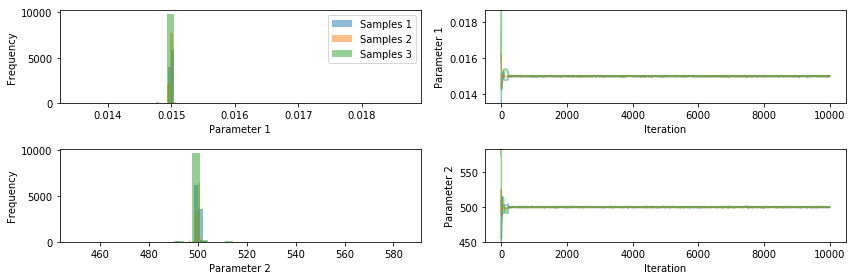

In [15]:
import pints.plot
pints.plot.trace(chains)
plt.show()

Based on this plot, it looks like the three chains become very similar after about 1000 iterations.
To be safe, we throw away the first 2000 samples and continue our analysis with the first chain.

In [16]:
chain = chains[0]
chain = chain[2000:]

We can also look for autocorrelation in the chains, using the [autocorrelation()](http://pints.readthedocs.io/en/latest/diagnostic_plots.html#pints.plot.autocorrelation) method. If everything went well, the samples in the chain should be relatively independent, so the autocorrelation should get quite low when the `lag` on the x-axis increases.

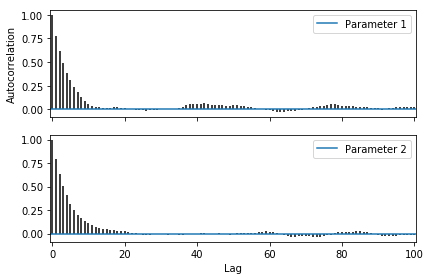

In [17]:
pints.plot.autocorrelation(chain)
plt.show()

Now we can inspect the inferred distribution by plotting histograms:

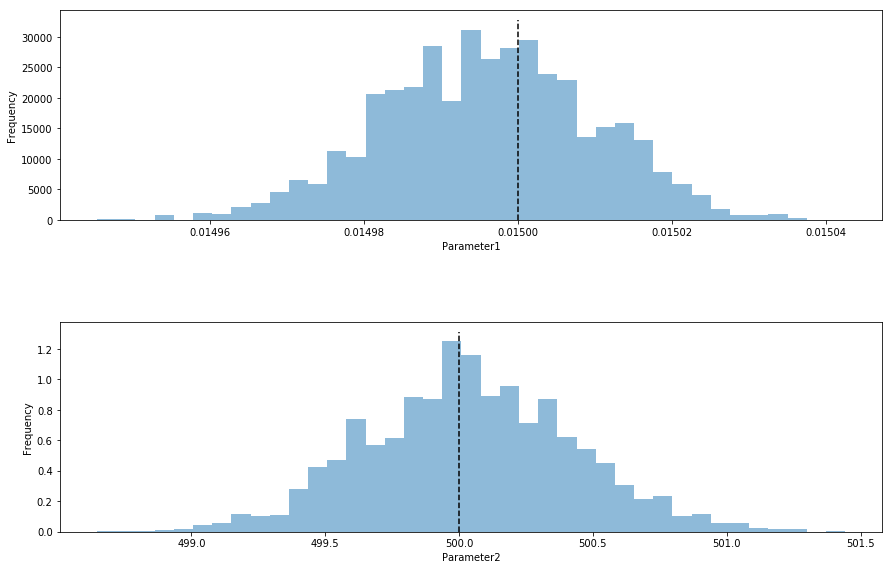

In [18]:
fig, axes = pints.plot.histogram([chain], ref_parameters=true_parameters)

# Show where the sample standard deviation of the generated noise is:
noise_sample_std = np.std(values - org_values)
#axes[-1].axvline(noise_sample_std, color='orange', label='Sample standard deviation of noise')
#axes[-1].legend()

fig.set_size_inches(14, 9)
plt.show()

Here we've analysed each parameter in isolation, but we can also look at correlations between parameters we found using the [pairwise()](http://pints.readthedocs.io/en/latest/diagnostic_plots.html#pints.plot.pairwise) plot.

To speed things up, we'll first apply some _thinning_ to the chain:

In [19]:
thinned_chain = chain[::10]

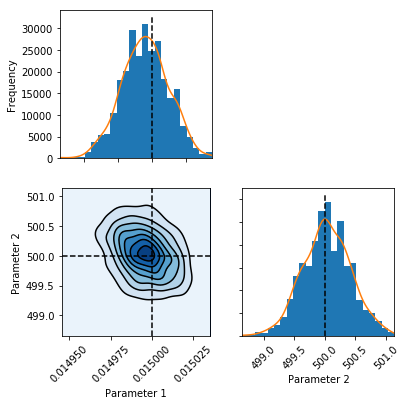

In [20]:
pints.plot.pairwise(thinned_chain, kde=True, ref_parameters=true_parameters)
plt.show()

Finally, we can look at the bit that really matters: The model predictions made from models with the parameters we found (a _posterior predictive check_). Thes can be plotted using the [series()](http://pints.readthedocs.io/en/latest/diagnostic_plots.html#pints.plot.series) method.

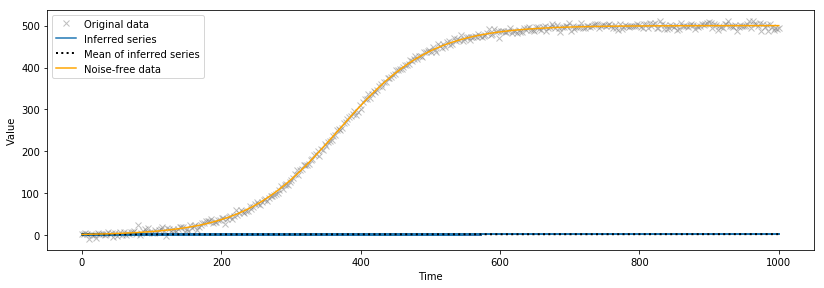

In [21]:
fig, axes = pints.plot.series(chain, problem)

# Customise the plot, and add the original, noise-free data
fig.set_size_inches(12,4.5)
plt.plot(times, org_values, c='orange', label='Noise-free data')
plt.legend()
plt.show()

-1212.0539412070425
[0.75008544 0.99605147]
-1119463.7971120903


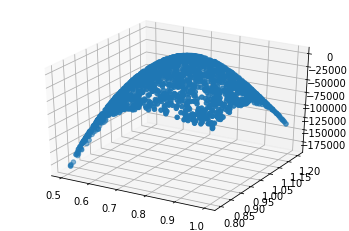

In [22]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 

input_parameters = log_prior.sample(2000)
x = [p[0] for p in input_parameters]
y = [p[1] for p in input_parameters]
input_parameters[:5]

likelihoods = np.apply_along_axis(log_likelihood, 1, input_parameters)
likelihoods[:5]

print(max(likelihoods))
idx = list(likelihoods).index(max(likelihoods))
print(input_parameters[idx])
print(log_likelihood([0.015, 500]))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, list(likelihoods))
plt.show()

In [23]:
print(input_parameters[:5])

[[0.51515097 0.83285164]
 [0.52999392 0.93086261]
 [0.9207089  0.94621822]
 [0.5670427  1.18541182]
 [0.65036363 0.89169373]]


In [24]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(input_parameters, likelihoods, test_size=0.3, random_state=0)
emu = pints.MultiLayerNN(problem, X_train, y_train, input_scaler=MinMaxScaler(), output_scaler=StandardScaler())
emu.set_parameters(layers=6, neurons=64, hidden_activation='relu', activation='linear', learning_rate=0.0001)
hist = emu.fit(epochs=500, batch_size=32, X_val=X_valid, y_val=y_valid, verbose=0)
emu.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                192       
_________________________________________________________________
dense_2 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_3 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_4 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_5 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 82,753
Trainable params: 82,753
Non-trainable params: 0
_________________________________________________________________


In [25]:
emu([0.015, 500])

array([[-68976780.]], dtype=float32)

In [26]:
log_likelihood([0.015, 500])

-1119463.7971120903

dict_keys(['val_loss', 'val_mean_absolute_error', 'loss', 'mean_absolute_error', 'rescaled_mae', 'rescaled_mse', 'val_rescaled_mae', 'val_rescaled_mse'])


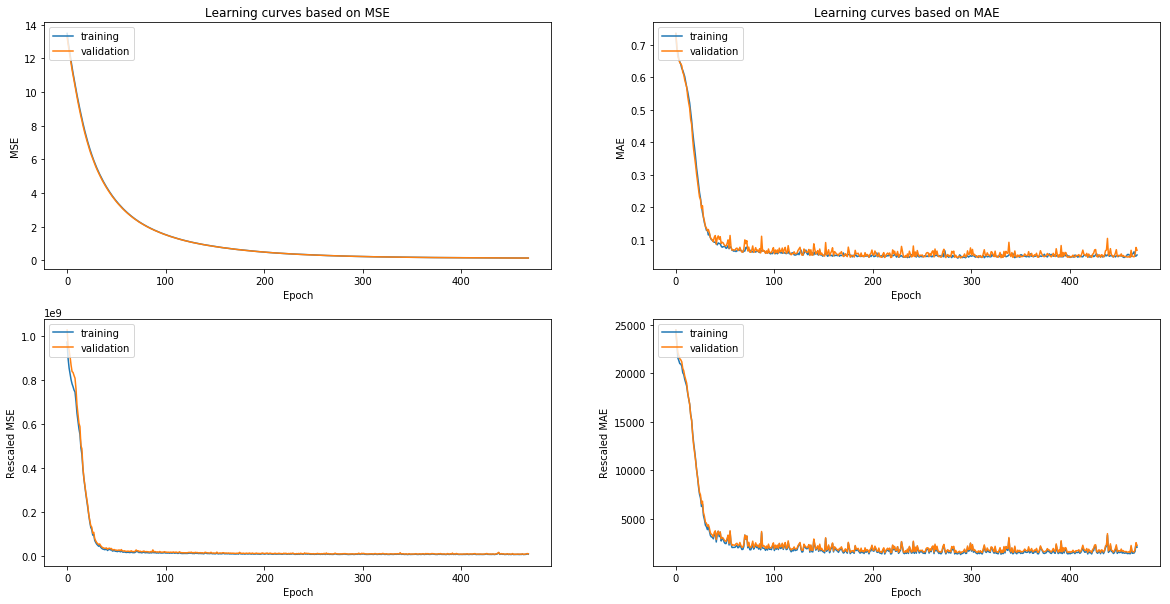

In [27]:
# summarize history for loss
print(hist.history.keys())
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20,10))                 
ax1.title.set_text('Learning curves based on MSE')
ax2.title.set_text('Learning curves based on MAE')

ax1.plot(hist.history['loss'])
ax1.plot(hist.history['val_loss'])
ax1.set_ylabel('MSE')
ax1.set_xlabel('Epoch')
ax1.legend(['training', 'validation'], loc='upper left')

ax2.plot(hist.history['mean_absolute_error'])
ax2.plot(hist.history['val_mean_absolute_error'])
ax2.set_ylabel('MAE')
ax2.set_xlabel('Epoch')
ax2.legend(['training', 'validation'], loc='upper left')

ax3.plot(hist.history['rescaled_mse'])
ax3.plot(hist.history['val_rescaled_mse'])
ax3.set_ylabel('Rescaled MSE')
ax3.set_xlabel('Epoch')
ax3.legend(['training', 'validation'], loc='upper left')

ax4.plot(hist.history['rescaled_mae'])
ax4.plot(hist.history['val_rescaled_mae'])
ax4.set_ylabel('Rescaled MAE')
ax4.set_xlabel('Epoch')
ax4.legend(['training', 'validation'], loc='upper left')

plt.show()

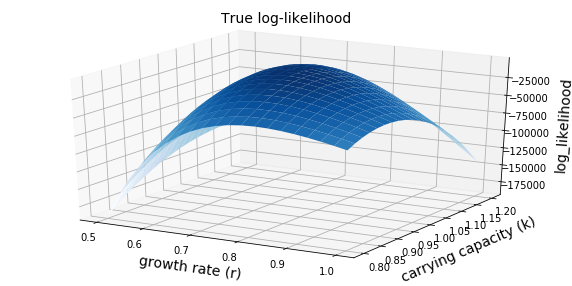

In [28]:
test_splits = 20 # number of splits along each axis
r_grid, k_grid, test_data = pints.generate_grid(bounds.lower(), 
                                                  bounds.upper(), 
                                                  test_splits)

model_prediction = pints.predict_grid(log_likelihood, test_data)

plt.figure(figsize = (10, 5))
ax = pints.plot.surface(r_grid, k_grid, model_prediction, title = "True log-likelihood",
                     x_label = "growth rate (r)",
                     y_label = "carrying capacity (k)")

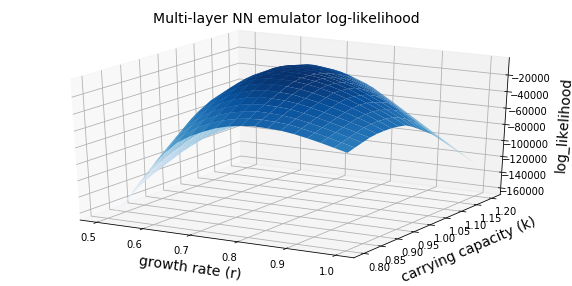

In [29]:
emu_prediction = pints.predict_grid(emu, test_data)

plt.figure(figsize = (10, 5))
ax = pints.plot.surface(r_grid, 
             k_grid, 
             emu_prediction, 
             title = "Multi-layer NN emulator log-likelihood",
             x_label = "growth rate (r)",
             y_label = "carrying capacity (k)")

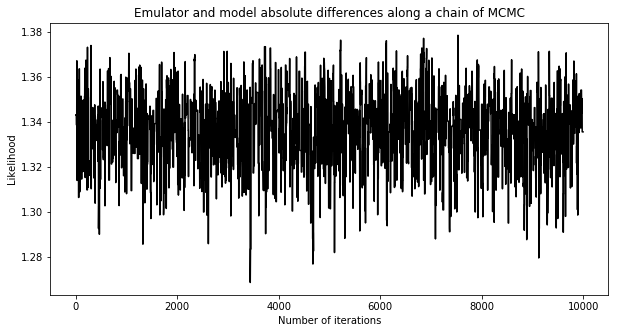

1.3354568130155695

In [30]:
emu_prediction = np.apply_along_axis(emu, 1, chain_rescaled).flatten()
model_prediction = np.apply_along_axis(log_likelihood, 1, chain_rescaled).flatten()
diffs = (np.abs((model_prediction - emu_prediction) / model_prediction))

iters = np.linspace(0, 10000, len(chain_rescaled))
plt.figure(figsize=(10, 5))
plt.title("Emulator and model absolute differences along a chain of MCMC")
plt.xlabel("Number of iterations")
plt.ylabel("Likelihood")
plt.plot(iters, diffs, color = "Black")
plt.show()

diffs[-1]

In [31]:
print(emu_prediction)

[-2802.9336 -2802.9336 -2802.9336 ... -2793.746  -2793.746  -2793.746 ]


In [32]:
log_posterior_emu = pints.LogPosterior(emu, log_prior)

In [33]:
chains_emu = pints.mcmc_sample(log_posterior_emu, 3, xs)

Using Haario-Bardenet adaptive covariance MCMC
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Time m:s
0     3      0         0         0          0:00.0
[0.77068798 0.76493648]
-inf


[0.77710645 1.02912622]
-5661.13671875
accepted


[0.91333018 1.11526961]
-62143.82421875


1     6      0         0.5       0          0:00.0
[0.66246345 0.90122119]
-30367.947265625


[0.91141792 1.19053858]
-91995.7578125


[0.70529829 1.16116081]
-24001.6796875
accepted


2     9      0         0.333     0.333      0:00.0
[0.72539597 0.9633891 ]
-3928.5625
accepted


[0.82317835 1.13653508]
-38783.85546875


[0.7518129  1.21215184]
-inf


3     12     0.25      0.25      0.25       0:00.0
[0.71238395 0.99672479]
-4611.32421875


[0.70885947 1.09270353]
-9050.73046875


[0.79338476 1.21865061]
-inf


[0.74995846 0.97333096]
-2532.8203125
accepted


[0.64467325 0.70155365]
-inf


[0.69077825 1.20592928]
-inf


[0.74630886 1.0619919 ]
-6765.53515625


[0.78677

-17706.998046875


[0.70162101 1.01810413]
-5428.61328125


[0.7926238  0.94439459]
-5529.9140625


[0.79947986 1.02319455]
-7320.375


[0.66667993 1.15438947]
-24819.38671875


[0.84151512 1.00078725]
-10060.048828125


[0.85482203 0.74455717]
-inf


[0.6170218 0.9062257]
-47806.703125


[0.77626881 0.70323371]
-inf


[0.91681247 0.8098987 ]
-39191.37109375


[0.84385714 0.994151  ]
-10074.681640625


[0.69901825 0.99754798]
-6117.58203125


[0.85282724 1.18662492]
-69131.6015625


[0.54835607 0.96446023]
-87622.2109375


[0.74568845 0.96753858]
-2729.21875


[0.75276601 0.93601245]
-6015.5859375


[0.68870507 0.89175273]
-25380.119140625


[0.70744787 0.85178818]
-32533.916015625


[0.81102143 0.88139247]
-17375.970703125


[0.5901173  1.04108387]
-44624.06640625


[0.72825762 0.91951579]
-10713.87109375


[0.79785593 0.91452865]
-10359.751953125


[0.7681599  1.10366809]
-16038.046875


[0.78449875 0.92113836]
-8889.953125


[0.69986703 0.8948474 ]
-21655.544921875


[0.72291558 0.9

[0.7889003  1.05591217]
-10283.02734375


[0.64789778 1.04099748]
-17504.818359375


[0.88102967 0.87029624]
-25565.82421875


[0.82404112 0.97385304]
-6788.96484375


[0.63230023 0.91275242]
-38104.8359375


[0.99927097 0.88934828]
-42873.51171875


[0.77967742 0.94648782]
-4789.87890625


[0.73955784 0.87925169]
-19659.662109375


[0.66009442 0.94956391]
-19267.6484375


[0.71951569 1.05832428]
-5890.875


[0.62424571 0.96080063]
-33468.03125


[0.77290539 1.05804873]
-8447.4375


[0.76043642 0.99314871]
-2749.37890625


[0.50824963 1.00762407]
-112598.203125


[0.68482388 1.07387177]
-9215.169921875


[0.77859066 0.98624174]
-3017.515625


[0.71374063 0.97640147]
-4874.7578125


[0.73102447 0.92924951]
-8169.10546875


[0.69631991 0.95473933]
-8796.91015625


[0.46527971 0.71066321]
-inf


[0.61408795 1.09334103]
-30194.68359375


[0.71897792 1.04595968]
-5140.890625


[0.86137547 0.80507512]
-34804.44140625


[0.75487359 0.94021226]
-5300.32421875


[0.86689269 0.98293197]
-13910.9



[0.762434   0.97292062]
-2367.9453125


[0.76117174 0.97517753]
-2370.328125


[0.76230508 0.97359174]
-2362.68359375


[0.76264473 0.97307796]
-2362.30078125


280   843    0.0996    0.11      0.0996     0:01.1
[0.76360117 0.97324998]
-2380.88671875


[0.7617255  0.97318848]
-2362.99609375


[0.76244001 0.97338099]
-2362.07421875


[0.76293679 0.97329799]
-2361.97265625
accepted


[0.76198382 0.97331308]
-2362.765625


[0.76223887 0.97298821]
-2361.75390625
accepted


[0.76384234 0.97282603]
-2411.6015625


[0.76259729 0.97271165]
-2384.71484375


[0.76224568 0.97280092]
-2371.62890625


[0.76472102 0.97245778]
-2461.74609375


[0.76197596 0.97318397]
-2362.546875
accepted


[0.7622536 0.9731646]
-2362.046875
accepted


[0.76393712 0.9728323 ]
-2414.58984375


[0.76151232 0.9739117 ]
-2364.59375


[0.76229862 0.97332795]
-2362.234375
accepted


[0.76309719 0.97353594]
-2367.46875


[0.76197637 0.97337052]
-2362.87109375
accepted


[0.76198632 0.97331102]
-2362.75390625
accepted


[0

[0.76170259 0.97466096]
-2368.56640625


[0.76236504 0.97327018]
-2362.0234375
accepted


[0.76267216 0.97334394]
-2361.6015625
accepted


[0.76207276 0.97366485]
-2363.20703125
accepted


[0.76210945 0.97352196]
-2362.890625
accepted


[0.76266879 0.9733357 ]
-2361.60546875
accepted


[0.7626029  0.97313814]
-2361.390625
accepted


[0.76209692 0.97348987]
-2362.859375
accepted


[0.76284282 0.97296279]
-2373.82421875


[0.76291142 0.97302884]
-2371.05078125


[0.76261221 0.97334311]
-2361.7109375
accepted


[0.76274058 0.97341159]
-2361.60546875
accepted


[0.76244869 0.97376945]
-2363.55078125


[0.76208386 0.97370244]
-2363.2578125
accepted


[0.76280106 0.97339861]
-2361.94921875
accepted


[0.76313312 0.97313409]
-2370.56640625


[0.76168737 0.97395089]
-2364.359375


[0.76263885 0.97314976]
-2361.3359375
accepted


[0.76251853 0.97330244]
-2361.80078125
accepted


[0.76205537 0.9737912 ]
-2363.44140625
accepted


[0.76254821 0.9730258 ]
-2363.6171875


[0.7624657  0.97336719]
-23

[0.76213855 0.97320446]
-2362.30859375


[0.76335853 0.97331752]
-2368.84375


460   1383   0.21      0.213     0.234      0:01.8
[0.76404259 0.97379884]
-2382.44140625


[0.76243561 0.97338806]
-2362.09765625
accepted


[0.76379278 0.97253238]
-2425.265625


[0.76340613 0.97334227]
-2369.20703125


[0.76341151 0.97328731]
-2372.2890625


[0.76359451 0.97297378]
-2395.15625


[0.76364899 0.97353009]
-2373.7890625


[0.76204239 0.9735564 ]
-2363.078125


[0.76399813 0.97248292]
-2435.06640625


[0.76206389 0.97288874]
-2362.19921875


[0.76273296 0.97317937]
-2361.21875
accepted


[0.76191926 0.97378911]
-2363.69140625


[0.76353513 0.97393702]
-2378.6875


[0.763208   0.97269475]
-2398.63671875


[0.76241213 0.97360304]
-2362.5
accepted


[0.76281299 0.97311388]
-2363.54296875
accepted


[0.76201127 0.97327288]
-2362.64453125


[0.76235536 0.97390954]
-2364.61328125
accepted


[0.76219578 0.97276047]
-2373.17578125


[0.76344815 0.97335738]
-2369.8984375


[0.76234917 0.97421447]
-2369

[0.76292514 0.97308396]
-2367.8125


[0.76139452 0.97302352]
-2363.3046875


[0.7639613  0.97358515]
-2378.2421875


[0.76299242 0.9721839 ]
-2426.75


[0.76079881 0.97309812]
-2364.46484375


[0.76248588 0.9741775 ]
-2370.22265625


[0.76298971 0.97320047]
-2362.05078125
accepted


[0.76195685 0.97296024]
-2362.2109375
accepted


[0.76077613 0.97327052]
-2364.7890625


[0.76212551 0.97375396]
-2363.25390625


[0.76133399 0.97324917]
-2363.78125


[0.76336418 0.97387297]
-2375.73046875


[0.76112076 0.97452895]
-2366.3359375


[0.7618767  0.97297835]
-2362.39453125
accepted


[0.76110046 0.9734724 ]
-2364.58203125
accepted


[0.76454487 0.97374764]
-2387.875


[0.76099382 0.97238172]
-2373.453125


[0.76023943 0.97279096]
-2370.171875


[0.76392029 0.9730583 ]
-2402.140625


[0.76261707 0.97318223]
-2361.4296875
accepted


[0.76262559 0.97417155]
-2371.75390625


[0.76086188 0.9723006 ]
-2378.15234375


[0.76208848 0.97319858]
-2362.38671875


[0.75889283 0.9728419 ]
-2387.50390625


5

[0.76213939 0.97303669]
-2362.015625
accepted


[0.76207264 0.97258178]
-2382.01171875


[0.76531637 0.97323738]
-2441.71484375


[0.76187683 0.9732652 ]
-2362.86328125


[0.76467336 0.97416138]
-2396.45703125


[0.76311318 0.97322289]
-2365.19921875


[0.76171014 0.9736349 ]
-2363.78125
accepted


[0.76028258 0.97284211]
-2369.078125


[0.76292897 0.9727161 ]
-2391.40234375


[0.76020504 0.97411108]
-2367.22265625


[0.76267113 0.97378944]
-2366.42578125


[0.76292884 0.97332399]
-2362.296875
accepted


[0.76179229 0.97337284]
-2363.1953125
accepted


[0.76215238 0.97308279]
-2362.0703125
accepted


[0.76533225 0.97297447]
-2456.07421875


[0.76257166 0.9726094 ]
-2390.71484375


[0.76534419 0.97322402]
-2443.3984375


[0.76174832 0.97324651]
-2363.0625


[0.7614172  0.97336376]
-2363.8359375


[0.76144929 0.97230164]
-2386.8125


[0.75945249 0.97298894]
-2378.59765625


[0.76258412 0.97380556]
-2365.6640625


[0.76116564 0.97316619]
-2363.9453125


[0.76164527 0.97290382]
-2362.66796

-2362.85546875


[0.76304961 0.97303386]
-2373.62890625


740   2223   0.227     0.217274  0.231      0:03.0
[0.76147284 0.97392645]
-2364.69921875
accepted


[0.76201769 0.97286895]
-2362.49609375
accepted


[0.76248259 0.9736688 ]
-2362.49609375
accepted


[0.7614817  0.97419247]
-2365.12890625


[0.76080545 0.97229032]
-2378.4140625


[0.76283652 0.9737499 ]
-2367.73046875


[0.76157351 0.97404798]
-2364.71875
accepted


[0.76098027 0.97287294]
-2363.76953125
accepted


[0.76262435 0.97432747]
-2374.125


[0.76151737 0.97378656]
-2364.37890625
accepted


[0.76079479 0.97268928]
-2364.578125
accepted


[0.76445315 0.97373084]
-2386.1484375


[0.76186534 0.97253311]
-2380.76953125


[0.76010413 0.97305043]
-2369.31640625


[0.76290903 0.97363038]
-2366.7421875


[0.76361454 0.97251643]
-2419.86328125


[0.75917628 0.97245117]
-2387.71484375


[0.76469531 0.97512638]
-2418.25390625


[0.76147509 0.97386168]
-2364.57421875
accepted


[0.76057221 0.97229576]
-2375.921875


[0.76360722 0.

[0.76323243 0.97552126]
-2400.3046875


[0.7623879  0.97409215]
-2367.78515625


[0.76250033 0.97301996]
-2362.97265625
accepted


[0.76242276 0.97370227]
-2362.65625
accepted


[0.76300908 0.97375817]
-2369.86328125


[0.76147629 0.97153119]
-2440.66015625


[0.76316856 0.97401099]
-2375.5625


[0.7622254  0.97362256]
-2362.859375
accepted


[0.76222949 0.97207558]
-2417.65625


[0.76262676 0.97377936]
-2365.7578125


[0.7620994  0.97299418]
-2362.0078125
accepted


[0.76235289 0.9729355 ]
-2365.2890625


[0.76162055 0.97344804]
-2363.62109375
accepted


[0.7619302  0.97269898]
-2371.51953125


[0.76347368 0.97367719]
-2374.0


[0.76199663 0.97298019]
-2362.171875
accepted


[0.76146502 0.97206792]
-2402.2421875


[0.76197475 0.97402875]
-2363.98828125
accepted


[0.76224538 0.97324006]
-2362.171875
accepted


[0.76324493 0.97449425]
-2383.84765625


[0.76232414 0.97394995]
-2364.87109375


[0.76255852 0.97356812]
-2362.18359375
accepted


[0.76253574 0.97236471]
-2405.61328125


840 

-2389.56640625


[0.76262196 0.97440383]
-2375.265625


[0.76181397 0.97308648]
-2362.67578125
accepted


[0.762833   0.97368694]
-2366.7265625


[0.76230582 0.97425446]
-2369.30859375


[0.76160896 0.97333002]
-2363.44140625


[0.76023562 0.97178605]
-2410.69140625


[0.7596114  0.97344712]
-2371.828125


[0.76124687 0.97320625]
-2363.86328125


[0.75985196 0.97235762]
-2379.71484375


[0.76186121 0.97530338]
-2380.21875


[0.76244984 0.97306452]
-2361.5234375
accepted


[0.76068482 0.97284572]
-2364.74609375
accepted


[0.76136344 0.97411269]
-2365.1953125


[0.76177178 0.97248041]
-2382.1640625


[0.7611949  0.97292336]
-2363.48046875
accepted


[0.76237453 0.97373134]
-2362.78515625
accepted


[0.76228949 0.97308631]
-2361.84375
accepted


[0.76181167 0.9737807 ]
-2363.86328125


[0.76128802 0.97356014]
-2364.390625
accepted


[0.76231008 0.97306837]
-2361.7734375
accepted


[0.76037272 0.97228812]
-2374.7109375


[0.7606334  0.97311045]
-2364.77734375


[0.76240675 0.97320746]
-23

[0.76194813 0.97278657]
-2366.2890625


[0.76414785 0.97279604]
-2423.890625


[0.75953547 0.97363426]
-2370.9375


[0.763257   0.97367403]
-2371.44921875


[0.76281779 0.97292722]
-2375.57421875


[0.76061041 0.97327571]
-2365.1015625


[0.76134719 0.97497153]
-2369.19921875


[0.7637299  0.97545584]
-2407.953125


[0.75971374 0.97359559]
-2368.96875


[0.76236332 0.97388758]
-2364.375
accepted


[0.76297899 0.97305313]
-2370.91796875


[0.76364273 0.97358355]
-2374.5078125


[0.76060152 0.97441194]
-2367.03515625


[0.76405389 0.97400948]
-2385.78515625


[0.76046047 0.97406483]
-2366.6953125


1020  3063   0.237     0.236     0.236      0:04.1
[0.76201307 0.97323253]
-2362.58203125
accepted


[0.76248612 0.9729574 ]
-2366.68359375


[0.76103283 0.97247561]
-2367.58984375


[0.76427083 0.97444751]
-2395.45703125


[0.76213859 0.97298661]
-2361.93359375
accepted


[0.76254087 0.97317856]
-2361.5546875
accepted


[0.76118506 0.97256136]
-2364.66015625


[0.76368195 0.97357665]
-2374.86

[0.76139305 0.97466546]
-2366.078125


[0.76064031 0.97198508]
-2399.5625


[0.76119289 0.97290468]
-2363.45703125
accepted


[0.76237475 0.9751175 ]
-2383.31640625


[0.76150743 0.97280136]
-2362.73046875
accepted


[0.75996119 0.97278868]
-2373.87890625


[0.76077818 0.97221291]
-2383.90234375


[0.76068049 0.97293452]
-2364.44140625


[0.75975563 0.97382263]
-2367.625


[0.76349013 0.97397228]
-2378.69140625


[0.76152778 0.97337526]
-2363.66796875
accepted


[0.76118784 0.97260439]
-2362.953125
accepted


[0.76033883 0.97256613]
-2371.1328125


[0.76092314 0.97134948]
-2449.203125


[0.76448583 0.97302731]
-2423.609375


[0.76105972 0.97428003]
-2366.015625
accepted


[0.76204028 0.97350234]
-2362.984375
accepted


[0.76138807 0.97248545]
-2373.78125


[0.75980612 0.9758808 ]
-2370.91796875


[0.76300101 0.9745903 ]
-2382.50390625


[0.76087051 0.97214824]
-2389.51171875


[0.75935127 0.97496365]
-2370.1640625


[0.76428572 0.97373167]
-2384.21875


[0.76090885 0.97329342]
-2364.61

-2456.5


[0.75851015 0.97199283]
-2401.19921875


[0.76362334 0.97384806]
-2378.34765625


[0.76504616 0.97355228]
-2415.72265625


[0.75914067 0.9726628 ]
-2386.02734375


[0.76056812 0.97196554]
-2400.35546875


[0.76444774 0.97378873]
-2386.97265625


[0.7632056  0.97284376]
-2389.05859375


[0.76203743 0.97380487]
-2363.49609375
accepted


[0.76275904 0.97314816]
-2361.12890625
accepted


[0.76161763 0.9727273 ]
-2363.1328125
accepted


[0.76158506 0.97374234]
-2364.1796875


[0.7620423  0.97455627]
-2370.87890625


[0.76188576 0.97177535]
-2429.62109375


[0.76270685 0.97400837]
-2370.19140625


[0.76287495 0.97250968]
-2403.46484375


[0.76122799 0.97286876]
-2363.32421875
accepted


[0.76276131 0.97322643]
-2361.25390625
accepted


[0.76138089 0.97443789]
-2365.7265625


[0.76021071 0.97313987]
-2367.015625


[0.76511534 0.97465575]
-2415.47265625


[0.76130648 0.973718  ]
-2364.62890625


[0.760942   0.97241265]
-2370.5625


[0.76213659 0.97205867]
-2416.78125


[0.76656968 0.

[0.76500654 0.97356371]
-2413.71875


[0.76475148 0.97389038]
-2392.04296875


[0.76226567 0.97288636]
-2366.58984375


[0.76179929 0.97322808]
-2362.9453125
accepted


[0.76159732 0.97304899]
-2362.99609375
accepted


[0.76150901 0.97435814]
-2365.35546875


[0.76406612 0.97370523]
-2381.2890625


[0.76161117 0.97195101]
-2412.6328125


[0.76117448 0.97231855]
-2380.5546875


[0.76173775 0.97388776]
-2364.1640625


[0.76114165 0.97266685]
-2363.13671875
accepted


[0.76114741 0.97432391]
-2365.9375


[0.762109   0.97326823]
-2362.4609375
accepted


[0.76103623 0.97181041]
-2416.04296875


[0.76129228 0.97362198]
-2364.5
accepted


[0.76135392 0.97201284]
-2404.328125


[0.75886383 0.97246997]
-2391.6640625


[0.76198981 0.97353308]
-2363.1328125
accepted


[0.7613778  0.97282749]
-2363.00390625
accepted


[0.76044644 0.972436  ]
-2371.04296875


[0.76187059 0.97197541]
-2416.51171875


1300  3903   0.231     0.233     0.231      0:05.2
[0.76163626 0.97277984]
-2362.46484375
accepted



-2365.61328125
accepted


[0.76368363 0.97382768]
-2378.734375


[0.76346423 0.97332026]
-2372.41796875


[0.76131973 0.97281658]
-2363.07421875
accepted


[0.76187083 0.97396333]
-2364.0546875


[0.76328497 0.9724346 ]
-2416.875


[0.75938301 0.97221102]
-2387.41015625


[0.76298087 0.97321445]
-2361.22265625
accepted


[0.76360504 0.97380281]
-2377.44921875


[0.76193646 0.97273621]
-2369.28125


[0.76243896 0.97268277]
-2383.23828125


[0.76215181 0.97345999]
-2362.72265625


[0.76031245 0.97312184]
-2366.35546875


[0.76344647 0.97295642]
-2390.88671875


[0.76313077 0.97348983]
-2367.15625


[0.76161624 0.97281492]
-2362.5546875
accepted


[0.76407337 0.97346478]
-2386.1796875


[0.76245854 0.97410201]
-2368.76171875


[0.76333987 0.97255632]
-2410.25390625


[0.76317403 0.97286332]
-2387.140625


[0.76191104 0.97342266]
-2363.078125


[0.76273372 0.97228449]
-2414.890625


[0.76293747 0.97392526]
-2371.58984375


[0.76020695 0.97350146]
-2366.1796875


[0.76104796 0.9722899 ]
-23

[0.7608363 0.9726993]
-2364.23046875
accepted


[0.76260799 0.97338882]
-2361.8046875
accepted


[0.76272076 0.97335912]
-2361.546875
accepted


1480  4443   0.231     0.23      0.23       0:06.0
[0.75913911 0.97249544]
-2387.7578125


[0.7640171  0.97353805]
-2380.3671875


[0.76481352 0.97370132]
-2399.73828125


[0.7606308 0.9723137]
-2375.109375


[0.76204303 0.97388629]
-2363.6171875


[0.76183528 0.97297856]
-2362.45703125


[0.76123237 0.9721668 ]
-2391.87890625


[0.76116526 0.97322712]
-2364.0390625


[0.75974186 0.97276086]
-2377.07421875


[0.76011721 0.97316283]
-2368.01171875


[0.76295226 0.97304163]
-2371.0859375


[0.76239306 0.97354567]
-2362.4453125


[0.7595082 0.9709329]
-2467.4453125


[0.76301581 0.97350778]
-2366.11328125


[0.76414989 0.97321896]
-2401.76953125


[0.76023719 0.97208644]
-2388.44140625


[0.76382055 0.97377372]
-2379.484375


[0.76031712 0.97297264]
-2367.28515625


[0.75978939 0.97273032]
-2376.76171875


[0.76341889 0.97340897]
-2369.2578125




-2361.68359375
accepted


[0.76182033 0.97352089]
-2363.3984375


[0.76157025 0.9751702 ]
-2374.8203125


[0.76106497 0.97323096]
-2364.21875


[0.76216481 0.97370777]
-2363.10546875
accepted


[0.76485342 0.97503589]
-2419.125


[0.76330542 0.97320861]
-2372.69140625


[0.76291896 0.97398311]
-2372.265625


[0.76341565 0.97366966]
-2373.203125


[0.76232102 0.97348159]
-2362.453125


[0.76300827 0.97412848]
-2375.51171875


[0.76165872 0.97362034]
-2363.84375
accepted


[0.76287835 0.97341356]
-2363.078125


[0.76268419 0.97394403]
-2368.953125


[0.76322771 0.97328457]
-2365.98828125
accepted


[0.76166198 0.97348897]
-2363.63671875


[0.76253497 0.97429401]
-2372.5625


[0.76307238 0.9724705 ]
-2410.125


[0.76354541 0.9740928 ]
-2381.19921875


[0.76177614 0.97321246]
-2362.95703125
accepted


[0.76478162 0.97353639]
-2407.265625


[0.7625745  0.97357663]
-2362.17578125


[0.76375987 0.97263724]
-2418.625


1580  4743   0.235     0.226439  0.228969   0:06.4
[0.76255158 0.97245486]


[0.76155219 0.97437862]
-2365.31640625


[0.7614854  0.97435329]
-2365.38671875
accepted


[0.76259478 0.9732787 ]
-2361.63671875
accepted


[0.76002841 0.97294857]
-2371.3671875


[0.76141421 0.97462309]
-2365.984375


[0.76302403 0.97303144]
-2373.25


[0.76271569 0.97367469]
-2365.18359375


[0.7630082  0.97499809]
-2388.82421875


[0.76231281 0.97314877]
-2361.91796875
accepted


[0.75987541 0.97269156]
-2376.0078125


[0.76142557 0.97470791]
-2366.09765625
accepted


[0.76206225 0.97391587]
-2363.640625
accepted


[0.75884843 0.9730351 ]
-2386.1328125


[0.76188884 0.97429987]
-2365.1796875
accepted


[0.76195022 0.97364731]
-2363.3828125
accepted


[0.75953055 0.97329922]
-2374.3984375


[0.76177679 0.97451917]
-2367.23828125


[0.76392366 0.97471219]
-2395.03125


[0.75972922 0.97365085]
-2368.4765625


[0.76273865 0.97362971]
-2364.7578125
accepted


[0.76349357 0.97395283]
-2378.44921875


[0.76282322 0.97224686]
-2419.17578125


[0.76292713 0.97279041]
-2386.62109375


[0.760


[0.76292171 0.97293647]
-2377.16015625


[0.76181722 0.97249945]
-2381.89453125


[0.7614748  0.97425878]
-2365.25


[0.76193194 0.97357704]
-2363.29296875


[0.76013489 0.97363124]
-2366.52734375


[0.76187905 0.97359429]
-2363.41015625


[0.76267459 0.97328864]
-2361.50390625
accepted


[0.76326944 0.973648  ]
-2371.1875


[0.76341607 0.97276756]
-2399.73046875


[0.76234615 0.97416061]
-2368.3515625


[0.75943811 0.97074112]
-2481.0390625


[0.76154965 0.97340547]
-2363.671875
accepted


[0.76281772 0.97251051]
-2402.19921875


[0.76329491 0.97312595]
-2376.6640625


[0.76138245 0.97373775]
-2364.51953125
accepted


[0.76251389 0.97279613]
-2377.58203125


[0.76060808 0.97387788]
-2366.11328125


[0.76142188 0.97421621]
-2365.265625


[0.7613894  0.97347693]
-2364.08203125


[0.76169279 0.97409862]
-2364.60546875


[0.76262429 0.97420608]
-2372.265625


[0.7628755  0.97440755]
-2378.2578125


[0.76258094 0.97291606]
-2371.31640625


[0.76025934 0.97388738]
-2366.73828125


[0.76344

-2406.2109375


[0.76359871 0.97378553]
-2377.09765625


[0.76360059 0.97267102]
-2411.2578125


[0.76317087 0.97275048]
-2394.2890625


[0.76011208 0.97251422]
-2374.671875


[0.76147161 0.97300095]
-2363.12890625


[0.76160426 0.97348706]
-2363.72265625


[0.76141791 0.97398948]
-2364.8984375


[0.76421896 0.97351062]
-2388.87890625


[0.76336853 0.97296765]
-2387.5546875


[0.75775661 0.97173606]
-2413.80859375


[0.76390798 0.97307225]
-2400.98828125


[0.76245207 0.97311896]
-2361.61328125
accepted


[0.76138751 0.97450702]
-2365.83203125


[0.76297597 0.97318245]
-2362.59375


[0.76346679 0.97325265]
-2376.03515625


[0.75996171 0.97362752]
-2366.90234375


[0.76287769 0.97394017]
-2371.12890625


[0.76289568 0.9734351 ]
-2363.6015625
accepted


[0.76203258 0.97301329]
-2362.1640625
accepted


[0.76289174 0.97331525]
-2361.73828125


[0.76209431 0.97452556]
-2371.02734375


[0.760224   0.97235862]
-2374.7734375


1860  5583   0.222     0.224     0.233      0:07.5
[0.76256445 0.97

[0.76213945 0.97410988]
-2365.171875


[0.76167332 0.97334123]
-2363.3515625


[0.76313739 0.97431212]
-2379.8125


[0.76251601 0.97397595]
-2367.484375


[0.76562294 0.97306631]
-2462.46875


[0.76263503 0.97454138]
-2377.51171875


[0.76350227 0.97368601]
-2374.46484375


[0.76403408 0.97360452]
-2379.37109375


[0.76283853 0.97330631]
-2361.25
accepted


[0.76257861 0.97415326]
-2370.9296875


[0.76400416 0.97320974]
-2397.13671875


[0.76377174 0.97366529]
-2377.2734375


[0.76205664 0.97281211]
-2366.9453125


[0.76023311 0.97274867]
-2370.68359375


[0.76394834 0.97423684]
-2388.04296875


[0.76194358 0.97370568]
-2363.49609375


[0.76128942 0.97496281]
-2368.390625


[0.76203766 0.97360381]
-2363.15625


[0.76394834 0.97391213]
-2383.0859375


[0.76206404 0.97341158]
-2362.78515625
accepted


[0.76471477 0.97352861]
-2405.3203125


[0.76277767 0.97302984]
-2368.18359375


[0.76122716 0.97360319]
-2364.57421875


[0.76018464 0.97296189]
-2369.1640625


[0.76297708 0.97384799]
-23

[0.76069012 0.97262749]
-2365.84765625


[0.7617927  0.97385496]
-2364.015625


[0.76292814 0.97351058]
-2365.140625


[0.76324194 0.97304067]
-2379.28515625


[0.76243264 0.97351202]
-2362.31640625


[0.76021415 0.97314134]
-2366.9921875


[0.76440929 0.97273022]
-2436.515625


[0.7625517  0.97321335]
-2361.59375
accepted


[0.76302465 0.97294794]
-2378.6015625


2040  6123   0.229     0.225     0.232      0:08.2
[0.76458611 0.97326875]
-2414.453125


[0.76161375 0.97231659]
-2389.32421875


[0.76211143 0.97306906]
-2362.11328125
accepted


[0.7630863  0.97314494]
-2368.33984375


[0.76224324 0.97367866]
-2362.93359375
accepted


[0.76211403 0.97322554]
-2362.3828125


[0.76226201 0.97367615]
-2362.8984375
accepted


[0.76265633 0.97297544]
-2369.10546875


[0.76174194 0.97201376]
-2411.359375


[0.76189814 0.97379561]
-2363.73828125


[0.76191984 0.97397944]
-2364.0
accepted


[0.76162322 0.97269882]
-2365.09375


[0.7636423  0.97395618]
-2380.21875


[0.76145811 0.97500432]
-2370.98

-2367.03125


[0.76028758 0.9727282 ]
-2370.1796875


[0.7631469  0.97458292]
-2384.0703125


[0.75985992 0.97219465]
-2381.26171875


[0.76201511 0.97285662]
-2363.234375


[0.76143347 0.97340955]
-2363.89453125


[0.76195861 0.97316196]
-2362.546875
accepted


[0.76224858 0.97280075]
-2371.70703125


[0.76445527 0.97283955]
-2432.3984375


[0.76264538 0.97382042]
-2366.59375


[0.76220849 0.97229923]
-2402.91015625


[0.7614452  0.97406917]
-2364.984375


[0.76240196 0.97400578]
-2366.62109375


[0.76312927 0.97314416]
-2369.90234375


[0.76397146 0.97321543]
-2395.67578125


[0.76388201 0.97262524]
-2423.5234375


[0.76148363 0.97345771]
-2363.8828125
accepted


[0.76416449 0.97346672]
-2389.28125


[0.76185697 0.97439513]
-2366.27734375


[0.76137852 0.97372515]
-2364.50390625
accepted


[0.76323029 0.97447626]
-2383.3984375


[0.76091892 0.97293448]
-2363.9765625


[0.76206916 0.97431212]
-2367.453125


[0.76427809 0.9723119 ]
-2453.859375


[0.76232764 0.97372982]
-2362.86328125


-2367.82421875


[0.76195678 0.97428058]
-2365.671875


[0.76317941 0.9720882 ]
-2436.80859375


[0.76226268 0.97266061]
-2380.9453125


[0.76033028 0.97460837]
-2367.84375


[0.7617493  0.97181104]
-2424.46875


[0.75980054 0.97214646]
-2382.53515625


[0.76148204 0.97343162]
-2363.83984375
accepted


[0.76297507 0.97395339]
-2372.453125


[0.76225515 0.97389957]
-2363.3125
accepted


[0.76141322 0.97304332]
-2363.30078125
accepted


[0.76121934 0.97318034]
-2363.875


[0.76087054 0.97409492]
-2366.0234375


[0.76422252 0.97301534]
-2415.00390625


[0.76237826 0.97324535]
-2361.953125


[0.76119933 0.97361779]
-2364.6484375


[0.7592597  0.97384256]
-2372.45703125


[0.76374889 0.97346038]
-2375.03125


[0.76250696 0.97451693]
-2375.6640625


[0.76118474 0.97193153]
-2408.38671875


[0.76093337 0.97275461]
-2363.6484375


[0.76179609 0.97308391]
-2362.71484375
accepted


[0.76234498 0.97239   ]
-2399.984375


[0.76176279 0.97369612]
-2363.79296875


[0.76248611 0.97399376]
-2367.42187

[0.76217654 0.97381338]
-2363.27734375


[0.76275685 0.9722774 ]
-2415.82421875


[0.76024498 0.97266413]
-2371.39453125


[0.76172233 0.97407462]
-2364.50390625


[0.76115838 0.97290848]
-2363.515625


[0.75827201 0.97203007]
-2403.984375


[0.76290134 0.97374153]
-2368.359375


[0.76204196 0.97355375]
-2363.08203125


[0.76245292 0.97444102]
-2373.8671875


[0.76320254 0.97338693]
-2366.4140625


[0.76287562 0.97301257]
-2371.34765625


[0.76164514 0.97219023]
-2398.046875


[0.76219798 0.97340096]
-2362.5234375
accepted


[0.76312537 0.97343782]
-2366.30859375


[0.76103147 0.97283047]
-2363.6015625


2320  6963   0.23352   0.229     0.233      0:09.4
[0.76027097 0.972775  ]
-2369.921875


[0.76156519 0.97434478]
-2365.23046875


[0.76135293 0.97268601]
-2362.80859375
accepted


[0.76162952 0.9737885 ]
-2364.1796875


[0.76288671 0.97414671]
-2374.390625


[0.76122719 0.97333019]
-2364.10546875


[0.76093155 0.97268436]
-2363.60546875


[0.76125429 0.97410193]
-2365.37890625


[0.76



[0.76093763 0.97320205]
-2364.40234375
accepted


[0.76198135 0.97293604]
-2362.12890625
accepted


[0.76361636 0.97309379]
-2389.625


[0.7615985  0.97357725]
-2363.88671875
accepted


[0.76164552 0.97305054]
-2362.91015625


[0.76286227 0.97447482]
-2379.125


[0.76314884 0.97375451]
-2371.4296875


[0.76328441 0.97335701]
-2366.921875


[0.76252593 0.97339634]
-2361.96484375
accepted


[0.7611917  0.97249448]
-2369.0703125


[0.76409385 0.97389622]
-2384.53515625


[0.76193347 0.97387432]
-2363.8046875


[0.76173325 0.97397518]
-2364.32421875
accepted


[0.76353396 0.97319597]
-2381.3828125


[0.76187181 0.97384094]
-2363.84765625


[0.76081427 0.97362757]
-2365.33984375
accepted


[0.76080542 0.97284883]
-2364.03515625


[0.76308761 0.97338992]
-2365.140625


[0.7631351  0.97392579]
-2373.88671875


[0.76246814 0.97292434]
-2368.4140625


[0.76126036 0.97274934]
-2363.0703125


[0.7613782  0.97411945]
-2365.18359375
accepted


[0.76052104 0.97282659]
-2366.078125


[0.76235604 0.



2500  7503   0.236     0.226     0.237505   0:10.1
[0.76274424 0.97312779]
-2361.21875
accepted


[0.76054877 0.97525537]
-2368.55078125


[0.76284558 0.97377801]
-2368.28125


[0.76463027 0.97280888]
-2440.140625


[0.76238051 0.97467633]
-2376.63671875


[0.76368002 0.97236116]
-2430.30859375


[0.762621   0.97378493]
-2365.78125


[0.76021826 0.97406518]
-2367.1328125
accepted


[0.76243348 0.97334074]
-2362.02734375
accepted


[0.76266697 0.97240085]
-2406.0546875


[0.76171576 0.97353404]
-2363.60546875
accepted


[0.76176032 0.97287553]
-2362.41796875
accepted


[0.76435143 0.97400953]
-2389.2421875


[0.7597776  0.97287832]
-2375.40234375


[0.76041948 0.97291662]
-2366.49609375


[0.76513282 0.97281526]
-2457.42578125


[0.76197581 0.97332798]
-2362.80078125
accepted


[0.7624919  0.97188422]
-2435.390625


[0.76248489 0.97359237]
-2362.359375


[0.76430136 0.97429431]
-2393.01953125


[0.76185445 0.9718171 ]
-2426.29296875


[0.76165374 0.97235607]
-2387.62890625


[0.765436

[0.76399874 0.97389719]
-2383.4375


[0.76268706 0.97334905]
-2361.58984375
accepted


[0.76341596 0.97281304]
-2397.32421875


[0.7619718  0.97250244]
-2384.94140625


[0.76201919 0.97303004]
-2362.21875


[0.76256666 0.97286226]
-2374.453125


[0.7625087  0.97398828]
-2367.58203125


[0.76183103 0.97392459]
-2364.05859375


[0.763852   0.97265497]
-2420.921875


[0.76313354 0.97385384]
-2372.7734375


[0.76320652 0.9727665 ]
-2394.015625


[0.7621315  0.97317561]
-2362.26953125
accepted


[0.7615342  0.97335123]
-2363.609375


[0.76231377 0.97276603]
-2375.2890625


[0.76147893 0.97402214]
-2364.83984375


[0.76516034 0.97449068]
-2412.64453125


[0.76256136 0.97372028]
-2364.1015625


[0.76088895 0.97345267]
-2364.90625


[0.76497461 0.97388104]
-2397.2265625


[0.76166295 0.97315568]
-2363.0625


[0.7624787  0.97246937]
-2397.70703125


2600  7803   0.233     0.226     0.235      0:10.5
[0.76505772 0.97477997]
-2417.18359375


[0.76347125 0.97304231]
-2387.23828125


[0.76145336 0.

-2372.609375


[0.76312613 0.97329697]
-2364.16015625


[0.76258123 0.97357206]
-2362.16015625
accepted


[0.76217124 0.97410294]
-2365.44921875


[0.76321082 0.97264548]
-2401.84375


[0.7625229  0.97389248]
-2366.30078125


[0.76162402 0.97316958]
-2363.14453125


[0.7620473  0.97230194]
-2399.37109375


[0.76282557 0.97367209]
-2366.40625


[0.76205246 0.97535245]
-2383.19140625


[0.7612626  0.97348723]
-2364.32421875


[0.76269177 0.97369598]
-2365.23046875


[0.76055866 0.97303166]
-2364.93359375


[0.76347385 0.97328359]
-2374.66796875


[0.76272712 0.97317147]
-2361.21875
accepted


[0.76501095 0.97434558]
-2406.69921875


[0.76320641 0.97361565]
-2369.96875


[0.76328091 0.97381076]
-2373.81640625


[0.76276419 0.97284185]
-2379.90625


[0.7610436  0.97334307]
-2364.44140625


[0.76374735 0.97325359]
-2385.83984375


[0.76285638 0.97371325]
-2367.4140625


[0.76298752 0.97351999]
-2365.96484375


[0.76160915 0.97387786]
-2364.375


[0.76307342 0.97301229]
-2375.51171875


[0.7

[0.76223764 0.97290881]
-2364.5703125


[0.76023741 0.97283472]
-2369.74609375


[0.76119461 0.97404941]
-2365.390625


[0.7633732  0.97347812]
-2369.77734375


[0.76033379 0.97246286]
-2372.24609375


[0.76279884 0.9734093 ]
-2362.1015625
accepted


[0.76363583 0.97325129]
-2382.03515625


[0.76180188 0.97292025]
-2362.421875
accepted


[0.76337515 0.97416609]
-2380.3359375


[0.76387748 0.97321193]
-2392.58984375


[0.76241178 0.97271235]
-2380.78515625


[0.76376019 0.97384841]
-2379.921875


[0.76112779 0.9736716 ]
-2364.87109375


[0.76228625 0.97312134]
-2361.90625
accepted


[0.76446241 0.97397033]
-2389.91796875


[0.7620934  0.97295301]
-2361.9609375
accepted


[0.7650216  0.97255977]
-2466.9375


[0.76247057 0.97401325]
-2367.5234375


[0.76212156 0.97268481]
-2376.4453125


[0.7631558  0.97308501]
-2373.9375


[0.76338529 0.97383391]
-2375.375


[0.7617471  0.97191116]
-2418.02734375


[0.76169167 0.97240799]
-2385.1015625


[0.76475712 0.97293409]
-2438.015625


[0.76068215

[0.76167921 0.97320998]
-2363.11328125


[0.76146173 0.97295372]
-2363.05859375


[0.7616944  0.97159192]
-2438.46484375


[0.76290283 0.97273629]
-2389.58203125


[0.76080657 0.97241517]
-2369.171875


[0.76187163 0.97206613]
-2410.74609375


[0.76359857 0.97343115]
-2371.671875


[0.76190971 0.97348935]
-2363.1796875


[0.76142425 0.97332149]
-2363.75


[0.76243313 0.97299964]
-2362.86328125


[0.76278375 0.97342384]
-2362.140625
accepted


[0.76107593 0.97254641]
-2363.38671875


[0.76297121 0.97331708]
-2362.67578125


[0.76310876 0.97396345]
-2374.1484375


[0.7593911  0.97227798]
-2386.625


[0.76218502 0.97313465]
-2362.09765625
accepted


[0.76218696 0.97321688]
-2362.2421875
accepted


[0.76188439 0.97258355]
-2377.92578125


[0.76300539 0.97303973]
-2372.31640625


[0.76255498 0.97367919]
-2363.40234375


[0.76209384 0.97347423]
-2362.83984375
accepted


[0.76332851 0.97283607]
-2393.0625


[0.76048709 0.97305887]
-2365.3359375


[0.76142929 0.97358665]
-2364.1875


[0.761800

[0.76338489 0.97294463]
-2389.3359375


[0.76501656 0.972917  ]
-2448.0


2960  8883   0.231     0.222     0.231003   0:12.0
[0.76311841 0.97242996]
-2413.671875


[0.76341181 0.97293849]
-2390.59375


[0.76380208 0.97443622]
-2389.41015625


[0.7646417  0.97279308]
-2441.37109375


[0.76326477 0.9736166 ]
-2370.6484375


[0.76390656 0.97326789]
-2390.67578125


[0.76427958 0.97326647]
-2403.82421875


[0.76255518 0.97278683]
-2379.03515625


[0.76140153 0.97212952]
-2397.02734375


[0.762828   0.97175179]
-2450.91796875


[0.76163387 0.97307692]
-2362.9765625


[0.76418881 0.97367296]
-2382.20703125


[0.76181271 0.97334666]
-2363.109375


[0.7626008  0.97277684]
-2380.6328125


[0.76281664 0.97307351]
-2366.19921875


[0.76276569 0.97288835]
-2376.97265625


[0.76246596 0.97281576]
-2375.30859375


[0.7622478  0.97247907]
-2392.24609375


[0.76235481 0.97367697]
-2362.7421875
accepted


[0.76183901 0.97320697]
-2362.8359375


[0.76307383 0.9730095 ]
-2375.69921875


[0.76303157 0.973

accepted


[0.76038033 0.97284824]
-2367.71484375


[0.76363814 0.97389245]
-2379.1875


[0.76321595 0.97287213]
-2387.46484375


[0.76088699 0.97314941]
-2364.3984375


[0.76294225 0.9731557 ]
-2363.5859375


[0.76245345 0.97320281]
-2361.75390625
accepted


[0.76270005 0.97341464]
-2361.6875
accepted


[0.76338777 0.97298524]
-2387.31640625


[0.76271139 0.9734566 ]
-2361.8125
accepted


[0.76316042 0.97417616]
-2378.0078125


[0.7626859  0.97238996]
-2407.15625


[0.7616689  0.97341746]
-2363.49609375
accepted


[0.76198981 0.97322672]
-2362.60546875


[0.7631522  0.97361086]
-2369.26171875


[0.76104377 0.97267535]
-2363.33203125
accepted


[0.76339147 0.97306134]
-2383.44140625


[0.76254488 0.9742231 ]
-2371.6015625


[0.76086587 0.97337013]
-2364.8046875


[0.7628052  0.97305606]
-2367.07421875


[0.76420647 0.97325158]
-2402.046875


[0.7600158  0.97275621]
-2373.48046875


[0.76367226 0.97399581]
-2381.1796875


[0.76473893 0.97249252]
-2460.55859375


3060  9183   0.231     0

[0.76134938 0.97313513]
-2363.5703125
accepted


[0.76268881 0.97356548]
-2363.2109375
accepted


[0.76225357 0.97277719]
-2373.3203125


[0.7610682  0.97348708]
-2364.6484375
accepted


[0.76145013 0.9731601 ]
-2363.4375
accepted


[0.76353352 0.97394946]
-2378.84765625


[0.76180397 0.97400222]
-2364.2421875
accepted


[0.76269792 0.9735718 ]
-2363.41796875
accepted


[0.76274628 0.9734634 ]
-2362.3125
accepted


[0.76357819 0.97383473]
-2377.6171875


[0.76295062 0.97325499]
-2361.48046875
accepted


[0.76304035 0.97444023]
-2380.66015625


[0.76006327 0.97484469]
-2368.7109375


[0.76303297 0.97281239]
-2387.4296875


[0.76216041 0.97477149]
-2375.5390625


[0.76145259 0.97418896]
-2365.1796875


[0.7631441  0.97369193]
-2370.41015625


[0.76418045 0.97192441]
-2470.7734375


[0.76078041 0.97417284]
-2366.3046875


[0.7625473  0.97306412]
-2361.3515625
accepted


[0.76295012 0.97362194]
-2367.08984375


[0.76149512 0.97380825]
-2364.453125
accepted


[0.76260025 0.97255874]
-2394.5

[0.76270377 0.9729629 ]
-2370.90234375


[0.76192851 0.97263794]
-2375.38671875


[0.76343528 0.97376722]
-2374.93359375


[0.76323519 0.97298472]
-2381.9765625


[0.76201701 0.97373576]
-2363.41796875
accepted


[0.76256102 0.97382793]
-2365.73828125


[0.76108972 0.97334004]
-2364.36328125


[0.76084187 0.97318566]
-2364.53125


[0.76251147 0.97317034]
-2361.5859375
accepted


[0.76213221 0.972254  ]
-2404.19921875


[0.76312004 0.97328746]
-2363.93359375
accepted


[0.76335631 0.97345664]
-2369.26171875


3240  9723   0.23      0.226     0.234187   0:13.1
[0.76187124 0.97368491]
-2363.59765625


[0.76309795 0.97389813]
-2373.0234375


[0.76278612 0.9725609 ]
-2398.328125


[0.76504069 0.97402299]
-2400.09375


[0.76222007 0.97217453]
-2411.1328125


[0.76027268 0.97367332]
-2366.359375


[0.7602248  0.97327176]
-2366.39453125


[0.76344419 0.97252812]
-2414.23828125


[0.76168188 0.97313828]
-2363.0078125


[0.75875475 0.97319198]
-2385.78125


[0.76170994 0.97258255]
-2374.34375




[0.75952242 0.97208614]
-2386.83984375


[0.76367009 0.9725826 ]
-2418.33203125


[0.76252881 0.97391943]
-2366.76953125


[0.76129785 0.97413074]
-2365.34765625


[0.76310171 0.97274043]
-2393.48046875


[0.76216632 0.9742737 ]
-2368.00390625


[0.76129495 0.97314363]
-2363.68359375
accepted


[0.76309273 0.97300934]
-2376.10546875


[0.76162519 0.97346449]
-2363.65234375
accepted


[0.7591823 0.9720192]
-2392.02734375


[0.76059547 0.97342796]
-2365.3828125


[0.76051907 0.97313934]
-2365.01953125


[0.76360533 0.97350535]
-2372.875


[0.76417895 0.97336068]
-2395.34375


[0.76210456 0.97381468]
-2363.40625
accepted


[0.76256176 0.97285448]
-2374.84375


[0.75997615 0.97369031]
-2366.90625


[0.76090944 0.97281196]
-2363.76953125
accepted


[0.76018174 0.97314539]
-2367.33984375


[0.76183442 0.97438985]
-2365.9375


[0.75845991 0.97246459]
-2397.07421875


[0.7591925  0.97356927]
-2376.1484375


[0.76190025 0.9734633 ]
-2363.15234375


[0.76058245 0.9733208 ]
-2365.22265625
accepte

[0.75946378 0.97429991]
-2368.83984375


[0.76222127 0.97311226]
-2362.01171875


[0.76135066 0.97386475]
-2364.80859375


[0.76147213 0.9724104 ]
-2380.34765625


[0.76196536 0.97237201]
-2393.1484375


[0.76237193 0.97284387]
-2371.5390625


[0.76062423 0.97293243]
-2364.8515625
accepted


[0.76117849 0.97376386]
-2364.93359375


[0.76310217 0.97307548]
-2372.55078125


[0.76189966 0.97308491]
-2362.52734375
accepted


[0.76310816 0.97294856]
-2380.31640625


[0.76232848 0.9729991 ]
-2361.625
accepted


[0.76240618 0.97245256]
-2397.265625


[0.76270143 0.97278908]
-2381.95703125


[0.76411894 0.97399177]
-2386.2734375


[0.76223592 0.97280709]
-2371.04296875


[0.76278693 0.97296934]
-2372.23828125


[0.76218429 0.97265363]
-2379.7578125


[0.76077906 0.97305014]
-2364.41796875


[0.7617283  0.97316093]
-2362.94921875


[0.76122354 0.97373847]
-2364.81640625


[0.76252153 0.97276775]
-2379.55078125


[0.76242566 0.9731843 ]
-2361.76953125
accepted


[0.76308714 0.97296357]
-2378.902

[0.76145058 0.97333202]
-2363.71875


[0.76439808 0.97427548]
-2393.9609375


[0.7624138  0.97261467]
-2387.0625


[0.76179745 0.97332951]
-2363.109375


[0.76256028 0.97371951]
-2364.08203125
accepted


[0.76245095 0.97224131]
-2411.70703125


[0.76311143 0.97257657]
-2404.15625


[0.76347419 0.97416757]
-2381.51171875


[0.76039391 0.97280401]
-2367.9921875


[0.76121943 0.97239361]
-2376.1015625


[0.76095521 0.97346587]
-2364.8125


[0.76145438 0.97455658]
-2365.796875


[0.76043995 0.97355648]
-2365.8671875


[0.7630116 0.97384  ]
-2371.13671875


[0.76193377 0.97371992]
-2363.54296875


[0.76276492 0.97323275]
-2361.26171875
accepted


[0.76237831 0.97250255]
-2393.5


[0.76125853 0.97214599]
-2393.71484375


[0.76239614 0.97327068]
-2361.96875
accepted


[0.76461651 0.97295048]
-2432.21875


[0.76192273 0.97280084]
-2364.8515625


[0.76290886 0.97331459]
-2361.921875
accepted


3520  10563  0.228     0.227     0.236      0:14.2
[0.76189987 0.9741384 ]
-2364.31640625


[0.7622845

[0.76325393 0.97456126]
-2384.9765625


[0.76226539 0.97414919]
-2367.23828125


[0.76445901 0.9731626 ]
-2415.5625


[0.76204577 0.97305842]
-2362.21875


[0.7629734  0.97297032]
-2376.08203125


[0.76309879 0.97359019]
-2368.32421875


[0.76213565 0.97277428]
-2371.02734375


[0.76135077 0.97401682]
-2365.05859375


[0.7617464  0.97296926]
-2362.58203125


[0.76080259 0.97280023]
-2364.07421875


[0.760214   0.97249985]
-2373.45703125


[0.76199993 0.97341481]
-2362.89453125
accepted


[0.76380478 0.9741582 ]
-2385.1875


[0.76336647 0.97400339]
-2377.7421875


[0.76320461 0.97310037]
-2374.84765625


[0.76149205 0.97311447]
-2363.28515625


[0.76329059 0.9738061 ]
-2373.85546875


[0.760578  0.9738544]
-2366.125


[0.76240591 0.97313091]
-2361.71484375
accepted


[0.76366762 0.9730396 ]
-2394.26171875


[0.76246457 0.97359177]
-2362.39453125
accepted


[0.76339925 0.97445777]
-2385.0859375


[0.76264408 0.97323861]
-2361.48046875
accepted


[0.76340055 0.97346165]
-2369.84765625


[

[0.76304898 0.97356187]
-2367.3203125


[0.76314335 0.97275542]
-2393.40625


[0.76247823 0.97405345]
-2368.24609375


[0.76133168 0.97448651]
-2365.890625


[0.76388136 0.97368255]
-2378.80078125


[0.76339611 0.97334068]
-2368.94921875


[0.76360714 0.97395635]
-2379.81640625


[0.76387558 0.97292304]
-2407.671875


[0.76209746 0.97277727]
-2370.0234375


[0.76177219 0.97475802]
-2370.83984375


[0.76272846 0.97292541]
-2373.8125


[0.76211791 0.97332612]
-2362.546875


[0.76359873 0.97312152]
-2387.5625


[0.76317032 0.97305299]
-2376.1328125


[0.76269619 0.97295382]
-2371.32421875


[0.76287344 0.97359533]
-2365.8046875


[0.76426074 0.97315936]
-2408.77734375


[0.76358855 0.97414605]
-2382.50390625


[0.76319817 0.97406698]
-2376.77734375


[0.76342501 0.97357761]
-2371.90625


[0.76174834 0.97292706]
-2362.5234375


[0.76117628 0.97396426]
-2365.28125


[0.7622501  0.97276666]
-2373.9140625


[0.76171591 0.97360675]
-2363.7265625


[0.76241921 0.97316431]
-2361.74609375
accepte

-2363.203125
accepted


[0.76038708 0.97362593]
-2366.08203125


[0.7624742  0.97396063]
-2366.76953125


[0.75964457 0.97367191]
-2369.09375


[0.76069743 0.97351047]
-2365.33984375


[0.76216135 0.97412715]
-2365.6875


[0.76159917 0.97324684]
-2363.33203125


[0.76279324 0.97383401]
-2368.52734375


[0.76194507 0.9745315 ]
-2369.390625


[0.76239994 0.97176098]
-2441.33984375


[0.76149985 0.97306499]
-2363.19921875
accepted


[0.76162351 0.97439728]
-2365.23046875


[0.76319596 0.97259056]
-2405.03515625


[0.76146074 0.97339705]
-2363.8203125
accepted


[0.7616016  0.97303168]
-2362.953125
accepted


[0.76291588 0.97323493]
-2361.0078125
accepted


[0.7613333 0.9730434]
-2363.44140625
accepted


[0.76153549 0.9733477 ]
-2363.58984375
accepted


[0.76314669 0.97377177]
-2371.65625


[0.76192412 0.97286057]
-2362.09375
accepted


[0.76171167 0.97346977]
-2363.5
accepted


[0.76103898 0.97370123]
-2365.0625


[0.76218161 0.97327475]
-2362.34765625


[0.76130135 0.97323329]
-2363.8203

[0.76239602 0.97441066]
-2372.75390625


[0.76117592 0.97308257]
-2363.77734375
accepted


[0.76349253 0.97288058]
-2396.4765625


[0.76209479 0.97259758]
-2381.46484375


[0.76106005 0.9735547 ]
-2364.7890625
accepted


[0.76269305 0.97229778]
-2413.1953125


[0.76311316 0.9737032 ]
-2370.21484375


[0.7621263  0.97423606]
-2366.96484375


[0.76094431 0.97393692]
-2365.63671875


[0.76175596 0.97207459]
-2407.765625


[0.76111889 0.97428918]
-2365.92578125


[0.76065267 0.9743457 ]
-2366.8359375


[0.76276604 0.97337844]
-2361.5078125
accepted


[0.76071709 0.97366925]
-2365.5859375
accepted


[0.76190454 0.97331803]
-2362.90234375


[0.76280295 0.97297153]
-2372.4296875


[0.76218953 0.97378743]
-2363.2109375
accepted


[0.76240412 0.97320841]
-2361.8515625


[0.76237873 0.97332784]
-2362.08984375


[0.76325723 0.97388362]
-2374.6640625


[0.76304545 0.97260889]
-2400.70703125


[0.76313092 0.97259362]
-2403.47265625


[0.76267068 0.97418194]
-2372.4296875


[0.76188454 0.97263997]
-

[0.76246804 0.9729627 ]
-2365.9609375


[0.76371742 0.97416746]
-2384.3203125


[0.76211614 0.97324024]
-2362.40625


[0.76193633 0.97374113]
-2363.57421875
accepted


[0.76293841 0.97280123]
-2386.171875


[0.76271888 0.97273272]
-2385.9296875


[0.76156843 0.9733357 ]
-2363.53125
accepted


[0.76170824 0.97350291]
-2363.56640625
accepted


[0.7615363 0.9735338]
-2363.91796875


[0.7604195  0.97289079]
-2366.76953125


[0.76072327 0.97381122]
-2365.8203125


[0.76306988 0.97294222]
-2379.91015625


[0.76109494 0.9726551 ]
-2363.203125
accepted


3980  11943  0.229     0.232     0.231      0:16.1
[0.76364138 0.97321881]
-2383.9375


[0.76441058 0.97321526]
-2411.1015625


[0.76192836 0.97261867]
-2376.60546875


[0.76321198 0.97385028]
-2373.625


[0.76248517 0.97326404]
-2361.8046875
accepted


[0.7608029  0.97308252]
-2364.43359375


[0.76184354 0.97315561]
-2362.7421875
accepted


[0.7619743  0.97429248]
-2366.0703125


[0.76137894 0.97204715]
-2402.33203125


[0.76149472 0.97267615

[0.76265828 0.97426519]
-2373.57421875


[0.76148283 0.97331585]
-2363.63671875
accepted


[0.75948298 0.97415284]
-2368.55859375


[0.76077514 0.97386922]
-2365.8125


[0.76010367 0.97263281]
-2373.58984375


[0.76085329 0.97400154]
-2365.8984375


[0.76286543 0.9730594 ]
-2368.12890625


[0.76087051 0.97292998]
-2364.05078125


[0.75969503 0.97295818]
-2375.69921875


[0.76384159 0.97309657]
-2397.3828125


[0.76199471 0.97434235]
-2367.0625
accepted


[0.76094518 0.97303097]
-2364.08203125
accepted


[0.76216437 0.97309338]
-2362.07421875
accepted


[0.76166413 0.9740831 ]
-2364.640625
accepted


[0.7601587  0.97347857]
-2366.2265625


[0.76334609 0.97294455]
-2387.98046875


[0.76111124 0.97522172]
-2370.3125


[0.75959648 0.97424095]
-2368.50390625


[0.76180421 0.97324642]
-2362.97265625


[0.76189037 0.97394814]
-2364.0078125
accepted


[0.76001932 0.97338965]
-2367.42578125


[0.7623824  0.97340235]
-2362.2265625
accepted


[0.76149926 0.97296085]
-2363.01171875
accepted


[0.7

accepted


4160  12483  0.231     0.233     0.23       0:16.8
[0.75979913 0.9734517 ]
-2369.2890625


[0.76269373 0.97265801]
-2390.16796875


[0.76065934 0.97246051]
-2367.94921875


[0.76354472 0.97297748]
-2393.203125


[0.76077298 0.97256507]
-2365.37890625


[0.76084728 0.97283795]
-2363.93359375


[0.76282319 0.97323692]
-2361.17578125
accepted


[0.76107726 0.9727756 ]
-2363.4296875


[0.75883945 0.97279157]
-2388.73046875


[0.76407504 0.97398887]
-2385.72265625


[0.76100242 0.97212825]
-2392.19140625


[0.76198694 0.97268178]
-2373.81640625


[0.76112214 0.97395819]
-2365.35546875


[0.76261322 0.9733808 ]
-2361.78125
accepted


[0.76159454 0.97356264]
-2363.86328125


[0.76366531 0.97242325]
-2426.53515625


[0.76101166 0.97231873]
-2378.1484375


[0.76138524 0.97366951]
-2364.41015625


[0.76380869 0.97348774]
-2375.6875


[0.76220092 0.97232722]
-2400.9765625


[0.76198146 0.97333553]
-2362.80078125
accepted


[0.76142271 0.97401957]
-2364.9375


[0.76162677 0.97451331]
-2

-2419.83203125


[0.76342042 0.97373389]
-2374.26171875


[0.76292499 0.9740345 ]
-2373.109375


[0.76383269 0.97232803]
-2437.3984375


[0.76094187 0.9723042 ]
-2378.59765625


[0.76210668 0.97429456]
-2367.6171875


[0.76365191 0.97303244]
-2394.09375


[0.76219203 0.97350539]
-2362.73046875
accepted


[0.76263746 0.97421129]
-2372.49609375


[0.76324079 0.97300116]
-2381.3125


[0.76215562 0.97315317]
-2362.1875
accepted


[0.76260863 0.97324053]
-2361.54296875
accepted


[0.76282252 0.97341858]
-2362.5078125
accepted


[0.76041276 0.97275709]
-2368.2265625


[0.76407516 0.97307015]
-2406.95703125


[0.76462947 0.97432194]
-2399.2109375


[0.76159911 0.97354038]
-2363.828125


[0.76244156 0.97253963]
-2392.4453125


[0.76264703 0.97325156]
-2361.48828125
accepted


[0.76260224 0.97242637]
-2403.05859375


[0.7631102 0.9731942]
-2366.6015625


[0.76412414 0.97305403]
-2409.5234375


[0.76241054 0.97295111]
-2365.4921875


[0.76279251 0.97267345]
-2391.265625


4260  12783  0.23      


[0.76177554 0.97247566]
-2382.55078125


[0.76140488 0.97311299]
-2363.43359375
accepted


[0.7631064  0.97195981]
-2443.46875


[0.76239358 0.9735381 ]
-2362.43359375
accepted


[0.76237901 0.97374999]
-2362.8046875
accepted


[0.76187148 0.97233026]
-2393.8671875


[0.76261186 0.97322379]
-2361.515625
accepted


[0.76276493 0.97355004]
-2363.859375


[0.76272897 0.97348465]
-2362.4375
accepted


[0.76056591 0.97269196]
-2366.84765625


[0.76212222 0.97434498]
-2368.6015625


[0.76385597 0.97339132]
-2382.421875


[0.76170942 0.97310242]
-2362.8828125
accepted


[0.76138961 0.97316845]
-2363.5546875


[0.76312664 0.97345484]
-2366.57421875


[0.76115074 0.97290322]
-2363.515625


[0.76447336 0.97418446]
-2393.328125


[0.76193169 0.97288152]
-2362.12109375
accepted


[0.76200181 0.97306194]
-2362.30078125
accepted


[0.76344792 0.9750315 ]
-2394.41015625


[0.76257303 0.97342192]
-2361.91796875
accepted


[0.76206251 0.97175555]
-2434.60546875


[0.76085001 0.97256505]
-2364.66015625

[0.760987   0.97311071]
-2364.1484375
accepted


[0.76013358 0.97245338]
-2375.00390625


[0.76405548 0.9743123 ]
-2390.44921875


[0.76064388 0.97316707]
-2364.8515625


[0.76244591 0.97232145]
-2406.4765625


[0.76358386 0.97325766]
-2379.8828125


[0.76076356 0.9731451 ]
-2364.60546875


[0.75954267 0.974235  ]
-2368.58984375


[0.76413744 0.9737856 ]
-2383.3359375


4440  13323  0.229     0.233     0.231      0:18.0
[0.76118385 0.97303343]
-2363.6796875
accepted


[0.76032177 0.97251668]
-2371.859375


[0.76231755 0.97268192]
-2380.74609375


[0.76095501 0.9725631 ]
-2363.9140625
accepted


[0.76069446 0.9736992 ]
-2365.66796875


[0.76135409 0.97404892]
-2365.10546875


[0.76044402 0.97359012]
-2365.91796875


[0.76205509 0.97189093]
-2425.7890625


[0.76326671 0.9721458 ]
-2434.95703125


[0.75985528 0.97170934]
-2412.98828125


[0.75947983 0.97160942]
-2417.04296875


[0.7649595 0.9735621]
-2412.16015625


[0.76065766 0.97302241]
-2364.57421875


[0.7606577  0.97264154]
-2366.14

[0.76144655 0.97352055]
-2364.0546875
accepted


[0.76441092 0.97273624]
-2436.265625


[0.76125197 0.97403776]
-2365.265625


[0.76056929 0.97335906]
-2365.30859375


[0.76198374 0.97216155]
-2406.99609375


[0.76032461 0.97399548]
-2366.81640625


[0.76005205 0.97345254]
-2366.9375


[0.76266761 0.97260642]
-2392.921875


[0.76045139 0.97534691]
-2368.890625


[0.76217623 0.9738832 ]
-2363.390625
accepted


[0.76199728 0.9730586 ]
-2362.30078125


[0.76181265 0.97280666]
-2362.20703125
accepted


[0.76034734 0.9739365 ]
-2366.68359375


[0.76325109 0.97266735]
-2401.29296875


[0.75893228 0.97352091]
-2380.0859375


[0.76040385 0.97406186]
-2366.79296875


[0.7624591  0.97392004]
-2365.97265625


[0.7648457  0.97317511]
-2428.4765625


[0.76218856 0.97416352]
-2366.56640625


[0.76294376 0.97364574]
-2367.37890625


[0.7617109 0.9730724]
-2362.8359375


[0.7642191  0.97549844]
-2417.82421875


[0.763933   0.97259031]
-2427.15234375


[0.76585159 0.97049194]
-2604.58203125


[0.761960

[0.76202276 0.97323337]
-2362.55859375
accepted


[0.76371818 0.97334973]
-2379.76171875


[0.76308717 0.97368237]
-2369.60546875


[0.76257136 0.97311195]
-2361.39453125
accepted


[0.76066078 0.97261592]
-2366.35546875


[0.76166753 0.97390853]
-2364.3203125


[0.76217733 0.97243903]
-2393.3359375


[0.76196605 0.97352996]
-2363.15625
accepted


[0.76099724 0.97467395]
-2366.7890625


[0.76278183 0.972448  ]
-2405.44921875


[0.76164537 0.97375798]
-2364.109375


[0.76222686 0.97289638]
-2365.125


[0.76293293 0.97460141]
-2381.88671875


[0.76107185 0.973284  ]
-2364.30078125


[0.76325125 0.97306932]
-2378.10546875


[0.76424682 0.97285425]
-2424.30078125


[0.76425693 0.97393943]
-2387.0703125


[0.76215997 0.97330957]
-2362.44921875


[0.7634082  0.97292234]
-2391.328125


[0.76296803 0.97335388]
-2363.19921875
accepted


[0.7611532  0.97282314]
-2363.375


[0.76257488 0.97313375]
-2361.421875
accepted


[0.76382351 0.97322888]
-2389.796875


[0.76161375 0.97288905]
-2362.6835937

-2402.95703125


[0.76136489 0.97273758]
-2362.85546875
accepted


[0.76230904 0.97349784]
-2362.5


[0.7650205  0.97174994]
-2509.39453125


[0.7621477 0.973013 ]
-2361.953125
accepted


[0.76222214 0.97324184]
-2362.2265625
accepted


[0.76381421 0.97318905]
-2391.57421875


[0.76282009 0.9731615 ]
-2361.0390625
accepted


[0.76188713 0.97320795]
-2362.74609375
accepted


[0.76358639 0.97368282]
-2375.390625


4720  14163  0.23      0.227     0.227      0:19.1
[0.7612328  0.97263769]
-2362.921875


[0.76231972 0.97321568]
-2362.0078125
accepted


[0.76275844 0.97373164]
-2366.56640625


[0.76264949 0.97328931]
-2361.5625
accepted


[0.7628046  0.97295118]
-2373.7734375


[0.76194213 0.9741516 ]
-2364.25390625


[0.76326837 0.97331033]
-2366.0546875


[0.76295188 0.97265286]
-2395.921875


[0.76248522 0.97424712]
-2371.2890625


[0.76262829 0.97393578]
-2368.16796875


[0.76101635 0.97371511]
-2365.1328125


[0.76379848 0.97133672]
-2497.83984375


[0.76252211 0.9728809 ]
-2372.339843

[0.76261019 0.97233342]
-2409.171875


[0.76212247 0.9725225 ]
-2386.83984375


[0.76348361 0.97362194]
-2373.265625


[0.76241624 0.9728221 ]
-2373.85546875


[0.76097704 0.9721733 ]
-2388.609375


[0.76401295 0.97230191]
-2445.08203125


[0.76204194 0.97299255]
-2362.11328125
accepted


[0.76111572 0.97250081]
-2367.125


[0.76388663 0.97345034]
-2380.41015625


[0.76116598 0.97314942]
-2363.90625


[0.76285112 0.9731573 ]
-2361.57421875
accepted


[0.76329858 0.97334197]
-2366.8359375


[0.76136912 0.97345201]
-2364.06640625


[0.76343505 0.97299148]
-2388.62890625


[0.76204435 0.97437834]
-2368.18359375


[0.76182783 0.97329707]
-2363.015625


[0.76223948 0.97277998]
-2372.83984375


[0.7635763  0.97329704]
-2377.5625


[0.76324081 0.97357312]
-2369.71484375


[0.76214301 0.97316349]
-2362.234375


[0.76330596 0.97391961]
-2375.7578125


[0.76172813 0.97328391]
-2363.15625


[0.76382772 0.973119  ]
-2395.71875


[0.76480645 0.97319582]
-2426.00390625


[0.76033381 0.97276874]
-236


[0.76453554 0.97285921]
-2434.171875


[0.76065221 0.97277139]
-2365.28515625


[0.76142327 0.97301238]
-2363.23046875
accepted


[0.76100432 0.97425134]
-2366.05859375


[0.76171362 0.97311289]
-2362.89453125


[0.76237553 0.97295272]
-2364.66015625


[0.76400554 0.97288665]
-2414.1328125


[0.76049453 0.97253352]
-2369.41015625


[0.76083304 0.97261033]
-2364.609375
accepted


[0.76199785 0.97287885]
-2362.0
accepted


[0.76258242 0.97297288]
-2367.71484375


[0.76189116 0.9727537 ]
-2367.1953125


[0.76190714 0.97245043]
-2386.92578125


[0.76128845 0.9733073 ]
-2363.96484375


[0.75919596 0.97237594]
-2388.22265625


[0.76325997 0.97355174]
-2369.6015625


[0.76344307 0.97365704]
-2373.3359375


[0.76002033 0.97199343]
-2393.40625


[0.76235432 0.97385128]
-2363.7109375
accepted


[0.76133583 0.97290368]
-2363.19921875


[0.76127433 0.97320088]
-2363.8125
accepted


[0.76060703 0.97471293]
-2367.54296875


[0.76130543 0.97257392]
-2366.39453125


[0.76059048 0.97242482]
-2369.2304


[0.76360423 0.97280457]
-2404.375


[0.76197759 0.97306666]
-2362.36328125
accepted


[0.76072581 0.97243854]
-2367.296875


[0.76159708 0.97254966]
-2374.0703125


[0.76107277 0.97279181]
-2363.47265625


[0.75870684 0.97365679]
-2381.6953125


[0.76270337 0.97251301]
-2399.640625


[0.76338825 0.9730625 ]
-2383.265625


[0.76353038 0.97306294]
-2388.2265625


[0.76250412 0.973223  ]
-2361.68359375
accepted


[0.76278305 0.97304582]
-2367.26953125


[0.76014032 0.97326066]
-2367.04296875


[0.76147984 0.97241672]
-2380.1015625


[0.76215532 0.97364443]
-2363.0234375
accepted


5000  15003  0.229     0.226     0.226      0:20.2
[0.75903656 0.97327434]
-2381.20703125


[0.76373809 0.97397747]
-2381.65234375


[0.76261426 0.97389387]
-2367.36328125


[0.75976638 0.97240435]
-2380.3671875


[0.76424591 0.97331554]
-2400.0703125


[0.7615036  0.97254726]
-2372.2578125


[0.76158    0.97246083]
-2379.38671875


[0.76119053 0.97304245]
-2363.69140625
accepted


[0.75959127 0.97333366]
-2373

[0.7610712  0.97333899]
-2364.3984375


[0.7615726  0.97282209]
-2362.6484375


[0.76300756 0.97441152]
-2379.8359375


[0.76219697 0.9737611 ]
-2363.14453125
accepted


[0.7607248  0.97303064]
-2364.484375


[0.76160285 0.97385951]
-2364.3515625
accepted


[0.76201546 0.97473919]
-2373.3671875


[0.76160906 0.97293093]
-2362.76953125


[0.76099108 0.97409473]
-2365.82421875


[0.76183785 0.97407174]
-2364.30078125
accepted


[0.76159923 0.97273598]
-2362.44140625
accepted


[0.76157926 0.97205243]
-2405.46875


[0.76296455 0.97376167]
-2369.40625


[0.76265885 0.97349363]
-2361.8828125
accepted


[0.76018081 0.97393741]
-2366.9609375


[0.76129403 0.97435891]
-2365.734375


[0.76288597 0.97366481]
-2367.01171875


[0.76115607 0.97375878]
-2364.96484375


[0.76231766 0.97393797]
-2364.61328125
accepted


[0.76332199 0.97359475]
-2370.98046875


[0.76389457 0.97407046]
-2384.88671875


[0.76247544 0.97375683]
-2363.671875
accepted


[0.76265596 0.9741395 ]
-2371.6171875


[0.76302684 0.

-2371.84765625


[0.76054267 0.9727875 ]
-2366.19140625


[0.76409674 0.97364239]
-2380.671875


[0.76057643 0.97252748]
-2368.37890625


[0.76198081 0.97248124]
-2386.50390625


[0.7615403  0.97285712]
-2362.7578125


[0.76140185 0.97385771]
-2364.6953125


[0.76252662 0.97341028]
-2361.98828125
accepted


[0.76454746 0.97347624]
-2402.20703125


[0.76237932 0.97429775]
-2370.828125


[0.7615534  0.97427393]
-2365.140625


[0.76157202 0.97231767]
-2388.359375


[0.76130625 0.97401824]
-2365.1484375


[0.76173793 0.97300813]
-2362.671875


[0.76148148 0.97357876]
-2364.08984375


[0.76211315 0.97432756]
-2368.2109375


[0.76148938 0.9735297 ]
-2364.0


[0.7626297  0.97290883]
-2372.80078125


[0.76083985 0.97322265]
-2364.61328125


[0.76252053 0.97282632]
-2375.78125


[0.76398044 0.97461215]
-2394.171875


[0.76154932 0.97385806]
-2364.44140625


[0.76209573 0.97287891]
-2363.4921875


[0.76485846 0.97220265]
-2479.95703125


[0.76162096 0.97340759]
-2363.55078125
accepted


[0.76286

[0.76116274 0.97379955]
-2365.03125


[0.76197315 0.97317662]
-2362.546875
accepted


[0.76009924 0.97336395]
-2366.94140625


[0.76156443 0.97153092]
-2441.46484375


[0.76306572 0.97246637]
-2410.24609375


[0.76244953 0.9739204 ]
-2365.875


[0.76225662 0.97315132]
-2362.0078125
accepted


[0.76034693 0.97261009]
-2370.59375


[0.76124744 0.97349673]
-2364.359375
accepted


[0.76266893 0.97423641]
-2373.25


[0.76039103 0.97283955]
-2367.65625


[0.76050049 0.9744993 ]
-2367.3671875


[0.76071892 0.9729185 ]
-2364.30078125


[0.76066643 0.97357659]
-2365.51171875


[0.75974021 0.97313896]
-2373.25


[0.76181097 0.97448944]
-2367.19140625


[0.76071188 0.972032  ]
-2396.73046875


[0.75995854 0.9736473 ]
-2366.87109375


5280  15843  0.228     0.2242    0.227      0:21.4
[0.76481468 0.9710118 ]
-2540.9296875


[0.76154871 0.97293605]
-2362.88671875
accepted


[0.76178769 0.97373819]
-2363.8203125
accepted


[0.76046986 0.97309733]
-2365.30859375


[0.76219758 0.97363505]
-2362.933593

[0.76094883 0.97396702]
-2365.671875


[0.76076558 0.97404122]
-2366.12890625


[0.76261715 0.97258549]
-2393.1953125


[0.76293416 0.97190027]
-2443.66015625


[0.76037273 0.97337184]
-2365.66015625
accepted


[0.76278339 0.97406075]
-2371.87890625


[0.76294201 0.97353689]
-2365.703125


[0.76013552 0.97325803]
-2367.09375


[0.7614848  0.97336416]
-2363.73046875


[0.7616046  0.97302591]
-2362.9453125
accepted


[0.75948241 0.97360788]
-2371.90234375


[0.76464012 0.9731148 ]
-2424.42578125


[0.75957609 0.97328956]
-2373.890625


[0.76126957 0.97365526]
-2364.58203125
accepted


[0.76360162 0.97282852]
-2403.0234375


[0.76128269 0.97336816]
-2364.08984375


[0.76270342 0.97342536]
-2361.6953125
accepted


[0.76311768 0.97449418]
-2382.37890625


[0.76111813 0.97308141]
-2363.875


[0.76113032 0.97395176]
-2365.3359375


[0.76351196 0.97276203]
-2403.3828125


[0.76246108 0.9739451 ]
-2366.3828125


[0.76096299 0.97416102]
-2365.97265625


[0.7634639  0.97266116]
-2406.98046875


[



[0.76205303 0.97218019]
-2407.265625


[0.76232398 0.97236889]
-2400.89453125


[0.76158413 0.97430779]
-2365.1484375
accepted


[0.7626974  0.97180406]
-2444.828125


[0.76132326 0.97301716]
-2363.41796875


[0.76228908 0.97362395]
-2362.75
accepted


[0.76200849 0.97307448]
-2362.30859375


[0.76251679 0.97357659]
-2362.28515625
accepted


[0.76178045 0.97285572]
-2362.3359375
accepted


[0.76110787 0.97315555]
-2364.0234375


[0.76056586 0.97243638]
-2369.44921875


[0.76264062 0.97322083]
-2361.44921875
accepted


[0.76186717 0.97281286]
-2362.9296875


[0.76311507 0.97321366]
-2365.75390625


[0.7621857  0.97196217]
-2423.96875


[0.76173232 0.97238602]
-2387.375


[0.76155625 0.9728794 ]
-2362.7734375
accepted


[0.76444287 0.97335603]
-2404.84765625


[0.76059217 0.97330384]
-2365.18359375


[0.76153652 0.973734  ]
-2364.2578125


[0.76182351 0.97279823]
-2362.93359375
accepted


[0.76220904 0.97331288]
-2362.36328125
accepted


[0.76246264 0.97247384]
-2397.0859375


[0.76151

[0.76283904 0.97367048]
-2366.5625


[0.76152412 0.97284063]
-2362.75


[0.7632027  0.97501558]
-2391.34375


[0.7619478  0.97207566]
-2411.73046875


[0.76241145 0.9730889 ]
-2361.63671875
accepted


[0.76207296 0.9733904 ]
-2362.75


[0.76398083 0.9737125 ]
-2380.4140625


[0.7630893  0.97300603]
-2376.23046875


[0.76422006 0.97394955]
-2386.79296875


5560  16683  0.224     0.223     0.228      0:22.5
[0.76278606 0.97288919]
-2377.33984375


[0.76299481 0.972053  ]
-2435.1640625


[0.76275702 0.97334304]
-2361.44921875
accepted


[0.76346592 0.97315669]
-2381.0390625


[0.76219987 0.97261604]
-2382.4765625


[0.76245173 0.97343369]
-2362.15234375


[0.76227803 0.97372738]
-2362.9609375
accepted


[0.76333911 0.97349216]
-2369.6015625


[0.76320536 0.97266845]
-2400.26171875


[0.76240719 0.97360467]
-2362.51953125
accepted


[0.76081813 0.97227392]
-2379.73828125


[0.76301105 0.97319157]
-2363.2734375


[0.76267171 0.97357997]
-2363.2421875


[0.76128215 0.97252946]
-2368.74609375

[0.76340122 0.97341477]
-2369.1484375


[0.76241184 0.97318549]
-2361.80078125
accepted


[0.76269905 0.97324628]
-2361.40234375
accepted


[0.76176615 0.97278401]
-2362.640625
accepted


[0.7634973  0.97375353]
-2375.4375


[0.76198467 0.9727057 ]
-2372.23046875


[0.76173756 0.97260532]
-2373.4765625


[0.76027737 0.97271449]
-2370.44921875


[0.76229622 0.97266584]
-2381.3359375


[0.76205572 0.97373259]
-2363.34765625
accepted


[0.76279124 0.97320599]
-2361.171875
accepted


[0.76298168 0.97364571]
-2367.83203125


[0.75974789 0.97417223]
-2368.12109375


[0.76282051 0.97392801]
-2370.26953125


[0.76247022 0.97395355]
-2366.60546875


[0.7606354  0.97439562]
-2366.953125


[0.76052971 0.97236662]
-2370.6328125


[0.76270339 0.9731782 ]
-2361.2734375
accepted


[0.76223665 0.9735291 ]
-2362.68359375
accepted


[0.76292241 0.9731321 ]
-2364.6796875


[0.76283413 0.9737981 ]
-2368.453125


[0.76131617 0.97327809]
-2363.87109375
accepted


[0.76248496 0.97351204]
-2362.21484375


[0.

[0.76206785 0.97386282]
-2363.54296875


[0.76205091 0.97345357]
-2362.8828125


[0.7612601  0.97316485]
-2363.77734375
accepted


[0.7618704 0.9734422]
-2363.1796875


[0.76327337 0.97355193]
-2369.7578125


[0.7631883  0.97318699]
-2369.72265625


[0.76422428 0.97279752]
-2426.49609375


[0.76180328 0.97266845]
-2370.8046875


[0.76091782 0.97299559]
-2364.0703125


[0.7623486  0.97330233]
-2362.09765625
accepted


[0.76366566 0.9732114 ]
-2385.16796875


[0.76136778 0.97385352]
-2364.73828125


[0.76306714 0.97274978]
-2392.16015625


[0.76362139 0.97241103]
-2425.63671875


[0.76090837 0.97273573]
-2363.6640625
accepted


[0.76288489 0.97375167]
-2368.328125


[0.76079189 0.97284305]
-2364.05078125


[0.75978065 0.97232703]
-2380.9609375


[0.76236135 0.97334469]
-2362.16015625
accepted


[0.76212998 0.97321383]
-2362.34765625
accepted


[0.76067433 0.97253136]
-2367.04296875


[0.76354178 0.97291399]
-2396.43359375


[0.76266583 0.97356669]
-2362.95703125
accepted


[0.76101819 0.

[0.7614844  0.97337712]
-2363.74609375
accepted


[0.76097353 0.97326507]
-2364.453125


[0.76089713 0.97310495]
-2364.29296875


[0.76141905 0.97347065]
-2364.01171875
accepted


[0.76169784 0.97265347]
-2369.5546875


[0.76327718 0.97333354]
-2366.47265625


[0.76273976 0.97361447]
-2364.5546875
accepted


[0.76126702 0.9731071 ]
-2363.6484375


[0.76125104 0.97335734]
-2364.109375


[0.76351916 0.97351531]
-2372.0390625


[0.76307694 0.9732159 ]
-2364.296875


[0.76135537 0.97259949]
-2365.8046875


[0.76048285 0.9729651 ]
-2365.7421875
accepted


[0.76152209 0.97277046]
-2362.64453125
accepted


[0.76199804 0.97354342]
-2363.1328125


[0.76150416 0.97306228]
-2363.1796875
accepted


[0.76226775 0.97200765]
-2422.796875


[0.76083506 0.97227474]
-2379.8359375


[0.76254145 0.9731155 ]
-2361.4609375
accepted


5840  17523  0.227     0.225     0.227      0:23.6
[0.76173679 0.9729978 ]
-2362.65625
accepted


[0.76338933 0.97392822]
-2376.86328125


[0.76210214 0.97328528]
-2362.5078125

[0.76175377 0.9735065 ]
-2363.48828125
accepted


[0.76330599 0.9735307 ]
-2369.8125


[0.76140865 0.97370219]
-2364.42578125


[0.76237096 0.97334368]
-2362.1328125
accepted


[0.76229093 0.9733599 ]
-2362.30859375
accepted


[0.76341033 0.97439766]
-2384.27734375


[0.76123349 0.97346387]
-2364.3203125


[0.76411132 0.97396728]
-2385.80859375


[0.76417352 0.97361107]
-2382.01953125


[0.76230304 0.97226677]
-2406.98046875


[0.76256216 0.9736191 ]
-2362.5703125
accepted


[0.7618777 0.9727794]
-2365.27734375


[0.76135395 0.97324922]
-2363.74609375


[0.76224626 0.97410788]
-2366.39453125


[0.76107273 0.97404345]
-2365.58203125
accepted


[0.7616     0.97286836]
-2362.6796875
accepted


[0.76115417 0.97319753]
-2364.0078125
accepted


[0.75927887 0.97423334]
-2369.45703125


[0.76226794 0.97211402]
-2416.00390625


[0.76151309 0.97339398]
-2363.7265625
accepted


[0.75919332 0.97471548]
-2370.01171875


[0.76280646 0.97302116]
-2369.3359375


[0.76262491 0.97374562]
-2365.21875


[

-2420.08984375


6020  18063  0.227     0.227     0.228      0:24.3
[0.76044113 0.9730914 ]
-2365.54296875


[0.76238004 0.9726422 ]
-2384.6015625


[0.76419617 0.97361043]
-2382.84375


[0.76112171 0.97308804]
-2363.87890625
accepted


[0.76250401 0.97322413]
-2361.6953125
accepted


[0.76220576 0.97266643]
-2379.390625


[0.76264291 0.97316674]
-2361.35546875
accepted


[0.76266119 0.97273012]
-2384.87109375


[0.7620673  0.97425434]
-2366.5546875


[0.76209235 0.97239619]
-2394.2734375


[0.76188501 0.97328125]
-2362.87890625


[0.76435187 0.97206804]
-2469.2421875


[0.76257373 0.9723801 ]
-2405.41015625


[0.7614916  0.97260097]
-2368.578125


[0.76371354 0.97340632]
-2376.6328125


[0.76377796 0.97342033]
-2378.15625


[0.76234919 0.97300714]
-2361.6015625
accepted


[0.76419142 0.9730433 ]
-2412.44921875


[0.76336158 0.97334624]
-2367.640625


[0.76249207 0.97281507]
-2375.91015625


[0.76240631 0.97312622]
-2361.7109375
accepted


[0.76224013 0.97305266]
-2361.87109375


[0.76

-2390.02734375


[0.76241573 0.9741108 ]
-2368.390625


[0.76090379 0.97403398]
-2365.875


[0.76197893 0.97307909]
-2362.375
accepted


[0.7602682  0.97388136]
-2366.7265625


[0.76255429 0.97284566]
-2375.25


[0.7634146  0.97384478]
-2375.86328125


[0.7606036  0.97397457]
-2366.27734375


[0.76414226 0.97336924]
-2393.6171875


[0.76254003 0.97328682]
-2361.73828125
accepted


[0.75990968 0.97344901]
-2367.96484375


[0.76009518 0.97285809]
-2371.3984375


[0.76226121 0.97360095]
-2362.7734375
accepted


[0.76188859 0.97396781]
-2364.03515625
accepted


[0.76166058 0.97302938]
-2362.8359375
accepted


[0.76273172 0.97409359]
-2371.78515625


[0.76223938 0.97380833]
-2363.16015625
accepted


[0.76056683 0.97271236]
-2366.62109375


[0.76158862 0.97288199]
-2362.72265625
accepted


[0.76107976 0.97376755]
-2365.11328125


[0.76054805 0.97280581]
-2365.9140625


[0.76285337 0.97351698]
-2364.375


[0.76251452 0.9734876 ]
-2362.13671875
accepted


6120  18363  0.227     0.229     0.229



[0.76087106 0.97229272]
-2378.82421875


[0.76183353 0.97304289]
-2362.5625
accepted


[0.7610199  0.97350191]
-2364.765625


[0.76183774 0.97267092]
-2371.36328125


[0.76194982 0.97377146]
-2363.59765625


[0.75980144 0.9734563 ]
-2369.21875


[0.76070284 0.97294303]
-2364.375


[0.762713   0.97278939]
-2382.17578125


[0.76145986 0.97382103]
-2364.546875


[0.76282491 0.97376489]
-2367.84375


[0.75986001 0.97218543]
-2381.3515625


[0.76177586 0.97355828]
-2363.5390625
accepted


[0.76087279 0.97281213]
-2363.84765625
accepted


[0.76188658 0.97301278]
-2362.42578125
accepted


[0.76218841 0.97321679]
-2362.23828125
accepted


[0.7615036  0.97342652]
-2363.79296875
accepted


[0.76063995 0.97283088]
-2365.1171875


[0.76344732 0.97362534]
-2372.8984375


[0.76374111 0.97402903]
-2382.47265625


[0.76153465 0.97382001]
-2364.40234375


[0.76350789 0.97380043]
-2376.27734375


[0.76213082 0.97390642]
-2363.51171875
accepted


[0.76253712 0.97282063]
-2376.4765625


[0.76192216 0.97

[0.761412   0.97330929]
-2363.7578125


[0.76123568 0.97431397]
-2365.75390625


[0.76216106 0.97383923]
-2363.3515625
accepted


[0.761187   0.97285884]
-2363.38671875


[0.75984511 0.97330485]
-2370.171875


[0.7627346  0.97284383]
-2379.15625


[0.76104844 0.97253234]
-2363.92578125


[0.76114691 0.97388816]
-2365.203125
accepted


[0.76125995 0.97383459]
-2364.91015625


[0.76019001 0.97297266]
-2368.97265625


[0.7607766  0.97373251]
-2365.58984375
accepted


[0.76243755 0.97417096]
-2369.57421875


[0.76197133 0.97200197]
-2416.9375


[0.75956302 0.97436753]
-2368.78125


[0.76083254 0.97340329]
-2364.91796875


6300  18903  0.229     0.231868  0.229      0:25.5
[0.76188735 0.97220561]
-2402.1640625


[0.76030378 0.97282382]
-2368.98046875


[0.76255775 0.97333195]
-2361.8046875
accepted


[0.76112758 0.97318193]
-2364.03515625


[0.76050806 0.9744152 ]
-2367.203125


[0.7601508  0.97346683]
-2366.21875


[0.76108579 0.97288045]
-2363.59375


[0.76150673 0.97320519]
-2363.4140625

-2362.5703125
accepted


[0.76151689 0.97283165]
-2362.7578125


[0.76254421 0.97366661]
-2363.08984375
accepted


[0.76205932 0.97353709]
-2363.0078125
accepted


[0.76142827 0.9736495 ]
-2364.2890625


[0.76172724 0.97227277]
-2394.4921875


[0.76253069 0.97418064]
-2370.79296875


[0.76085222 0.97378072]
-2365.53125


[0.76201662 0.97402655]
-2363.91015625
accepted


[0.76212267 0.97361345]
-2363.03515625
accepted


[0.76205185 0.9734041 ]
-2362.79296875


[0.76107028 0.97385184]
-2365.2734375


[0.76270113 0.97233318]
-2411.09765625


[0.76106812 0.97289989]
-2363.66015625
accepted


[0.76107179 0.97491741]
-2367.06640625
accepted


[0.76443806 0.97337084]
-2403.90234375


[0.76286051 0.97419822]
-2374.8828125


[0.760706   0.97493083]
-2367.734375
accepted


[0.76204202 0.97462366]
-2371.92578125


[0.7600917  0.97273438]
-2372.69921875


[0.76282209 0.97420141]
-2374.48046875


[0.76004636 0.97339816]
-2367.19140625


[0.76346886 0.97307567]
-2385.390625


[0.75894726 0.97522008]

[0.76082049 0.97426044]
-2366.40234375


[0.76294955 0.97368428]
-2368.046875


[0.76217592 0.97260647]
-2382.58984375


[0.76181453 0.97409887]
-2364.38671875
accepted


[0.76221296 0.9729757 ]
-2361.78125


[0.76278772 0.97283587]
-2380.7890625


[0.76165835 0.97401056]
-2364.50390625
accepted


[0.76251274 0.97287957]
-2372.203125


[0.75986716 0.97224271]
-2380.6796875


[0.75987349 0.97334177]
-2369.4296875


[0.76304051 0.97306411]
-2371.5078125


[0.76262595 0.97324006]
-2361.51953125
accepted


6480  19443  0.229     0.233     0.23       0:26.2
[0.76031722 0.9747105 ]
-2368.046875


[0.76264664 0.97396166]
-2368.7890625


[0.76264155 0.97341392]
-2361.79296875
accepted


[0.75997868 0.97457039]
-2368.3984375


[0.76268189 0.97310391]
-2361.42578125
accepted


[0.76289637 0.97324082]
-2361.0390625
accepted


[0.76012919 0.97365341]
-2366.57421875


[0.76244188 0.97310744]
-2361.60546875
accepted


[0.76394616 0.97307651]
-2402.09765625


[0.7608568  0.97443815]
-2366.640625


[0

[0.7641506  0.97299366]
-2413.6171875


[0.75992839 0.9731696 ]
-2370.44921875


[0.76385414 0.97244196]
-2432.1796875


[0.7643555  0.97327892]
-2405.83203125


[0.7593245  0.97374295]
-2372.62890625


[0.76350765 0.97266405]
-2408.3671875


[0.76217994 0.97299642]
-2361.8828125
accepted


[0.76216033 0.97436467]
-2369.31640625


[0.76300087 0.97299417]
-2375.13671875


[0.76251724 0.97258699]
-2391.0234375


[0.76200143 0.97270101]
-2372.88671875


[0.76295493 0.9737305 ]
-2368.8203125


[0.76064809 0.97349951]
-2365.40234375


[0.76072541 0.97429747]
-2366.6328125


[0.76217215 0.97188558]
-2428.5859375


[0.76042601 0.97447067]
-2367.4453125


[0.7621908  0.97307109]
-2361.98828125
accepted


[0.76328929 0.97377416]
-2373.35546875


[0.76221427 0.97295749]
-2361.7421875
accepted


[0.76274198 0.97281007]
-2381.484375


[0.7640818  0.97330209]
-2395.01953125


[0.76384819 0.97204755]
-2453.4375


[0.76066403 0.97314346]
-2364.78125


[0.76404425 0.97356503]
-2379.890625


[0.7625248

[0.76263284 0.97406321]
-2370.18359375


[0.76136655 0.97348893]
-2364.15234375


[0.76111154 0.97260755]
-2363.08984375
accepted


[0.76327339 0.97388393]
-2374.8515625


[0.76315615 0.97345366]
-2366.91796875


[0.76189309 0.97262928]
-2375.19140625


[0.76141374 0.97311693]
-2363.43359375


[0.76273171 0.97405017]
-2371.11328125


[0.76098225 0.97284872]
-2363.73046875


[0.76191623 0.97464255]
-2370.73828125


[0.76282116 0.97324447]
-2361.1796875
accepted


[0.76202788 0.97341602]
-2362.8515625
accepted


[0.76342992 0.97360036]
-2372.32421875


[0.76409153 0.97118835]
-2513.48046875


[0.7611378  0.97208653]
-2396.48046875


[0.76038701 0.97297298]
-2366.40234375


[0.76299145 0.97345636]
-2365.046875


[0.76327323 0.97273725]
-2397.2890625


[0.76381505 0.97374536]
-2379.00390625


[0.76128749 0.97378592]
-2364.78515625


[0.76308467 0.97286554]
-2385.12109375


[0.76291998 0.97338036]
-2363.05078125


[0.76300692 0.97361237]
-2367.59765625


[0.76187717 0.97457699]
-2369.285156

-2373.75


[0.76036979 0.97320425]
-2365.6171875


[0.76124957 0.97317922]
-2363.8046875
accepted


[0.76342316 0.97415841]
-2380.78125


[0.76240997 0.97360182]
-2362.5078125
accepted


[0.75906264 0.97320615]
-2381.54296875


[0.76221037 0.97369584]
-2363.015625
accepted


[0.76304916 0.97379601]
-2370.890625


[0.76188969 0.97243087]
-2387.8125


[0.76132335 0.97296782]
-2363.328125
accepted


[0.76368676 0.97372228]
-2377.16015625


[0.7620874  0.97420486]
-2366.0390625


[0.76102467 0.97260493]
-2363.24609375
accepted


[0.76388818 0.97307538]
-2400.109375


6760  20283  0.226     0.233     0.227      0:27.4
[0.75973521 0.97338353]
-2370.83984375


[0.76176409 0.97286192]
-2362.37890625
accepted


[0.76303071 0.97380533]
-2370.82421875


[0.76123768 0.97315034]
-2363.7890625
accepted


[0.76279646 0.97339086]
-2361.78125
accepted


[0.76094515 0.97416258]
-2366.01171875


[0.76103748 0.97377691]
-2365.19921875


[0.76333694 0.97291547]
-2389.1875


[0.76277402 0.97326985]
-2361.30

[0.7635764  0.97429505]
-2384.640625


[0.76178518 0.97290294]
-2362.41796875
accepted


[0.76250865 0.9730382 ]
-2361.9921875
accepted


[0.76370395 0.97365877]
-2376.390625


[0.76302421 0.97373256]
-2369.63671875


[0.76171101 0.97346736]
-2363.48046875


[0.76056554 0.97333476]
-2365.2734375


[0.76034032 0.97313095]
-2366.1171875


[0.76228705 0.97181176]
-2435.734375


[0.76293285 0.97309619]
-2367.203125


[0.76246029 0.97226578]
-2410.3515625


[0.76196838 0.9724939 ]
-2385.42578125


[0.76122746 0.97407958]
-2365.38671875


[0.76135613 0.97235048]
-2381.73046875


[0.76272733 0.97250326]
-2400.7734375


[0.76178637 0.97376823]
-2363.87109375
accepted


[0.75978818 0.97289396]
-2375.11328125


[0.76347016 0.97320811]
-2378.50390625


[0.76149855 0.9742012 ]
-2365.11328125


[0.76345119 0.97268097]
-2405.49609375


[0.76255799 0.97322677]
-2361.60546875
accepted


[0.76083892 0.97436122]
-2366.53125


[0.76172127 0.97327968]
-2363.171875


[0.76266684 0.97411707]
-2371.39453125


[0.76366309 0.97324783]
-2383.18359375


[0.76224703 0.97387438]
-2363.2578125
accepted


[0.76177724 0.97240055]
-2387.38671875


[0.76418848 0.97387204]
-2385.2421875


[0.76267739 0.97394015]
-2368.8125


[0.76020942 0.97208177]
-2388.54296875


[0.7633911 0.9731619]
-2378.15625


[0.76090755 0.97328193]
-2364.58203125


[0.76201665 0.97351307]
-2363.0546875
accepted


[0.7642926  0.97289274]
-2423.88671875


[0.76125243 0.9741582 ]
-2365.4765625


[0.7608546  0.97310738]
-2364.37890625


[0.76229233 0.97338307]
-2362.33984375


[0.76310142 0.974037  ]
-2375.19921875


[0.76188285 0.97386893]
-2363.88671875
accepted


[0.76378455 0.97343158]
-2377.79296875


[0.76249239 0.97276319]
-2379.22265625


[0.76205908 0.97291273]
-2361.94921875
accepted


[0.76025427 0.97306651]
-2367.171875


[0.76093595 0.9743773 ]
-2366.40234375


[0.76231784 0.97298812]
-2361.62890625
accepted


[0.76335494 0.97381704]
-2374.76953125


[0.7648212  0.97379491]
-2395.1015625


[0.76199965 0.97234031]
-239

[0.76290513 0.97256415]
-2400.6171875


[0.7641192  0.97379872]
-2383.32421875


[0.76234655 0.97332823]
-2362.15625
accepted


[0.76181255 0.97366818]
-2363.66015625


[0.76177296 0.97277374]
-2363.4453125


[0.76319019 0.97402621]
-2376.0546875


[0.76271644 0.97288047]
-2376.4296875


[0.76235584 0.97370111]
-2362.7734375


[0.76203268 0.97359284]
-2363.140625
accepted


7040  21123  0.225     0.235     0.227      0:28.5
[0.76239868 0.97300755]
-2361.63671875
accepted


[0.7619754  0.97293436]
-2362.14453125
accepted


[0.7622869  0.97429155]
-2369.66796875


[0.76423262 0.97374554]
-2383.81640625


[0.76182581 0.97321651]
-2362.87109375


[0.76241675 0.97352555]
-2362.375
accepted


[0.76314718 0.97245007]
-2412.99609375


[0.76169779 0.9728644 ]
-2362.49609375


[0.76260867 0.97331388]
-2361.6640625
accepted


[0.76269498 0.97254758]
-2397.27734375


[0.76132748 0.972992  ]
-2363.36328125
accepted


[0.76352092 0.97325888]
-2377.61328125


[0.76163778 0.97252735]
-2376.34375


[0.


[0.76150202 0.97375242]
-2364.3515625
accepted


[0.76171436 0.97419928]
-2364.74609375


[0.76332314 0.97236275]
-2422.265625


[0.76229185 0.97468376]
-2375.72265625


[0.76103472 0.97374854]
-2365.16015625


[0.75955838 0.97351853]
-2371.80859375


[0.76036222 0.97398274]
-2366.73046875


[0.76203445 0.97409613]
-2364.0


[0.76227741 0.97267902]
-2380.08984375


[0.76054881 0.9737531 ]
-2366.0078125
accepted


[0.76230551 0.97407909]
-2366.6328125


[0.76199364 0.97327183]
-2362.671875
accepted


[0.76061563 0.97157711]
-2429.578125


[0.76138209 0.97332127]
-2363.82421875


[0.7611194  0.97375663]
-2365.01953125


[0.7614711  0.97467699]
-2366.1328125
accepted


[0.75988918 0.97286314]
-2374.0859375


[0.76145289 0.97321198]
-2363.51953125
accepted


[0.76180896 0.97519187]
-2377.9296875


[0.76333907 0.97342964]
-2368.640625


[0.76190151 0.97284093]
-2362.1015625
accepted


[0.75957427 0.97508511]
-2369.96875


[0.76116423 0.97529453]
-2372.02734375


[0.76038876 0.9725127 ]
-23


[0.76244242 0.97331931]
-2361.97265625
accepted


[0.76252377 0.97523015]
-2386.75390625


[0.76126444 0.97246168]
-2372.70703125


[0.76205161 0.97342673]
-2362.83203125


[0.76122378 0.97328061]
-2364.03515625


[0.76189829 0.97255645]
-2379.9609375


7220  21663  0.225     0.235     0.227      0:29.2
[0.76095233 0.97336651]
-2364.6484375


[0.76140005 0.97225513]
-2388.75390625


[0.76126228 0.97213929]
-2394.234375


[0.76439782 0.97300364]
-2421.76953125


[0.76024009 0.97204353]
-2391.65234375


[0.76083172 0.97280126]
-2363.89453125
accepted


[0.76272041 0.97345902]
-2361.9375
accepted


[0.76168712 0.97306997]
-2362.8671875
accepted


[0.75979369 0.97250431]
-2378.984375


[0.76321574 0.97323777]
-2368.015625


[0.76201605 0.97455062]
-2370.5


[0.76010868 0.97251923]
-2374.6640625


[0.76186788 0.97388137]
-2363.9296875


[0.76152631 0.97276341]
-2362.6328125
accepted


[0.76001065 0.97208563]
-2386.48828125


[0.76197811 0.97346698]
-2363.03515625
accepted


[0.76195639 0.9

[0.76080786 0.97297499]
-2364.23046875
accepted


[0.761737   0.97350059]
-2363.5078125
accepted


[0.7635307  0.97353595]
-2372.48828125


[0.7602959  0.97300824]
-2367.20703125


[0.76137527 0.9735542 ]
-2364.23046875
accepted


[0.76343462 0.97299339]
-2388.5234375


[0.76150347 0.97292927]
-2362.95703125
accepted


[0.75999269 0.97383426]
-2367.12890625


[0.76273613 0.97334243]
-2361.48828125
accepted


[0.76223053 0.97173702]
-2439.31640625


[0.7623151  0.97345497]
-2362.42578125
accepted


[0.76226049 0.97293488]
-2363.37109375


[0.76188973 0.97286115]
-2362.15625
accepted


[0.7614117 0.9730583]
-2363.33984375
accepted


[0.76229655 0.97302149]
-2361.7265625


[0.76170828 0.97368222]
-2363.8671875


[0.76187179 0.97435471]
-2365.83984375


[0.76247234 0.97398114]
-2367.0625


[0.76309338 0.9724319 ]
-2413.02734375


[0.76230828 0.97307341]
-2361.77734375
accepted


[0.76315885 0.97363804]
-2369.7578125


[0.76099616 0.9736462 ]
-2365.05078125


[0.76161473 0.97171402]
-2428.8

[0.76094514 0.97431846]
-2366.2734375


[0.76117364 0.97323114]
-2364.02734375


[0.76386135 0.97396039]
-2382.8203125


[0.76002594 0.97340324]
-2367.32421875


[0.76202543 0.97288451]
-2361.9609375
accepted


[0.76406074 0.9725248 ]
-2435.0703125


[0.76188712 0.97247967]
-2384.63671875


[0.76220444 0.97285836]
-2367.08984375


[0.76199451 0.9736909 ]
-2363.36328125
accepted


[0.76304307 0.97380246]
-2370.9375


[0.76297704 0.97251405]
-2405.328125


[0.76347598 0.97365209]
-2373.640625


[0.76202232 0.97341798]
-2362.859375


[0.75982142 0.97251204]
-2378.5546875


[0.76192204 0.97385578]
-2363.7890625
accepted


[0.76105875 0.97357126]
-2364.81640625


[0.76222981 0.97267716]
-2379.2109375


[0.76180755 0.97379452]
-2363.89453125
accepted


[0.76277723 0.97293704]
-2374.09765625


[0.76079861 0.97243179]
-2367.8671875


[0.76321328 0.9740059 ]
-2376.01171875


[0.76230254 0.97420437]
-2368.51953125


[0.76073377 0.97270838]
-2364.94140625


[0.76271922 0.97409101]
-2371.58984375


-2389.7421875


[0.76088765 0.97253499]
-2364.5078125


[0.76236475 0.97315968]
-2361.8359375
accepted


[0.76427194 0.97350617]
-2390.984375


[0.76207326 0.97311808]
-2362.27734375
accepted


[0.76188864 0.97196058]
-2417.84765625


[0.76331653 0.9730204 ]
-2382.94921875


[0.76211482 0.97237946]
-2395.8203125


[0.76095989 0.97315585]
-2364.28515625


[0.76279606 0.97297797]
-2371.89453125


[0.76252005 0.97338994]
-2361.9609375
accepted


[0.76226207 0.97274853]
-2375.3125


[0.7639777  0.97395565]
-2384.09375


[0.76406941 0.97309616]
-2405.390625


[0.76298845 0.9726665 ]
-2395.82421875


[0.7622098  0.97328917]
-2362.328125
accepted


[0.76334348 0.97404127]
-2378.06640625


[0.76271106 0.9733402 ]
-2361.52734375
accepted


[0.76119768 0.97274078]
-2363.16015625
accepted


[0.7630379  0.97307574]
-2370.70703125


[0.76237107 0.97347083]
-2362.34765625


[0.76027526 0.97149893]
-2432.328125


[0.76305861 0.97295132]
-2379.1015625


[0.76288912 0.97417791]
-2374.90234375


[0.7603

[0.76069834 0.97373728]
-2365.7265625


[0.76296133 0.97327087]
-2361.87109375
accepted


[0.76351074 0.97273363]
-2404.81640625


[0.7622885  0.97292091]
-2364.86328125
accepted


[0.76360306 0.97348965]
-2372.6328125


[0.76266672 0.97390251]
-2368.1015625


[0.76134252 0.97367099]
-2364.4765625
accepted


[0.76449923 0.97430009]
-2396.34765625


[0.76317216 0.97288961]
-2385.42578125


[0.76162731 0.97336596]
-2363.47265625
accepted


[0.76223432 0.97266084]
-2380.34765625


[0.76171151 0.97273172]
-2364.83203125


[0.76189297 0.97265396]
-2373.6328125


[0.76202779 0.9721079 ]
-2411.35546875


[0.76205836 0.97296324]
-2362.0390625
accepted


[0.76201677 0.97443513]
-2368.75


[0.76383358 0.97377157]
-2379.60546875


[0.76197724 0.97298422]
-2362.2109375
accepted


[0.76196867 0.97285808]
-2362.16796875
accepted


[0.76310098 0.97428523]
-2378.9921875


[0.76131876 0.97335228]
-2363.99609375
accepted


[0.76210529 0.97244654]
-2391.3203125


[0.7605094  0.97356539]
-2365.765625


[0

[0.76291835 0.97307896]
-2367.984375


[0.76079006 0.97270381]
-2364.546875


[0.76265953 0.97397745]
-2369.171875


[0.76173826 0.97356452]
-2363.60546875


[0.7612453  0.97299074]
-2363.51171875


[0.76246586 0.9735799 ]
-2362.36328125
accepted


[0.76181754 0.97373079]
-2363.76171875


[0.76099825 0.97235931]
-2375.06640625


[0.76274928 0.97313583]
-2361.1328125
accepted


[0.76185229 0.9740432 ]
-2364.23046875


[0.76203341 0.97267907]
-2374.97265625


[0.76302607 0.97331598]
-2363.296875


[0.76365586 0.97328972]
-2380.734375


[0.76103084 0.97196883]
-2404.24609375


[0.76235109 0.97300482]
-2361.59765625
accepted


7680  23043  0.226     0.234     0.229267   0:31.1
[0.76455826 0.97297668]
-2428.80078125


[0.76082135 0.97218873]
-2386.08984375


[0.76244316 0.97260797]
-2388.11328125


[0.76258515 0.97359327]
-2362.41796875


[0.76182244 0.97225598]
-2397.56640625


[0.76070457 0.9724399 ]
-2367.57421875


[0.7629824 0.973162 ]
-2364.03125


[0.76023473 0.97231297]
-2375.085937

[0.76066081 0.97260791]
-2366.44921875


[0.76359327 0.97327631]
-2379.234375


[0.76084476 0.97259745]
-2364.578125


[0.76049781 0.97276808]
-2366.9765625


[0.76256078 0.97279707]
-2378.4921875


[0.76409576 0.97431542]
-2390.9609375


[0.7612354  0.97299599]
-2363.53515625
accepted


[0.76349183 0.9732372 ]
-2377.73828125


[0.76270019 0.97504038]
-2385.90234375


[0.75985086 0.97273009]
-2375.9453125


[0.76212943 0.97340604]
-2362.66796875
accepted


[0.76451829 0.97428476]
-2396.359375


[0.76033226 0.97237789]
-2373.1328125


[0.76222097 0.97332773]
-2362.36328125
accepted


[0.76259868 0.9731781 ]
-2361.453125
accepted


[0.75998658 0.97277402]
-2373.69921875


[0.76200757 0.97365507]
-2363.296875


[0.76258606 0.97343435]
-2361.91796875


[0.76099335 0.97272777]
-2363.5078125
accepted


[0.7628359  0.97403253]
-2372.0546875


[0.76286851 0.9734187 ]
-2363.04296875


[0.76086632 0.97240863]
-2370.171875


[0.76258852 0.97368006]
-2363.7890625


[0.76212989 0.97253368]
-2386.28

[0.76204398 0.97300512]
-2362.1328125


[0.76045506 0.973825  ]
-2366.30078125


[0.76016736 0.9727815 ]
-2371.22265625


[0.7627369  0.97232144]
-2412.60546875


[0.76306653 0.9733817 ]
-2364.76171875


[0.76371471 0.97404852]
-2382.47265625


[0.76371657 0.97342381]
-2375.80859375


[0.76220667 0.97376585]
-2363.14453125
accepted


[0.76336886 0.97331302]
-2369.4375


7860  23583  0.228088  0.234     0.229      0:31.9
[0.76191601 0.97236912]
-2392.30078125


[0.76173531 0.97354343]
-2363.58203125


[0.76219095 0.97331686]
-2362.41015625
accepted


[0.76134845 0.9729783 ]
-2363.3125


[0.76400531 0.9742648 ]
-2389.13671875


[0.76091848 0.97253021]
-2364.296875


[0.76219005 0.97280494]
-2370.19921875


[0.76067862 0.97374918]
-2365.7890625


[0.76377587 0.9732545 ]
-2386.78125


[0.76139926 0.97331228]
-2363.77734375


[0.76292315 0.97421894]
-2375.9140625


[0.76257983 0.9728657 ]
-2374.515625


[0.7620937  0.97304708]
-2362.109375


[0.7615765  0.97342633]
-2363.671875
accepted


[

[0.76208687 0.97355169]
-2362.98046875
accepted


[0.76221908 0.97286907]
-2366.70703125


[0.76232029 0.97270195]
-2379.52734375


[0.76242935 0.97285175]
-2372.2421875


[0.76253267 0.97343251]
-2362.00390625
accepted


[0.76259816 0.97314799]
-2361.40234375
accepted


[0.76164506 0.97393432]
-2364.3984375


[0.76200591 0.97306103]
-2362.29296875
accepted


[0.76413848 0.97283105]
-2421.73046875


[0.76160268 0.97374838]
-2364.16015625


[0.76023598 0.97276986]
-2370.4453125


[0.76189382 0.97405922]
-2364.18359375


[0.76314505 0.97337516]
-2365.57421875


[0.76030556 0.97375037]
-2366.43359375


[0.7632927  0.97318939]
-2373.25


[0.76188299 0.97356126]
-2363.35546875
accepted


[0.76382128 0.9731992 ]
-2391.28515625


[0.76235165 0.97283103]
-2371.9296875


[0.76122334 0.97293514]
-2363.45703125
accepted


[0.76111213 0.97273748]
-2363.30859375


[0.76239949 0.97229197]
-2407.3984375


[0.76066895 0.97249339]
-2367.50390625


[0.76116894 0.97211582]
-2394.58203125


[0.76082908 0.



[0.76152482 0.97338526]
-2363.6875


[0.7641635  0.97360952]
-2381.7421875


[0.7616213  0.97330053]
-2363.36328125
accepted


[0.76237604 0.9738154 ]
-2363.421875
accepted


[0.76231058 0.972883  ]
-2367.75


[0.7618934  0.97349355]
-2363.21875
accepted


[0.76149932 0.97394726]
-2364.6875


[0.76109154 0.97306914]
-2363.89453125


[0.76186944 0.97355851]
-2363.37109375
accepted


[0.76300122 0.97495385]
-2388.05859375


[0.76400167 0.97248979]
-2434.83984375


[0.761471   0.97352793]
-2364.02734375


[0.76375305 0.97407191]
-2383.26953125


[0.7627792  0.97311772]
-2362.59375


[0.76136586 0.97300491]
-2363.3125
accepted


[0.76336187 0.97381285]
-2374.78515625


[0.76485833 0.97342663]
-2415.7109375


[0.76261954 0.9729941 ]
-2367.12890625


[0.7617666  0.97338131]
-2363.25390625
accepted


[0.76266847 0.97357476]
-2363.1171875
accepted


[0.76142561 0.97308682]
-2363.3515625
accepted


[0.76255224 0.97350299]
-2362.09375
accepted


[0.76532614 0.97340705]
-2434.109375


[0.760733

[0.76341692 0.9738446 ]
-2375.8984375


[0.76040056 0.97277426]
-2368.21484375


[0.7659726  0.97382162]
-2442.00390625


[0.76398142 0.9730347 ]
-2405.515625


[0.76143341 0.97253449]
-2371.59375


[0.76153649 0.97277112]
-2362.6171875


[0.76232132 0.97341025]
-2362.33203125
accepted


[0.75972789 0.97271029]
-2377.76953125


[0.76240149 0.9734021 ]
-2362.1875
accepted


[0.76247339 0.97358046]
-2362.35546875
accepted


[0.76440943 0.97321111]
-2411.2890625


[0.76282596 0.97316303]
-2361.04296875
accepted


[0.76150451 0.97326052]
-2363.50390625


[0.76137523 0.97272178]
-2362.8359375
accepted


[0.76079919 0.97291385]
-2364.15234375


[0.76157281 0.97406516]
-2364.74609375


[0.76160584 0.97184585]
-2419.6484375


[0.7656429  0.97366254]
-2435.54296875


[0.76249867 0.97460056]
-2376.84375


[0.76192675 0.97093339]
-2489.00390625


[0.76372427 0.97369661]
-2377.1953125


[0.76211367 0.97389565]
-2363.515625


[0.7633089  0.97210325]
-2438.5546875


[0.76316294 0.9728716 ]
-2386.386


[0.76024359 0.97561148]
-2369.6953125


[0.76286225 0.97332058]
-2361.46875
accepted


[0.76290996 0.97278595]
-2386.5390625


[0.76103722 0.97578727]
-2378.09375


[0.76219628 0.97263016]
-2381.5078125


[0.76114142 0.97281124]
-2363.375


[0.76011557 0.97516156]
-2369.171875


[0.76035854 0.97236307]
-2372.94140625


[0.76432137 0.97388541]
-2386.984375


[0.76219349 0.9740099 ]
-2364.26953125
accepted


[0.76392919 0.97269173]
-2421.6953125


[0.76394767 0.97411009]
-2386.09375


[0.76255406 0.97428279]
-2372.63671875


[0.76191944 0.97363033]
-2363.40234375
accepted


[0.76376978 0.97344086]
-2376.79296875


[0.76339879 0.97381824]
-2375.28515625


[0.76315469 0.97307819]
-2374.25390625


[0.76139753 0.97295045]
-2363.16015625


[0.75958895 0.97598659]
-2371.47265625


[0.7615444  0.97420907]
-2365.0546875


[0.76288098 0.97387059]
-2370.1015625


[0.76107943 0.97450484]
-2366.36328125


[0.76248061 0.97309563]
-2361.5234375
accepted


[0.76232331 0.97283691]
-2370.9765625


[0.75

-2369.453125


[0.76394138 0.97264987]
-2424.31640625


[0.76206142 0.97309447]
-2362.25390625
accepted


[0.7629693  0.97380357]
-2370.1015625


[0.76341374 0.97264163]
-2406.34765625


[0.76342713 0.97359632]
-2372.23046875


[0.76097859 0.97211394]
-2393.03125


[0.7599109  0.97308337]
-2371.55078125


[0.76051012 0.97361143]
-2365.84375


[0.76189967 0.97366155]
-2363.5078125
accepted


[0.75969058 0.97342309]
-2371.01953125


[0.76308072 0.97365184]
-2369.05859375


8320  24963  0.23      0.231     0.229      0:33.7
[0.7624359  0.97233552]
-2405.375


[0.7650712  0.97339372]
-2424.90625


[0.76196768 0.97247894]
-2386.38671875


[0.76174336 0.97263176]
-2371.89453125


[0.76044293 0.97378543]
-2366.24609375


[0.76281618 0.97309619]
-2364.75


[0.76153725 0.97403973]
-2364.77734375


[0.76173843 0.97312736]
-2362.87109375


[0.7619111  0.97381291]
-2363.73828125
accepted


[0.76087571 0.97388244]
-2365.65234375


[0.76186605 0.9730413 ]
-2362.5078125


[0.76317627 0.97493544]
-238

-2368.2109375


[0.76423536 0.97393554]
-2386.76171875


[0.7626394  0.97260113]
-2392.66015625


[0.76377833 0.97300714]
-2399.8515625


[0.76348942 0.97314637]
-2382.41015625


[0.76261048 0.97336153]
-2361.7578125
accepted


[0.76310429 0.97313988]
-2369.23828125


[0.76457842 0.97310502]
-2422.7734375


[0.76254196 0.97389682]
-2366.57421875


[0.76035571 0.97257867]
-2370.7890625


[0.76419652 0.97366554]
-2382.18359375


[0.76367475 0.97231087]
-2432.9609375


[0.76369132 0.97317487]
-2387.99609375


[0.76375679 0.97307931]
-2395.31640625


[0.76314609 0.97373679]
-2371.1171875


[0.76280405 0.97266006]
-2392.37109375


[0.76246845 0.97298674]
-2364.4296875


[0.76226168 0.97257079]
-2386.68359375


[0.76283223 0.97348739]
-2363.671875


[0.76182383 0.97391449]
-2364.0625


[0.76234001 0.97342318]
-2362.328125


[0.76017449 0.97330934]
-2366.60546875


[0.76239323 0.97219858]
-2413.234375


[0.7624606  0.97365522]
-2362.51953125
accepted


[0.76132999 0.97327748]
-2363.84765625



[0.76111489 0.97291974]
-2363.61328125


[0.76272363 0.97285839]
-2377.9921875


[0.760154   0.97356805]
-2366.390625


[0.76184674 0.97365261]
-2363.578125
accepted


[0.76121349 0.97315271]
-2363.82421875


[0.76183762 0.97279606]
-2363.3671875
accepted


[0.76290237 0.97356286]
-2365.625


[0.76150487 0.97258327]
-2369.9765625


[0.76169862 0.97267465]
-2368.2109375


[0.76076416 0.97353157]
-2365.26953125


[0.76193646 0.97297327]
-2362.26953125
accepted


[0.76132271 0.97275925]
-2362.99609375
accepted


[0.76169439 0.97341792]
-2363.44140625
accepted


[0.7642421 0.9732915]
-2401.19921875


[0.7617811  0.97284978]
-2362.328125
accepted


[0.75997238 0.97354897]
-2367.140625


[0.75960916 0.97250555]
-2381.42578125


[0.76082269 0.9721932 ]
-2385.7578125


[0.76216916 0.97418424]
-2366.65625


[0.76250063 0.97297263]
-2366.0


[0.76220027 0.97282769]
-2368.9765625


[0.76223264 0.97412221]
-2366.44140625


[0.76237058 0.97234643]
-2403.30859375


[0.76298471 0.97371821]
-2368.9609

[0.76255025 0.97348039]
-2362.05859375


[0.76157448 0.97339692]
-2363.6015625
accepted


[0.76157475 0.97311664]
-2363.1328125


[0.76171765 0.97351417]
-2363.5703125


[0.76122035 0.97351004]
-2364.42578125
accepted


[0.76319538 0.97390631]
-2374.29296875


[0.76243408 0.97243375]
-2399.05859375


[0.76252436 0.97349998]
-2362.13671875
accepted


[0.76222652 0.97318988]
-2362.12890625
accepted


[0.76191788 0.97369608]
-2363.52734375


[0.7610421  0.97275269]
-2363.4609375


[0.76199734 0.97264357]
-2376.4765625


[0.76170517 0.97219189]
-2399.1953125


[0.76164661 0.97266077]
-2368.0078125


[0.7623453  0.97420123]
-2368.96484375


[0.76191207 0.97192051]
-2420.8984375


[0.76124542 0.97300079]
-2363.52734375
accepted


[0.76296277 0.97304777]
-2370.91796875


8600  25803  0.23      0.231     0.231      0:34.9
[0.76278835 0.97312884]
-2362.07421875
accepted


[0.76002635 0.97263321]
-2374.59375


[0.76170462 0.97272711]
-2364.984375


[0.76066484 0.97297545]
-2364.4921875


[0.7617

[0.76437531 0.97357637]
-2390.9140625


[0.76214561 0.97399787]
-2363.640625


[0.76177514 0.97344101]
-2363.33203125


[0.75984071 0.97160279]
-2420.7578125


[0.76403313 0.97330524]
-2393.15234375


[0.7622081  0.97300566]
-2361.84375
accepted


[0.762247   0.97253624]
-2388.578125


[0.7631712  0.97378565]
-2372.1640625


[0.76281901 0.9725148 ]
-2401.96875


[0.76221851 0.97234111]
-2400.45703125


[0.76251085 0.97362235]
-2362.36328125
accepted


[0.76235265 0.97278405]
-2374.9609375


[0.76152882 0.97253692]
-2373.43359375


[0.76153862 0.97241964]
-2381.15234375


[0.76262092 0.97257531]
-2393.921875


[0.76239198 0.97339431]
-2362.1875
accepted


[0.76357017 0.97318244]
-2383.35546875


[0.76091482 0.97238333]
-2372.48046875


[0.76192691 0.97327636]
-2362.796875


[0.76310561 0.97426243]
-2378.69140625


[0.76290328 0.97298015]
-2374.0


[0.7624809  0.97309603]
-2361.5234375
accepted


[0.76319976 0.97421271]
-2379.0234375


[0.76184391 0.97356026]
-2363.42578125
accepted


[0

[0.76085893 0.972123  ]
-2391.29296875


[0.76351627 0.97333262]
-2373.5859375


[0.76051032 0.97317005]
-2365.09765625


[0.76255257 0.97269764]
-2384.6875


[0.76350668 0.97415118]
-2381.625


[0.76182026 0.97252371]
-2380.421875


[0.75997336 0.97226704]
-2379.015625


[0.76381296 0.97305826]
-2398.3828125


[0.76053222 0.97283474]
-2365.88671875


[0.76068263 0.97231467]
-2375.5


[0.76181771 0.97345395]
-2363.28515625


[0.75933901 0.97365954]
-2373.2890625


8780  26343  0.23      0.232     0.231      0:35.6
[0.76253893 0.97353887]
-2362.16796875
accepted


[0.76179545 0.9725977 ]
-2375.16015625


[0.76123105 0.97311829]
-2363.74609375


[0.76100606 0.97324321]
-2364.3515625


[0.76182433 0.97313802]
-2362.7421875


[0.76064641 0.97302474]
-2364.61328125


[0.76170808 0.97323541]
-2363.11328125


[0.76334005 0.97379357]
-2374.234375


[0.76205156 0.97309847]
-2362.27734375
accepted


[0.76291402 0.97399828]
-2372.43359375


[0.76212863 0.9735082 ]
-2362.8359375
accepted


[0.7620

[0.76201038 0.97353773]
-2363.10546875
accepted


[0.76305712 0.97359734]
-2367.9609375


[0.76365702 0.97313396]
-2388.9375


[0.76119528 0.97300626]
-2363.6171875
accepted


[0.76295338 0.97375248]
-2369.12890625


[0.76257491 0.97258664]
-2392.2421875


[0.76308727 0.97365351]
-2369.16015625


[0.76280462 0.9734301 ]
-2362.484375


[0.7630393  0.97350541]
-2366.34765625


[0.75956619 0.97236645]
-2383.39453125


[0.76336035 0.97303356]
-2383.796875


[0.76082258 0.97305027]
-2364.34375


[0.76303055 0.97354513]
-2366.84765625


[0.76248317 0.97390958]
-2366.109375


[0.76252387 0.97338891]
-2361.953125
accepted


[0.7610816  0.97335895]
-2364.41015625
accepted


[0.76123348 0.97396294]
-2365.171875


[0.76264942 0.97201657]
-2430.25390625


[0.76070446 0.97321212]
-2364.81640625
accepted


[0.76233367 0.97438688]
-2371.67578125


[0.76162965 0.97352371]
-2363.73828125


[0.76056504 0.97359807]
-2365.71875


[0.76171421 0.97375238]
-2363.97265625


[0.76353081 0.97290157]
-2396.71093

[0.76006394 0.97219735]
-2378.67578125


[0.76164433 0.97299956]
-2362.81640625
accepted


[0.76254428 0.97301925]
-2363.953125
accepted


[0.76158882 0.97204414]
-2406.19921875


[0.76174438 0.97284557]
-2362.3828125
accepted


[0.76350828 0.97295766]
-2392.96875


[0.76137126 0.97325662]
-2363.7265625
accepted


[0.76085381 0.97261008]
-2364.46484375


[0.76202147 0.97355238]
-2363.109375
accepted


[0.76101995 0.9736843 ]
-2365.07421875


[0.76199802 0.97327528]
-2362.6796875


[0.76226092 0.97370984]
-2362.95703125
accepted


[0.76147257 0.97367478]
-2364.2734375
accepted


[0.7615843  0.97325164]
-2363.34765625
accepted


[0.76245069 0.97336758]
-2362.04296875
accepted


[0.76080414 0.97367371]
-2365.421875


[0.76041819 0.97288654]
-2366.83203125


[0.76220804 0.97355695]
-2362.77734375


[0.76180182 0.97365045]
-2363.65234375
accepted


[0.76069351 0.97329369]
-2364.9765625


[0.76084625 0.97251531]
-2364.921875


[0.76330277 0.97391476]
-2375.6484375


[0.76010782 0.97326661]
-

[0.76160863 0.97472073]
-2368.38671875


[0.76078826 0.97318668]
-2364.63671875


[0.76257155 0.97300833]
-2365.21875


[0.76168499 0.97336888]
-2363.37890625
accepted


[0.76338239 0.97336361]
-2368.14453125


[0.76262308 0.97199156]
-2431.29296875


[0.76342591 0.97316806]
-2379.0546875


[0.76275009 0.97343387]
-2361.91015625
accepted


[0.76300192 0.97276786]
-2389.640625


[0.75985529 0.97315446]
-2371.5703125


[0.76227113 0.9731895 ]
-2362.05078125
accepted


[0.76133182 0.97311229]
-2363.55078125
accepted


[0.76276388 0.97214755]
-2424.2734375


[0.76213897 0.97357981]
-2362.94140625


[0.7585519  0.97288943]
-2391.53125


9060  27183  0.231     0.23      0.232      0:36.7
[0.76407963 0.97261115]
-2431.1953125


[0.76252356 0.9720119 ]
-2427.89453125


[0.76233952 0.97338126]
-2362.2578125
accepted


[0.76254467 0.97390611]
-2366.7578125


[0.76234931 0.9733882 ]
-2362.25390625


[0.76186174 0.97268694]
-2370.8515625


[0.76009257 0.97227722]
-2377.33203125


[0.76253465 0.973

[0.75968734 0.97334312]
-2371.8828125


[0.76005384 0.97382321]
-2367.0


[0.76045018 0.97354979]
-2365.83203125


[0.76209267 0.97274728]
-2371.84765625


[0.76288053 0.97405988]
-2372.9921875


[0.76306813 0.97267675]
-2396.8359375


[0.76090433 0.97368277]
-2365.265625


[0.76262439 0.97241479]
-2404.2734375


[0.76082421 0.97327485]
-2364.71875


[0.76166211 0.97402425]
-2364.52734375


[0.76234906 0.97390574]
-2364.48828125


[0.76218966 0.97411482]
-2365.83984375


[0.76102533 0.97358014]
-2364.8828125


[0.76156689 0.97388145]
-2364.44140625


[0.75986415 0.97296587]
-2373.36328125


[0.76168291 0.97396072]
-2364.37109375


[0.76115145 0.97236959]
-2376.69921875


[0.76248525 0.97333579]
-2361.9375
accepted


[0.76113585 0.9726103 ]
-2363.05078125
accepted


[0.76079247 0.97284798]
-2364.05078125


[0.76268529 0.97287585]
-2376.08203125


[0.76163406 0.97326527]
-2363.3046875


[0.76223702 0.97350223]
-2362.62890625
accepted


[0.76382131 0.97358763]
-2376.6484375


[0.76064283 

[0.76277073 0.9726588 ]
-2391.75


[0.76254541 0.97323344]
-2361.63671875
accepted


[0.76072492 0.97352759]
-2365.32421875


9240  27723  0.231     0.231     0.231      0:37.5
[0.76285422 0.9729995 ]
-2371.7265625


[0.76315125 0.97316689]
-2369.4765625


[0.7616401 0.9733265]
-2363.375
accepted


[0.76200957 0.97376745]
-2363.4921875


[0.76185034 0.97331208]
-2363.0
accepted


[0.76257777 0.973499  ]
-2362.04296875
accepted


[0.76298951 0.97339612]
-2364.09375


[0.76227521 0.97314764]
-2361.97265625
accepted


[0.76207462 0.97240353]
-2393.4296875


[0.76375746 0.97345846]
-2375.43359375


[0.76267692 0.97328335]
-2361.4921875
accepted


[0.76235457 0.97339586]
-2362.26171875


[0.76190876 0.97262147]
-2376.03125


[0.76293947 0.97275354]
-2389.234375


[0.76333174 0.97369629]
-2372.65234375


[0.76409587 0.97301432]
-2410.625


[0.76184579 0.97335413]
-2363.0625
accepted


[0.76220217 0.9739382 ]
-2363.4375
accepted


[0.762743   0.97315828]
-2361.1796875


[0.76206054 0.97353568

[0.76072842 0.9726426 ]
-2365.23828125
accepted


[0.76289319 0.97264335]
-2395.296875


[0.76365556 0.97302386]
-2394.6640625


[0.76197644 0.97323573]
-2362.63671875
accepted


[0.76350596 0.97311842]
-2384.45703125


[0.76133935 0.97327753]
-2363.82421875


[0.76283503 0.97375962]
-2367.87109375


[0.76204626 0.97306403]
-2362.23046875
accepted


[0.76329518 0.97367121]
-2371.8359375


[0.7625001  0.97298606]
-2365.1484375


[0.76177165 0.97338164]
-2363.25390625


[0.76548432 0.97377852]
-2423.44921875


[0.76139179 0.97405613]
-2365.0546875


[0.76132206 0.97266513]
-2362.8125
accepted


[0.76243832 0.97248663]
-2395.765625


[0.76214058 0.97274741]
-2372.84375


[0.7616329  0.97287646]
-2362.6328125
accepted


[0.76091241 0.97342961]
-2364.82421875


[0.75991802 0.97280544]
-2374.28125


[0.76192112 0.97209078]
-2410.19921875


[0.76078278 0.97280292]
-2364.21484375


[0.76138929 0.97235176]
-2382.3515625


[0.76217833 0.97308284]
-2362.0390625
accepted


[0.76121088 0.97310517]


-2362.8359375


[0.76190288 0.97292196]
-2362.23828125
accepted


[0.76283774 0.97361449]
-2365.67578125


[0.76162899 0.97285971]
-2362.60546875


[0.76105894 0.97215277]
-2390.86328125


[0.7627569  0.97208507]
-2428.11328125


[0.76223964 0.97256542]
-2386.5546875


[0.76271652 0.97213477]
-2424.09765625


[0.76047854 0.97290953]
-2366.0


[0.76255007 0.9733923 ]
-2361.91015625
accepted


[0.76124507 0.97331053]
-2364.05078125
accepted


[0.76336353 0.97346568]
-2369.4921875


[0.76245688 0.9733546 ]
-2362.00390625
accepted


[0.76008498 0.97318035]
-2368.26953125


[0.76161335 0.97152333]
-2442.46875


[0.76184312 0.9727895 ]
-2363.9140625


[0.75985889 0.97282433]
-2374.87890625


[0.76140082 0.97199002]
-2406.6171875


[0.76125241 0.97307028]
-2363.62109375


[0.7609513  0.97214086]
-2390.79296875


[0.76210511 0.97282967]
-2366.84375


[0.76373219 0.97320964]
-2387.6015625


[0.76423611 0.97431659]
-2392.59765625


[0.76285621 0.97186506]
-2444.2734375


[0.76397881 0.97325456]


[0.7642381  0.97333204]
-2398.9296875


[0.76312269 0.97348961]
-2367.06640625


[0.7630171  0.97366717]
-2368.56640625


[0.76494411 0.97325886]
-2427.52734375


[0.76405974 0.97246381]
-2438.23046875


[0.75926249 0.97339224]
-2377.01171875


[0.76360518 0.9729104 ]
-2398.84765625


[0.7630702  0.97337198]
-2364.6640625


[0.76112977 0.97462903]
-2366.48828125


[0.76299711 0.97282762]
-2385.7109375


[0.76195815 0.97272242]
-2370.609375


[0.76302527 0.97339642]
-2364.5078125


[0.76269034 0.97328989]
-2361.4765625
accepted


[0.76376278 0.97234504]
-2434.0546875


[0.76101187 0.97397862]
-2365.59375


[0.76392647 0.97446943]
-2391.36328125


[0.76113575 0.97366444]
-2364.83984375


[0.76244863 0.97314539]
-2361.65625
accepted


[0.76287475 0.97354265]
-2365.0


[0.76204817 0.97243245]
-2391.046875


[0.76331377 0.97370837]
-2372.62890625


9520  28563  0.231     0.231     0.231      0:38.6
[0.76385205 0.97357719]
-2376.84375


[0.76289277 0.97375912]
-2368.53515625


[0.76073044 0.

[0.76220422 0.97282265]
-2369.375


[0.76328915 0.9737772 ]
-2373.390625


[0.76153822 0.97410406]
-2364.87890625


[0.76285901 0.97370691]
-2367.33984375


[0.76294394 0.97296801]
-2375.62890625


[0.7619226 0.972834 ]
-2362.73828125


[0.7632256  0.97340627]
-2366.98828125


[0.76348933 0.97316085]
-2381.65625


[0.76265715 0.97390153]
-2367.9765625


[0.76314799 0.97389902]
-2373.62890625


[0.76506614 0.97483391]
-2418.53515625


[0.76485459 0.97387624]
-2393.4453125


[0.7637446  0.97369088]
-2377.33203125


[0.76393781 0.97252519]
-2430.74609375


[0.76368927 0.97343157]
-2374.44921875


[0.76206074 0.97258344]
-2381.65234375


[0.76150715 0.97258638]
-2369.83984375


[0.76081484 0.97282791]
-2363.98046875


[0.76166041 0.97352323]
-2363.6875


[0.7640384  0.97353929]
-2381.05078125


[0.76369334 0.9736499 ]
-2376.12890625


[0.76286874 0.97356572]
-2365.30078125


[0.76358117 0.9738016 ]
-2377.13671875


[0.76335386 0.97396291]
-2376.98828125


[0.76319801 0.97283463]
-2389.4843

accepted


[0.7623754  0.97360708]
-2362.578125
accepted


[0.76263892 0.97341039]
-2361.796875
accepted


[0.76033434 0.97292086]
-2367.609375


[0.76258178 0.97303308]
-2363.86328125


[0.76346649 0.97310213]
-2383.93359375


[0.76393803 0.97364805]
-2378.921875


[0.76216184 0.97317707]
-2362.21875
accepted


9700  29103  0.231     0.231     0.231      0:39.3
[0.76104602 0.97284543]
-2363.6015625


[0.76168774 0.97317963]
-2363.05078125
accepted


[0.76246917 0.97361606]
-2362.42578125


[0.76269479 0.97366184]
-2364.73828125


[0.76128173 0.97313356]
-2363.6796875
accepted


[0.76434052 0.97329288]
-2404.57421875


[0.76236372 0.97307191]
-2361.6875
accepted


[0.76163655 0.97324194]
-2363.25390625
accepted


[0.76321543 0.97384437]
-2373.5703125


[0.7620564  0.97198021]
-2420.109375


[0.76109046 0.97254508]
-2363.72265625


[0.7646927 0.9724956]
-2458.76953125


[0.76224829 0.97362149]
-2362.8203125


[0.75916985 0.97284965]
-2383.7578125


[0.76203603 0.97336812]
-2362.765625
a

[0.76237281 0.97268982]
-2381.40234375


[0.76411768 0.97356933]
-2382.25


[0.75999874 0.9724773 ]
-2376.546875


[0.76340903 0.97290452]
-2392.2890625


[0.76297861 0.97222642]
-2423.74609375


[0.76232511 0.9729062 ]
-2366.57421875


[0.76220813 0.97377458]
-2363.15234375


[0.76220824 0.97362073]
-2362.88671875


[0.76139206 0.97226357]
-2388.04296875


[0.76358075 0.97313833]
-2386.0390625


[0.76480548 0.97216249]
-2480.19921875


[0.7616486  0.97305756]
-2362.9140625
accepted


[0.76077724 0.9736455 ]
-2365.4375


[0.76323454 0.97399452]
-2376.08203125


[0.76320239 0.97322885]
-2368.01171875


[0.7613693  0.97317565]
-2363.6015625
accepted


[0.76185347 0.97307796]
-2362.58203125


[0.7608741  0.97291354]
-2364.0078125


[0.76143841 0.97186503]
-2415.79296875


[0.76267714 0.9737176 ]
-2365.40625


[0.76156134 0.9728194 ]
-2362.66015625
accepted


[0.76085594 0.97287992]
-2363.98828125


[0.76192601 0.97327833]
-2362.8046875


[0.76367636 0.97283376]
-2405.37890625


9800  2940

[0.7629398  0.97299203]
-2374.0078125


[0.76242839 0.97352288]
-2362.34375
accepted


[0.76426539 0.97287807]
-2423.7109375


[0.76316858 0.97363562]
-2369.84375


[0.76177078 0.97272969]
-2366.203125


[0.76185767 0.97376462]
-2363.73828125


[0.76052651 0.97292835]
-2365.5625


[0.76237824 0.97343688]
-2362.28125
accepted


[0.76192505 0.97315602]
-2362.59375


[0.76303568 0.97357821]
-2367.4140625


[0.76241061 0.97368159]
-2362.63671875


[0.76258109 0.97381215]
-2365.73046875


[0.76224315 0.97358489]
-2362.77734375


[0.76282238 0.9736152 ]
-2365.515625


[0.76168608 0.97204454]
-2408.2265625


[0.76270229 0.9733012 ]
-2361.46875
accepted


[0.76105266 0.9724082 ]
-2372.53515625


[0.76298876 0.97389953]
-2371.796875


[0.76169356 0.9731213 ]
-2362.9453125
accepted


[0.76132042 0.97445264]
-2365.84765625


[0.76331912 0.9737613 ]
-2373.5078125


[0.7619797  0.97400507]
-2363.9375
accepted


[0.76221853 0.9736404 ]
-2362.90234375


[0.76452511 0.97367741]
-2390.8671875


[0.7617

[0.76391339 0.97278148]
-2416.4296875


[0.76023286 0.9718171 ]
-2408.3671875


[0.76144419 0.97380586]
-2364.53125
accepted


[0.76172631 0.97411621]
-2364.5703125


[0.76154634 0.97255665]
-2372.546875


[0.76071288 0.97401664]
-2366.1640625
accepted


[0.76227063 0.97400989]
-2365.16015625


[0.7610788  0.97262652]
-2363.18359375
accepted


[0.76059896 0.97394663]
-2366.2421875
accepted


[0.76169801 0.97278012]
-2362.34765625
accepted


[0.76086721 0.97271349]
-2363.95703125


[0.76104881 0.97429776]
-2366.07421875
accepted


[0.76228601 0.97259213]
-2385.82421875


[0.76102613 0.97278463]
-2363.54296875
accepted


[0.7624637 0.9748949]
-2380.94921875


9980  29943  0.23      0.232     0.232      0:40.5
[0.76146929 0.97310957]
-2363.31640625
accepted


[0.76131913 0.97314848]
-2363.64453125


[0.76231409 0.974174  ]
-2368.17578125


[0.76133595 0.9738166 ]
-2364.74609375


[0.7609887  0.97230309]
-2379.09765625


[0.7603265  0.97428055]
-2367.28515625


[0.76143958 0.9725019 ]
-237

In [34]:
# Revert scaling
scaling_factors = [1/50, 500]
chains_emu_rescaled = np.copy(chains_emu)
chain_emu_rescaled = chains_emu_rescaled[0]
chain_emu_rescaled = chain_emu_rescaled[2000:]

chains_emu = np.array([[[s*f for s,f in zip(samples, scaling_factors)] for samples in chain] for chain in chains_emu])

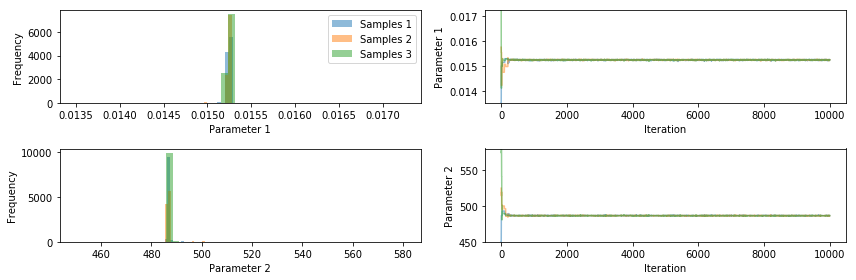

In [35]:
pints.plot.trace(chains_emu)
plt.show()

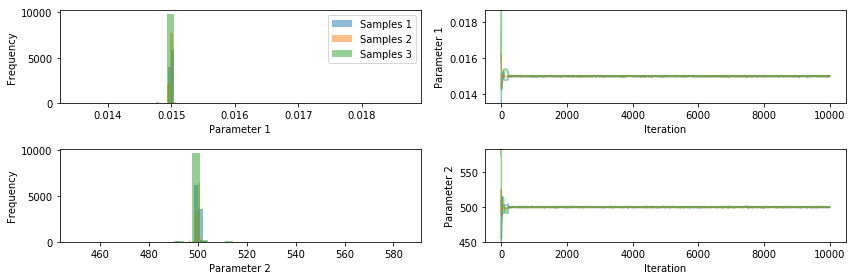

In [36]:
pints.plot.trace(chains)
plt.show()

In [37]:
chain_emu = chains_emu[0]
chain_emu = chain_emu[2000:]
chain = chains[0]
chain = chain[2000:]

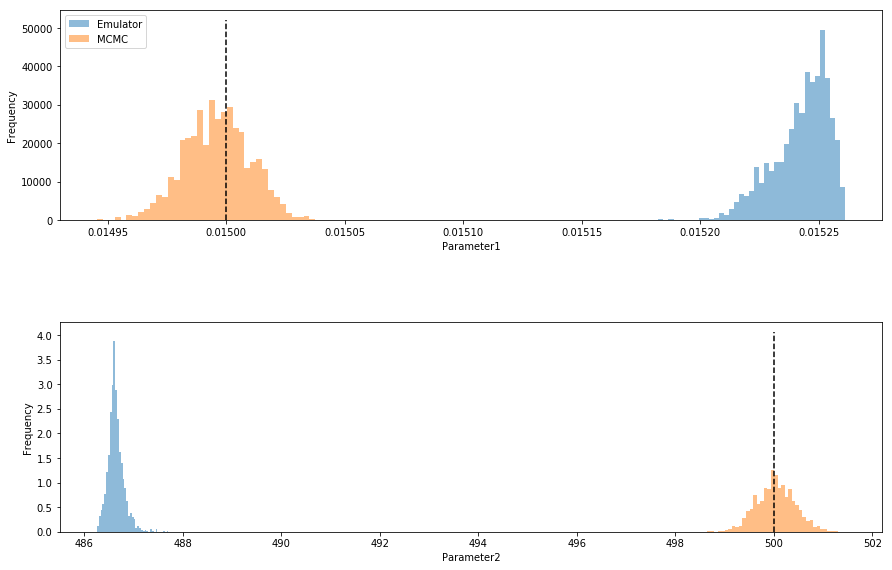

In [38]:
fig, axes = pints.plot.histogram([chain_emu, chain], ref_parameters=true_parameters, sample_names=["Emulator", "MCMC"])
fig.set_size_inches(14, 9)
plt.show()

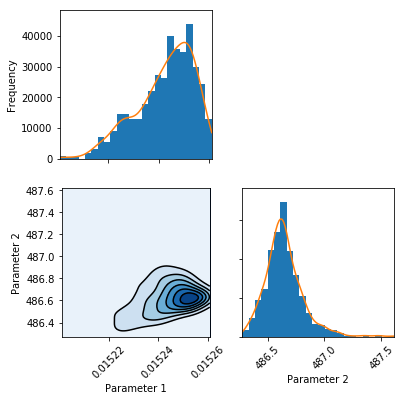

In [39]:
thinned_chain_emu = chain_emu[::10]
pints.plot.pairwise(thinned_chain_emu, kde=True, ref_parameters=true_parameters)
plt.show()

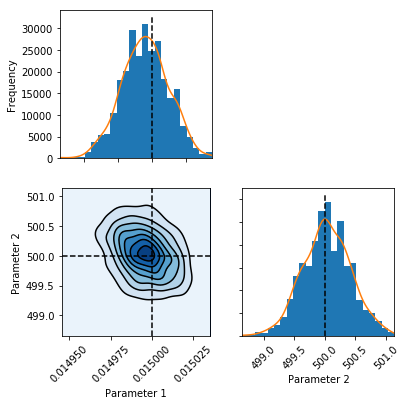

In [40]:
pints.plot.pairwise(thinned_chain, kde=True, ref_parameters=true_parameters)
plt.show()

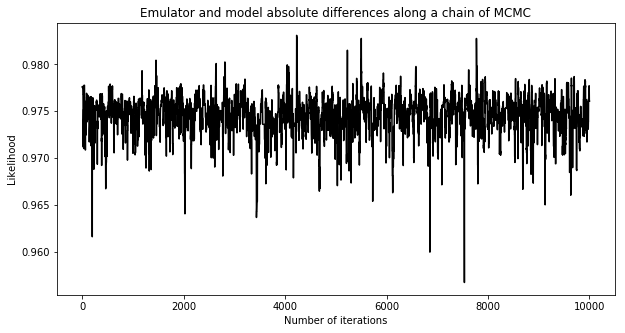

0.9760598104463635

In [41]:
emu_prediction = np.apply_along_axis(emu, 1, chain_emu_rescaled).flatten()
model_prediction = np.apply_along_axis(log_likelihood, 1, chain_rescaled).flatten()
diffs = (np.abs((model_prediction - emu_prediction) / model_prediction))

iters = np.linspace(0, 10000, len(chain_emu_rescaled))
plt.figure(figsize=(10, 5))
plt.title("Emulator and model absolute differences along a chain of MCMC")
plt.xlabel("Number of iterations")
plt.ylabel("Likelihood")
plt.plot(iters, diffs, color = "Black")
plt.show()

diffs[-1]

In [42]:
chain_emu

array([[1.52255387e-02, 4.86704799e+02],
       [1.52221182e-02, 4.86594553e+02],
       [1.52221182e-02, 4.86594553e+02],
       ...,
       [1.52396087e-02, 4.86493278e+02],
       [1.52396087e-02, 4.86493278e+02],
       [1.52396087e-02, 4.86493278e+02]])

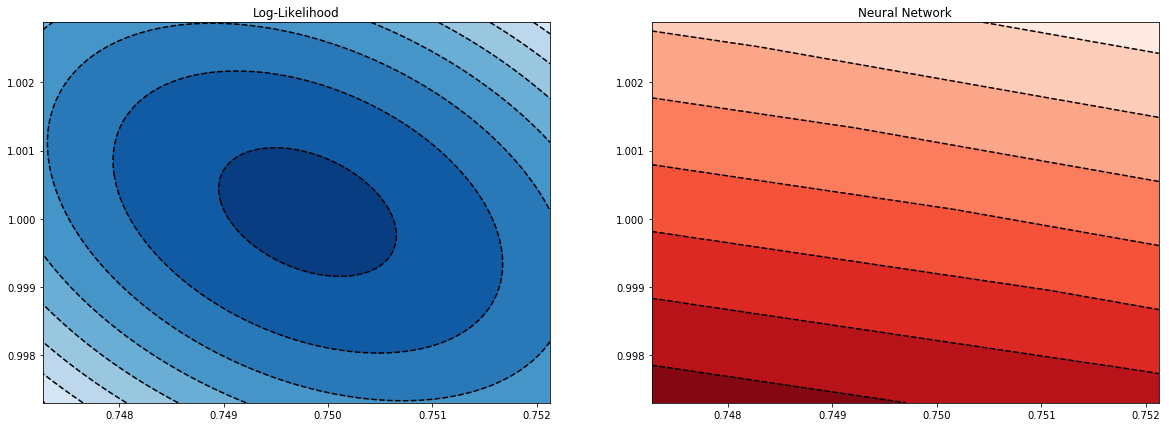

In [51]:
# Create grid of parameters
x = [p[0] for p in chain_rescaled]
y = [p[1] for p in chain_rescaled]
xmin, xmax = np.min(x), np.max(x)
ymin, ymax = np.min(y), np.max(y)
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
params = [list(n) for n in zip(xx, yy)]
ll = np.apply_along_axis(log_likelihood, 1, params)
ll_emu = np.apply_along_axis(emu, 1, params)
ll_emu = [list(e[0][0]) for e in ll_emu]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))
ax1.title.set_text('Log-Likelihood')
ax2.title.set_text('Neural Network')
ax1.contourf(xx, yy, ll, cmap='Blues', extent=[xmin, xmax, ymin, ymax])
ax1.contour(xx, yy, ll, colors='k')
ax2.contourf(xx, yy, ll_emu, cmap='Reds', extent=[xmin, xmax, ymin, ymax])
ax2.contour(xx, yy, ll_emu, colors='k')
plt.show()

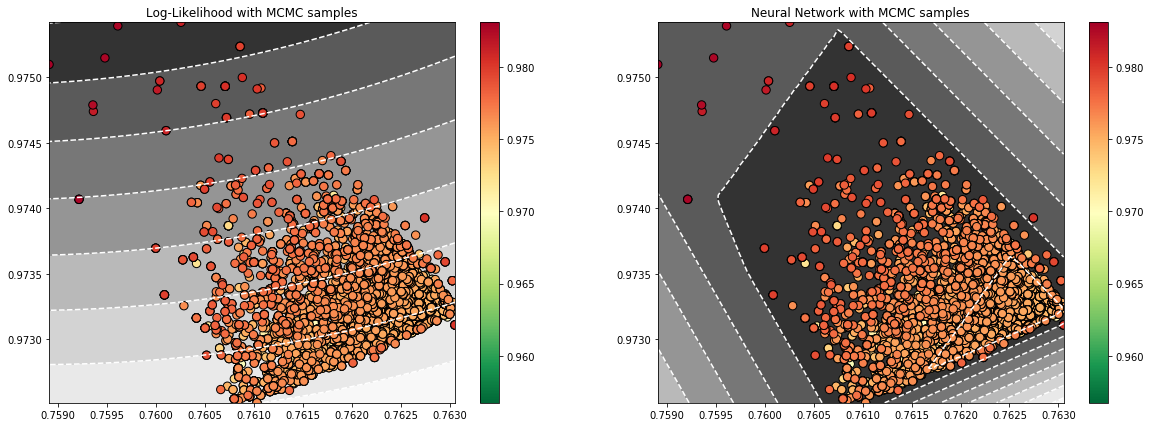

In [49]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))
ax1.title.set_text('Log-Likelihood with MCMC samples')
ax2.title.set_text('Neural Network with MCMC samples')                                                                  

# Create grid of parameters
x = [p[0] for p in chain_emu_rescaled]
y = [p[1] for p in chain_emu_rescaled]
xmin, xmax = np.min(x), np.max(x)
ymin, ymax = np.min(y), np.max(y)
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
params = [list(n) for n in zip(xx, yy)]
ll = np.apply_along_axis(log_likelihood, 1, params)
ll_emu = np.apply_along_axis(emu, 1, params)
ll_emu = [list(e[0][0]) for e in ll_emu]

# Sort according to differences in log-likelihood
idx = diffs.argsort()
x_sorted = np.array(x)[idx]
y_sorted = np.array(y)[idx]
diffs_sorted = diffs[idx]

# Add contour lines of log-likelihood
ax1.contourf(xx, yy, ll, cmap='Greys', extent=[xmin, xmax, ymin, ymax])
ax1.contour(xx, yy, ll, colors='w')

# Plot chain_emu    
ax1.set_xlim([xmin, xmax])                                                                           
ax1.set_ylim([ymin, ymax])
im1 = ax1.scatter(x_sorted, y_sorted, c=diffs_sorted, s=70, edgecolor='k', cmap="RdYlGn_r")

# Add contour lines of emulated likelihood
ax2.contourf(xx, yy, ll_emu, cmap='Greys', extent=[xmin, xmax, ymin, ymax])
ax2.contour(xx, yy, ll_emu, colors='w')

# Plot chain_emu    
ax2.set_xlim([xmin, xmax])                                                                           
ax2.set_ylim([ymin, ymax])
im2 = ax2.scatter(x_sorted, y_sorted, c=diffs_sorted, s=70, edgecolor='k', cmap="RdYlGn_r")

fig.colorbar(im1, ax=ax1)
fig.colorbar(im2, ax=ax2)
plt.show()

Running...
Using Emulated Metropolis MCMC
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Time m:s
0     3      0         0         0          0:00.0
1     6      0.5       0         0.5        0:00.0
2     9      0.333     0         0.333      0:00.0
3     12     0.5       0         0.25       0:00.0
20    63     0.238     0.19      0.19       0:00.0
40    123    0.146     0.171     0.146      0:00.1
60    183    0.0984    0.115     0.115      0:00.1
80    243    0.0741    0.0864    0.0864     0:00.2
100   303    0.0594    0.0792    0.0792     0:00.2
120   363    0.0579    0.0661    0.0661     0:00.3
140   423    0.0567    0.0567    0.0567     0:00.3
160   483    0.0497    0.0497    0.0497     0:00.3
180   543    0.0497    0.0442    0.0442     0:00.4
200   603    0.0448    0.039801  0.039801   0:00.4
220   663    0.0407    0.0362    0.0362     0:00.5
240   723    0.0373    0.0332    0.0332     0:00.5
260   783    0.0383    0.0307    0.0307   

3200  9603   0.00375   0.00312   0.00344    0:06.5
3220  9663   0.00373   0.0031    0.00342    0:06.6
3240  9723   0.0037    0.00309   0.00339    0:06.6
3260  9783   0.00368   0.00307   0.00337    0:06.6
3280  9843   0.00366   0.00305   0.00335    0:06.7
3300  9903   0.00364   0.00303   0.00333    0:06.7
3320  9963   0.00361   0.00301   0.00331    0:06.8
3340  10023  0.00389   0.00299   0.00329    0:06.8
3360  10083  0.00387   0.00298   0.00327    0:06.8
3380  10143  0.00385   0.00296   0.00355    0:06.9
3400  10203  0.00382   0.00294   0.00353    0:06.9
3420  10263  0.0038    0.00292   0.00351    0:06.9
3440  10323  0.00378   0.00291   0.00349    0:07.0
3460  10383  0.00376   0.00289   0.00347    0:07.0
3480  10443  0.00373   0.00287   0.00345    0:07.1
3500  10503  0.00371   0.00286   0.00343    0:07.1
3520  10563  0.00369   0.00284   0.00341    0:07.1
3540  10623  0.00367   0.00282   0.00339    0:07.2
3560  10683  0.00365   0.00281   0.00337    0:07.2
3580  10743  0.00363   0.00279 

6460  19383  0.00201   0.00186   0.00186    0:13.8
6480  19443  0.00201   0.00185   0.00185    0:13.8
6500  19503  0.002     0.00185   0.00185    0:13.8
6520  19563  0.00199   0.00184   0.00184    0:13.9
6540  19623  0.00199   0.00183   0.00183    0:13.9
6560  19683  0.00198   0.00183   0.00183    0:14.0
6580  19743  0.00198   0.00182   0.00182    0:14.0
6600  19803  0.00197   0.00182   0.00182    0:14.1
6620  19863  0.00196   0.00181   0.00181    0:14.1
6640  19923  0.00196   0.00181   0.00181    0:14.1
6660  19983  0.00195   0.0018    0.0018     0:14.2
6680  20043  0.00195   0.0018    0.0018     0:14.2
6700  20103  0.00194   0.00179   0.00179    0:14.3
6720  20163  0.00193   0.00179   0.00179    0:14.3
6740  20223  0.00193   0.00178   0.00178    0:14.4
6760  20283  0.00192   0.00177   0.00177    0:14.4
6780  20343  0.00192   0.00177   0.00177    0:14.5
6800  20403  0.00191   0.00176   0.00176    0:14.5
6820  20463  0.00191   0.00176   0.00176    0:14.5
6840  20523  0.0019    0.00175 

9720  29163  0.00134   0.00134   0.00123    0:20.8
9740  29223  0.00133   0.00133   0.00123    0:20.8
9760  29283  0.00133   0.00133   0.00123    0:20.9
9780  29343  0.00133   0.00133   0.00123    0:20.9
9800  29403  0.00133   0.00133   0.00122    0:21.0
9820  29463  0.00132   0.00132   0.00122    0:21.0
9840  29523  0.00132   0.00132   0.00122    0:21.1
9860  29583  0.00132   0.00132   0.00122    0:21.1
9880  29643  0.00132   0.00132   0.00121    0:21.1
9900  29703  0.00131   0.00131   0.00121    0:21.2
9920  29763  0.00131   0.00131   0.00121    0:21.2
9940  29823  0.00131   0.00131   0.00121    0:21.3
9960  29883  0.00131   0.00131   0.0012     0:21.3
9980  29943  0.0013    0.0013    0.0012     0:21.4
10000 30003  0.0013    0.0013    0.0012     0:21.4
10020 30063  0.0013    0.0013    0.0012     0:21.4
10040 30123  0.00129   0.00129   0.0012     0:21.5
10060 30183  0.00129   0.00129   0.00119    0:21.5
10080 30243  0.00129   0.00129   0.00119    0:21.6
10100 30303  0.00129   0.00129 

12940 38823  0.00108   0.001     0.001      0:27.7
12960 38883  0.00108   0.001     0.001      0:27.8
12980 38943  0.00108   0.001     0.001      0:27.8
13000 39003  0.00108   0.001     0.001      0:27.9
13020 39063  0.00108   0.000998  0.000998   0:27.9
13040 39123  0.00107   0.000997  0.000997   0:28.0
13060 39183  0.00107   0.000995  0.000995   0:28.0
13080 39243  0.00107   0.000994  0.000994   0:28.0
13100 39303  0.00107   0.000992  0.000992   0:28.1
13120 39363  0.00107   0.000991  0.000991   0:28.1
13140 39423  0.00107   0.000989  0.000989   0:28.2
13160 39483  0.00106   0.000988  0.000988   0:28.2
13180 39543  0.00106   0.000986  0.000986   0:28.3
13200 39603  0.00106   0.000985  0.000985   0:28.3
13220 39663  0.00106   0.000983  0.000983   0:28.3
13240 39723  0.00106   0.000982  0.000982   0:28.4
13260 39783  0.00106   0.00098   0.00098    0:28.4
13280 39843  0.00105   0.000979  0.000979   0:28.5
13300 39903  0.00105   0.000977  0.000977   0:28.5
13320 39963  0.00105   0.000976

16220 48663  0.000863  0.000801  0.000801   0:34.8
16240 48723  0.000862  0.0008    0.0008     0:34.9
16260 48783  0.000861  0.000799  0.000799   0:34.9
16280 48843  0.00086   0.000798  0.000798   0:34.9
16300 48903  0.000859  0.000797  0.000797   0:35.0
16320 48963  0.000858  0.000797  0.000797   0:35.0
16340 49023  0.000857  0.000796  0.000796   0:35.1
16360 49083  0.000856  0.000795  0.000795   0:35.1
16380 49143  0.000855  0.000794  0.000794   0:35.2
16400 49203  0.000854  0.000793  0.000793   0:35.2
16420 49263  0.000853  0.000792  0.000792   0:35.2
16440 49323  0.000852  0.000791  0.000791   0:35.3
16460 49383  0.00085   0.00079   0.00079    0:35.3
16480 49443  0.000849  0.000789  0.000789   0:35.4
16500 49503  0.000848  0.000788  0.000788   0:35.4
16520 49563  0.000847  0.000787  0.000787   0:35.5
16540 49623  0.000846  0.000786  0.000786   0:35.5
16560 49683  0.000845  0.000785  0.000785   0:35.5
16580 49743  0.000844  0.000784  0.000784   0:35.6
16600 49803  0.000843  0.000783

19440 58323  0.00072   0.000669  0.000669   0:41.8
19460 58383  0.000719  0.000668  0.000668   0:41.8
19480 58443  0.000719  0.000667  0.000667   0:41.9
19500 58503  0.000718  0.000667  0.000667   0:41.9
19520 58563  0.000717  0.000666  0.000666   0:41.9
19540 58623  0.000716  0.000665  0.000665   0:42.0
19560 58683  0.000716  0.000665  0.000665   0:42.0
19580 58743  0.000715  0.000664  0.000664   0:42.1
19600 58803  0.000714  0.000663  0.000663   0:42.1
19620 58863  0.000714  0.000663  0.000663   0:42.2
19640 58923  0.000713  0.000662  0.000662   0:42.2
19660 58983  0.000712  0.000661  0.000661   0:42.2
19680 59043  0.000711  0.000661  0.000661   0:42.3
19700 59103  0.000711  0.00066   0.00066    0:42.3
19720 59163  0.00071   0.000659  0.000659   0:42.4
19740 59223  0.000709  0.000659  0.000659   0:42.4
19760 59283  0.000708  0.000658  0.000658   0:42.5
19780 59343  0.000708  0.000657  0.000657   0:42.5
19800 59403  0.000707  0.000657  0.000657   0:42.5
19820 59463  0.000706  0.000656

22740 68223  0.000616  0.000572  0.000616   0:48.9
22760 68283  0.000615  0.000571  0.000615   0:48.9
22780 68343  0.000615  0.000571  0.000615   0:49.0
22800 68403  0.000614  0.00057   0.000614   0:49.0
22820 68463  0.000613  0.00057   0.000613   0:49.0
22840 68523  0.000613  0.000569  0.000613   0:49.1
22860 68583  0.000612  0.000569  0.000612   0:49.1
22880 68643  0.000612  0.000568  0.000612   0:49.2
22900 68703  0.000611  0.000568  0.000611   0:49.2
22920 68763  0.000611  0.000567  0.000611   0:49.3
22940 68823  0.00061   0.000567  0.00061    0:49.3
22960 68883  0.00061   0.000566  0.00061    0:49.4
22980 68943  0.000609  0.000566  0.000609   0:49.4
23000 69003  0.000609  0.000565  0.000609   0:49.4
23020 69063  0.000608  0.000565  0.000608   0:49.5
23040 69123  0.000608  0.000564  0.000608   0:49.5
23060 69183  0.000607  0.000564  0.000607   0:49.6
23080 69243  0.000607  0.000563  0.000607   0:49.6
23100 69303  0.000606  0.000563  0.000606   0:49.7
23120 69363  0.000606  0.000562

25960 77883  0.000578  0.000501  0.000539   0:55.8
25980 77943  0.000577  0.0005    0.000539   0:55.9
26000 78003  0.000577  0.0005    0.000538   0:55.9
26020 78063  0.000576  0.0005    0.000538   0:55.9
26040 78123  0.000576  0.000499  0.000538   0:56.0
26060 78183  0.000576  0.000499  0.000537   0:56.0
26080 78243  0.000575  0.000498  0.000537   0:56.1
26100 78303  0.000575  0.000498  0.000536   0:56.1
26120 78363  0.000574  0.000498  0.000536   0:56.2
26140 78423  0.000574  0.000497  0.000536   0:56.2
26160 78483  0.000573  0.000497  0.000535   0:56.2
26180 78543  0.000573  0.000497  0.000535   0:56.3
26200 78603  0.000572  0.000496  0.000534   0:56.3
26220 78663  0.000572  0.000496  0.000534   0:56.4
26240 78723  0.000572  0.000495  0.000534   0:56.4
26260 78783  0.000571  0.000495  0.000533   0:56.5
26280 78843  0.000571  0.000495  0.000533   0:56.5
26300 78903  0.00057   0.000494  0.000532   0:56.5
26320 78963  0.00057   0.000494  0.000532   0:56.6
26340 79023  0.000569  0.000494

29180 87543  0.000514  0.000445  0.00048    1:02.8
29200 87603  0.000514  0.000445  0.000479   1:02.9
29220 87663  0.000513  0.000445  0.000479   1:02.9
29240 87723  0.000513  0.000445  0.000479   1:02.9
29260 87783  0.000513  0.000444  0.000478   1:03.0
29280 87843  0.000512  0.000444  0.000478   1:03.0
29300 87903  0.000512  0.000444  0.000478   1:03.1
29320 87963  0.000512  0.000443  0.000477   1:03.1
29340 88023  0.000511  0.000443  0.000477   1:03.2
29360 88083  0.000511  0.000443  0.000477   1:03.2
29380 88143  0.000511  0.000442  0.000476   1:03.2
29400 88203  0.00051   0.000442  0.000476   1:03.3
29420 88263  0.00051   0.000442  0.000476   1:03.3
29440 88323  0.000509  0.000442  0.000476   1:03.4
29460 88383  0.000509  0.000441  0.000475   1:03.4
29480 88443  0.000509  0.000441  0.000475   1:03.5
29500 88503  0.000508  0.000441  0.000475   1:03.5
29520 88563  0.000508  0.00044   0.000474   1:03.6
29540 88623  0.000508  0.00044   0.000474   1:03.6
29560 88683  0.000507  0.00044 

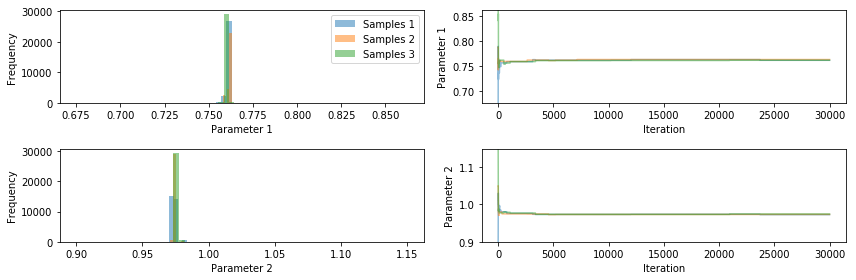

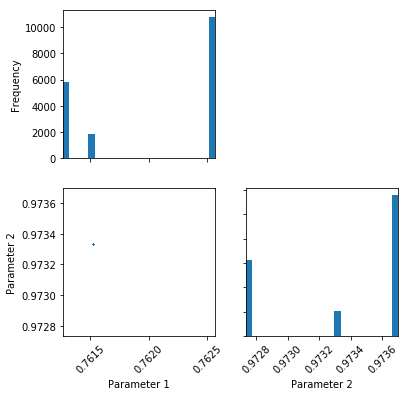

In [64]:
# Choose starting points for 3 mcmc chains
x0s = [
    np.array(start_parameters) * 0.9,
    np.array(start_parameters) * 1.05, #1.1
    np.array(start_parameters) * 1.15,
]
# Choose a covariance matrix for the proposal step
sigma0 = [0.001, 0.001] #np.abs(true_parameters) * 5e-3

# Create mcmc routine
mcmc = pints.MCMCController(emu, 3, x0s, sigma0=sigma0, method=pints.EmulatedMetropolisMCMC, f=log_posterior)

# Add stopping criterion
mcmc.set_max_iterations(30000)

# Disable logging mode
#mcmc.set_log_to_screen(False)

# Run!
print('Running...')
emulated_chains = mcmc.run()
print('Done!')

# Show traces and histograms
pints.plot.trace(emulated_chains)

# Discard warm up
emulated_chains_thinned = emulated_chains[:, 10000:, :]

# Check convergence using rhat criterion
print('R-hat:')
print(pints.rhat_all_params(emulated_chains_thinned))

# Look at distribution in chain 0
pints.plot.pairwise(emulated_chains_thinned[0])

# Show graphs
plt.show()

Running...
Using Metropolis random walk MCMC
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Time m:s
0     3      0         0         0          0:00.0
1     6      0         0.5       0          0:00.0
2     9      0         0.333     0          0:00.0
3     12     0         0.25      0.25       0:00.0
20    63     0.333     0.143     0.381      0:00.0
40    123    0.171     0.0976    0.341      0:00.0
60    183    0.131     0.0656    0.246      0:00.0
80    243    0.0988    0.0617    0.185      0:00.1
100   303    0.0891    0.0495    0.149      0:00.1
120   363    0.0744    0.0496    0.124      0:00.1
140   423    0.0638    0.0426    0.106383   0:00.1
160   483    0.0559    0.0373    0.0994     0:00.1
180   543    0.0497    0.0331    0.0884     0:00.1
200   603    0.0448    0.0299    0.0796     0:00.1
220   663    0.0407    0.0271    0.0724     0:00.2
240   723    0.0373    0.0249    0.0664     0:00.2
260   783    0.0345    0.023     0.0651

3340  10023  0.00419   0.00359   0.00658    0:02.2
3360  10083  0.00417   0.00357   0.00655    0:02.3
3380  10143  0.00414   0.00355   0.00651    0:02.3
3400  10203  0.00412   0.00353   0.00647    0:02.3
3420  10263  0.00409   0.00351   0.00643    0:02.3
3440  10323  0.00407   0.00349   0.00639    0:02.3
3460  10383  0.00405   0.00347   0.00636    0:02.3
3480  10443  0.00402   0.00345   0.00632    0:02.3
3500  10503  0.004     0.00371   0.00628    0:02.3
3520  10563  0.00398   0.00369   0.00625    0:02.4
3540  10623  0.00395   0.00367   0.00621    0:02.4
3560  10683  0.00393   0.00365   0.00618    0:02.4
3580  10743  0.00391   0.00363   0.00614    0:02.4
3600  10803  0.00389   0.00361   0.00611    0:02.4
3620  10863  0.00387   0.00359   0.00608    0:02.4
3640  10923  0.00385   0.00357   0.00604    0:02.4
3660  10983  0.00382   0.00355   0.00601    0:02.5
3680  11043  0.0038    0.00353   0.00598    0:02.5
3700  11103  0.00378   0.00351   0.00594    0:02.5
3720  11163  0.00376   0.00349 

6640  19923  0.00271   0.00196   0.00392    0:04.5
6660  19983  0.0027    0.00195   0.0039     0:04.5
6680  20043  0.00269   0.00195   0.00404    0:04.5
6700  20103  0.00269   0.00194   0.00403    0:04.5
6720  20163  0.00268   0.00193   0.00402    0:04.5
6740  20223  0.00267   0.00193   0.00401    0:04.5
6760  20283  0.00266   0.00192   0.00399    0:04.5
6780  20343  0.00265   0.00192   0.00398    0:04.6
6800  20403  0.00265   0.00191   0.00397    0:04.6
6820  20463  0.00264   0.00191   0.0041     0:04.6
6840  20523  0.00278   0.0019    0.00409    0:04.6
6860  20583  0.00277   0.00189   0.00408    0:04.6
6880  20643  0.00276   0.00189   0.00407    0:04.6
6900  20703  0.00275   0.00188   0.00406    0:04.6
6920  20763  0.00275   0.00188   0.00419    0:04.7
6940  20823  0.00274   0.00187   0.00418    0:04.7
6960  20883  0.00273   0.00187   0.00417    0:04.7
6980  20943  0.00272   0.00186   0.00415    0:04.7
7000  21003  0.00271   0.00186   0.00414    0:04.7
7020  21063  0.00271   0.00185 

9940  29823  0.00211   0.00151   0.00312    0:06.7
9960  29883  0.00211   0.00151   0.00311    0:06.7
9980  29943  0.0021    0.0015    0.00321    0:06.7
10000 30003  0.0021    0.0015    0.0032     0:06.7
10020 30063  0.0021    0.0015    0.00319    0:06.7
10040 30123  0.00209   0.00149   0.00319    0:06.8
10060 30183  0.00209   0.00149   0.00318    0:06.8
10080 30243  0.00208   0.00149   0.00317    0:06.8
10100 30303  0.00208   0.00149   0.00317    0:06.8
10120 30363  0.00207   0.00148   0.00316    0:06.8
10140 30423  0.00207   0.00148   0.00316    0:06.8
10160 30483  0.00207   0.00148   0.00315    0:06.8
10180 30543  0.00206   0.00147   0.00314    0:06.9
10200 30603  0.00206   0.00147   0.00314    0:06.9
10220 30663  0.00205   0.00147   0.00313    0:06.9
10240 30723  0.00205   0.00146   0.00312    0:06.9
10260 30783  0.00205   0.00146   0.00312    0:06.9
10280 30843  0.00204   0.00146   0.00311    0:06.9
10300 30903  0.00204   0.00146   0.00311    0:06.9
10320 30963  0.00203   0.00145 

13240 39723  0.00159   0.00166   0.00287    0:08.9
13260 39783  0.00158   0.001659  0.00294    0:08.9
13280 39843  0.00158   0.00166   0.00294    0:08.9
13300 39903  0.00158   0.00165   0.00293    0:08.9
13320 39963  0.00158   0.00165   0.00293    0:09.0
13340 40023  0.00157   0.00165   0.00292    0:09.0
13360 40083  0.00157   0.00165   0.00292    0:09.0
13380 40143  0.00157   0.00164   0.00291    0:09.0
13400 40203  0.00157   0.00164   0.00291    0:09.0
13420 40263  0.00156   0.00164   0.00291    0:09.0
13440 40323  0.00156   0.00164   0.0029     0:09.0
13460 40383  0.00156   0.00163   0.0029     0:09.0
13480 40443  0.00156   0.00163   0.00289    0:09.1
13500 40503  0.00156   0.00163   0.00289    0:09.1
13520 40563  0.00155   0.00163   0.00288    0:09.1
13540 40623  0.00155   0.00162   0.00288    0:09.1
13560 40683  0.00155   0.00162   0.00288    0:09.1
13580 40743  0.00155   0.00162   0.00287    0:09.1
13600 40803  0.00154   0.00162   0.00287    0:09.1
13620 40863  0.00154   0.00162 

16560 49683  0.00169   0.00145   0.00248    0:11.1
16580 49743  0.00169   0.00145   0.00247    0:11.2
16600 49803  0.00169   0.00145   0.00247    0:11.2
16620 49863  0.00168   0.00144   0.00247    0:11.2
16640 49923  0.00168   0.00144   0.00246    0:11.2
16660 49983  0.00168   0.00144   0.00246    0:11.2
16680 50043  0.00168   0.00144   0.00246    0:11.2
16700 50103  0.00168   0.00144   0.00245    0:11.2
16720 50163  0.00167   0.0015    0.00245    0:11.2
16740 50223  0.00167   0.00149   0.00245    0:11.3
16760 50283  0.00167   0.00149   0.00245    0:11.3
16780 50343  0.00167   0.00149   0.00244    0:11.3
16800 50403  0.00167   0.00149   0.00244    0:11.3
16820 50463  0.00166   0.00149   0.00244    0:11.3
16840 50523  0.00166   0.00148   0.00243    0:11.3
16860 50583  0.00166   0.00148   0.00243    0:11.3
16880 50643  0.00166   0.00148   0.00243    0:11.4
16900 50703  0.00166   0.00148   0.00243    0:11.4
16920 50763  0.00165   0.00148   0.00242    0:11.4
16940 50823  0.00165   0.00148 

19840 59523  0.00146   0.00141   0.00222    0:13.3
19860 59583  0.00146   0.00141   0.00222    0:13.3
19880 59643  0.00146   0.00141   0.00221    0:13.4
19900 59703  0.00146   0.00141   0.00221    0:13.4
19920 59763  0.00146   0.00141   0.00221    0:13.4
19940 59823  0.00145   0.0014    0.00221    0:13.4
19960 59883  0.00145   0.0014    0.0022     0:13.4
19980 59943  0.00145   0.0014    0.0022     0:13.4
20000 60003  0.00145   0.0014    0.0022     0:13.4
20020 60063  0.00145   0.0014    0.0022     0:13.5
20040 60123  0.00145   0.0014    0.0022     0:13.5
20060 60183  0.00145   0.0014    0.00219    0:13.5
20080 60243  0.00144   0.00139   0.00219    0:13.5
20100 60303  0.00144   0.00139   0.00219    0:13.5
20120 60363  0.00144   0.00139   0.00219    0:13.5
20140 60423  0.00144   0.00139   0.00218    0:13.5
20160 60483  0.00144   0.00139   0.00218    0:13.5
20180 60543  0.00144   0.00139   0.00218    0:13.6
20200 60603  0.00144   0.00139   0.00218    0:13.6
20220 60663  0.00143   0.00138 

23140 69423  0.0013    0.00125   0.00194    0:15.5
23160 69483  0.0013    0.00125   0.00194    0:15.6
23180 69543  0.00129   0.00125   0.00194    0:15.6
23200 69603  0.00129   0.00125   0.00194    0:15.6
23220 69663  0.00129   0.00125   0.00194    0:15.6
23240 69723  0.00129   0.00125   0.00194    0:15.6
23260 69783  0.00129   0.00125   0.00193    0:15.6
23280 69843  0.00129   0.00125   0.00193    0:15.6
23300 69903  0.00129   0.00124   0.00193    0:15.7
23320 69963  0.00129   0.00124   0.00193    0:15.7
23340 70023  0.00129   0.00124   0.00193    0:15.7
23360 70083  0.00128   0.00124   0.00193    0:15.7
23380 70143  0.00128   0.00124   0.00192    0:15.7
23400 70203  0.00128   0.00124   0.00192    0:15.7
23420 70263  0.00128   0.00124   0.00192    0:15.7
23440 70323  0.00128   0.00124   0.00192    0:15.7
23460 70383  0.00128   0.00124   0.00192    0:15.8
23480 70443  0.00128   0.00124   0.00192    0:15.8
23500 70503  0.00128   0.00123   0.00191    0:15.8
23520 70563  0.00128   0.00123 

26620 79863  0.00124   0.0012    0.0018     0:17.9
26640 79923  0.00124   0.0012    0.0018     0:17.9
26660 79983  0.00124   0.0012    0.0018     0:17.9
26680 80043  0.00124   0.0012    0.0018     0:17.9
26700 80103  0.00124   0.0012    0.0018     0:18.0
26720 80163  0.00123   0.0012    0.0018     0:18.0
26740 80223  0.00123   0.0012    0.00179    0:18.0
26760 80283  0.00123   0.0012    0.00179    0:18.0
26780 80343  0.00123   0.00119   0.00179    0:18.0
26800 80403  0.00123   0.00119   0.00179    0:18.0
26820 80463  0.00123   0.00119   0.00179    0:18.0
26840 80523  0.00123   0.00119   0.00179    0:18.0
26860 80583  0.00123   0.00119   0.00179    0:18.1
26880 80643  0.00123   0.00119   0.00179    0:18.1
26900 80703  0.00123   0.00119   0.00178    0:18.1
26920 80763  0.00123   0.00119   0.00178    0:18.1
26940 80823  0.00122   0.00119   0.00178    0:18.1
26960 80883  0.00122   0.00119   0.00178    0:18.1
26980 80943  0.00122   0.00119   0.00178    0:18.1
27000 81003  0.00122   0.00119 

29860 89583  0.00131   0.00111   0.00184    0:20.1
29880 89643  0.00131   0.0011    0.00184    0:20.1
29900 89703  0.0013    0.0011    0.00184    0:20.1
29920 89763  0.0013    0.0011    0.00184    0:20.1
29940 89823  0.0013    0.0011    0.00184    0:20.1
29960 89883  0.0013    0.0011    0.00184    0:20.2
29980 89943  0.0013    0.0011    0.00183    0:20.2
30000 90000  0.0013    0.0011    0.00183    0:20.2
Halting: Maximum number of iterations (30000) reached.
Done!
R-hat:
[1.0565255828708695, 1.051789186518726]


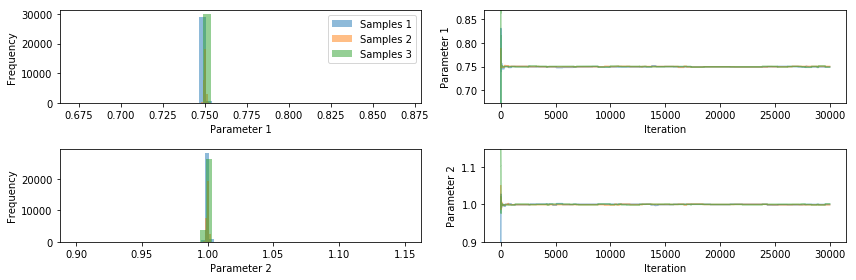

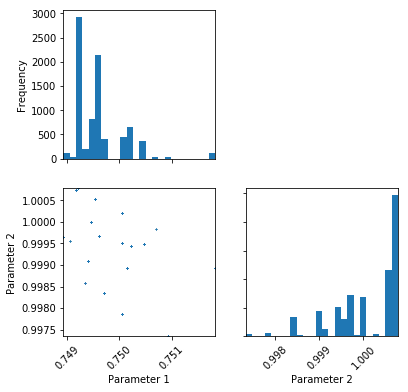

In [63]:
# Choose starting points for 3 mcmc chains
x0s = [
    np.array(start_parameters) * 0.9,
    np.array(start_parameters) * 1.05, #1.1
    np.array(start_parameters) * 1.15,
]
# Choose a covariance matrix for the proposal step
sigma0 = [0.001, 0.001] #np.abs(true_parameters) * 5e-5

# Create mcmc routine
mcmc = pints.MCMCController(log_posterior, 3, x0s, sigma0=sigma0, method=pints.MetropolisRandomWalkMCMC)

# Add stopping criterion
mcmc.set_max_iterations(30000)

# Disable logging mode
#mcmc.set_log_to_screen(False)

# Run!
print('Running...')
metropolis_chains = mcmc.run()
print('Done!')

# Show traces and histograms
pints.plot.trace(metropolis_chains)

# Discard warm up
metropolis_chains_thinned = metropolis_chains[:, 10000:, :]

# Check convergence using rhat criterion
print('R-hat:')
print(pints.rhat_all_params(metropolis_chains_thinned))

# Look at distribution in chain 0
pints.plot.pairwise(metropolis_chains_thinned[0])

# Show graphs
plt.show()

In [54]:
metropolis_chains.shape

(3, 30000, 2)

In [55]:
metropolis_chains[0][:10]

array([[0.675     , 0.9       ],
       [0.675     , 0.9       ],
       [0.675     , 0.9       ],
       [0.675     , 0.9       ],
       [0.69739346, 0.97328032],
       [0.74713766, 0.93623626],
       [0.74713766, 0.93623626],
       [0.78707056, 0.9471038 ],
       [0.78707056, 0.9471038 ],
       [0.78707056, 0.9471038 ]])

In [56]:
emulated_chains[0][:10]

array([[0.675     , 0.9       ],
       [0.77316012, 0.87283929],
       [0.77743458, 0.94475911],
       [0.77743458, 0.94475911],
       [0.77743458, 0.94475911],
       [0.77743458, 0.94475911],
       [0.77743458, 0.94475911],
       [0.77743458, 0.94475911],
       [0.77743458, 0.94475911],
       [0.77743458, 0.94475911]])